In [5]:
from matplotlib import pyplot as plt
import gzip
import numpy as np
import random

# Get data

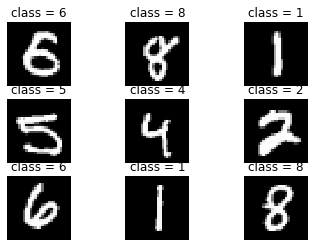

In [6]:
train_x_filename = 'data/train-images-idx3-ubyte.gz'
train_y_filename = 'data/train-labels-idx1-ubyte.gz'
test_x_filename = 'data/t10k-images-idx3-ubyte.gz'
test_y_filename = 'data/t10k-labels-idx1-ubyte.gz'

def get_image(path):
    with gzip.open(path, 'r') as f:
        magic_number = int.from_bytes(f.read(4), 'big')
        image_count = int.from_bytes(f.read(4), 'big')
        row_count = int.from_bytes(f.read(4), 'big')
        column_count = int.from_bytes(f.read(4), 'big')
        image_data = f.read()
        images = np.frombuffer(image_data, dtype=np.uint8).reshape((image_count, row_count, column_count))
        return images
def get_label(path):
    with gzip.open(path, 'r') as f:
        magic_number = int.from_bytes(f.read(4), 'big')
        label_count = int.from_bytes(f.read(4), 'big')
        label_data = f.read()
        labels = np.frombuffer(label_data, dtype=np.uint8)
        return labels
    
train_X = get_image(train_x_filename)
train_y = get_label(train_y_filename)
test_X = get_image(test_x_filename)
test_y = get_label(test_y_filename)

for c in range(1,10):
    plt.subplot(3,3,c)
    i = random.randint(0,train_X.shape[0])
    im = train_X[i]
    plt.axis("off")
    plt.title("class = {}".format(train_y[i]))
    plt.imshow(im, cmap='gray')


# Reshape

In [7]:
train_X = train_X.reshape(60000,784)
test_X = test_X.reshape(10000,784)

# Continuous Mode

In [8]:
import numpy as np
from tqdm import tqdm
class bayes_continuos_mode:
    def initialize_data(self, X, y):
        self.n_samples = X.shape[0]
        self.n_features = X.shape[1]
        self.class_type = np.unique(y)
        self.n_classes = len(self.class_type)
        
        #initial mean, var, priors
        self.mean = np.zeros((self.n_classes, self.n_features), dtype=np.float64)
        self.var = np.zeros((self.n_classes, self.n_features), dtype=np.float64)
        self.priors = np.zeros(self.n_classes, np.float64)
    
    def fit(self, X, y):
        self.compute_mean(X, y)
        self.compute_var(X, y)
        self.compute_priors(X, y)
        
    def compute_mean(self, X, y):
        for c in self.class_type:
            X_c = X[y==c]
            self.mean[c, :] = X_c.mean(axis=0)
        return self.mean
    
    def compute_var(self, X, y):
        for c in self.class_type:
            X_c = X[y==c]
            self.var[c, :] = X_c.var(axis=0)
            for i in range(self.var.shape[0]):
                for j in range(self.var.shape[1]):
                    self.var[i][j] = 1000 if self.var[i][j]==0 else self.var[i][j] 
        return self.var
    
    def compute_priors(self, X, y):
        for c in self.class_type:
            X_c = X[y==c]
            self.priors[c] = X_c.shape[0] / self.n_samples
        return self.priors
    
    def predict(self, X, y):
        # compute the max posterior
        self.y_pred = np.zeros(X.shape[0])
        self.posterior_record = np.zeros((10000,10))
        for idx, x in enumerate(X):
            posteriors = []
            for c in self.class_type:
                priors = np.log(self.priors[c])
                class_condictional = self.MLE(c, idx, x)
                tmp = priors + class_condictional
                posteriors.append(tmp)
            sumation = sum(posteriors)
            tmpp =  np.divide(posteriors, sumation)
            self.posterior_record[idx][:] = tmpp
            self.y_pred[idx] = (self.class_type[np.argmin(tmpp)])
        return self.y_pred
    
    def MLE(self, class_idx, image_idx, x):
        #print('test image {} class {} processing....'.format(image_idx, class_idx))
        likelihood = np.zeros((784))
        mean = self.mean[class_idx]
        var = self.var[class_idx]
        likelihood = -0.5 * (np.log(2 * np.pi * var) + ((x - mean) ** 2) / var)
        return np.sum(likelihood)
    
    def print_answer(self, ans):
        correct = 0
        error = 0
        with open('posterior_continuous.txt.txt', 'w') as f:
            for image_idx in range(len(ans)):
                print('Postirior (in log scale) : \n')
                f.write(('Postirior (in log scale) : \n'))
                for c in self.class_type:
                    print('{}: {}\n'.format(c, self.posterior_record[image_idx][c]))
                    f.write('{}: {}\n'.format(c, self.posterior_record[image_idx][c]))
                print('Prediction : {}, Ans:{} \n'.format(self.y_pred[image_idx], ans[image_idx]))
                print('')
                f.write('Prediction : {}, Ans:{} \n'.format(self.y_pred[image_idx], ans[image_idx]))
                f.write('\n')
            for idx in range(10000):
                if ans[idx] == self.y_pred[idx]:
                    correct+=1
                else:
                    error+=1
            print('error rate: {}'.format(error/10000))
            f.write('error rate: {}'.format(error/10000))
     
    def draw_imagination(self, image_row, image_col):
        image = self.mean
        with open('imagination_continous.txt', 'w') as f:
            for i in range(self.n_classes):
                print(f'{i}')
                f.write(f'{i} \n')
                for j in range(image_row):
                    for k in range(image_col):
                        print(f'{1 if image[i][j * image_row + k] > 128 else 0} ', end='')
                        f.write(f'{1 if image[i][j * image_row + k] > 128 else 0} ')
                    print()
                    f.write('\n')
                print()
                f.write('\n')
            
model = bayes_continuos_mode()
model.initialize_data(train_X, train_y)
model.fit(train_X, train_y)
model.predict(test_X, test_y)
model.print_answer(test_y) 
model.draw_imagination(28, 28)



    
        
            

Postirior (in log scale) : 

0: 0.006673210176134111

1: 0.18941004368474587

2: 0.008867191822755555

3: 0.006951291443758171

4: 0.006276369260027082

5: 0.0057255674193338844

6: 0.7589820019615341

7: 0.004586963232200556

8: 0.007695935084476583

9: 0.004831425915034216

Prediction : 7.0, Ans:7 


Postirior (in log scale) : 

0: 0.02094167815928118

1: 0.008916201421869148

2: 0.0020149991051939225

3: 0.3258810268266647

4: 0.009178876480209177

5: 0.004712096969487422

6: 0.004933714838774615

7: 0.4249631779321921

8: 0.013550740978665866

9: 0.18490748728766174

Prediction : 2.0, Ans:2 


Postirior (in log scale) : 

0: 7.737543053761754e-05

1: 5.5778732756437335e-05

2: 7.104368474070166e-05

3: 7.082148132325547e-05

4: 7.081602970210896e-05

5: 7.143322482824739e-05

6: 7.148584502745156e-05

7: 0.9993580603333296

8: 7.113775884820356e-05

9: 8.204747890625272e-05

Prediction : 1.0, Ans:1 


Postirior (in log scale) : 

0: 0.05290186712821971

1: 0.39976813212027934

2: 0


3: 0.0781753913074249

4: 0.07363229018632662

5: 0.07734125719139298

6: 0.08862776692251548

7: 0.07727292217497793

8: 0.07772023302324263

9: 0.07405177385002767

Prediction : 4.0, Ans:4 


Postirior (in log scale) : 

0: 0.06384199712802743

1: 0.33992523566248084

2: 0.06817225246518127

3: 0.06595395470674648

4: 0.06955318108642729

5: 0.0673126724806498

6: 0.10435825592500356

7: 0.08045363542590961

8: 0.06666826263494782

9: 0.07376055248462576

Prediction : 0.0, Ans:0 


Postirior (in log scale) : 

0: 0.0953846331491703

1: 0.07101677943865375

2: 0.08834677968400412

3: 0.08666376141714378

4: 0.0886751442237387

5: 0.08783122290758219

6: 0.08708647924775398

7: 0.18583149615139025

8: 0.08789388930297544

9: 0.12126981447758747

Prediction : 1.0, Ans:1 


Postirior (in log scale) : 

0: 0.0961248801078959

1: 0.17559578087250483

2: 0.12235553090631916

3: 0.07615530073975987

4: 0.08073323168906212

5: 0.07858300165110058

6: 0.1351123715145175

7: 0.0776180014349272


Prediction : 6.0, Ans:6 


Postirior (in log scale) : 

0: 0.06970962860829234

1: 0.29762809756622693

2: 0.07419025222918539

3: 0.07061250822354015

4: 0.07160777710660006

5: 0.07132612713324266

6: 0.12493044703553709

7: 0.07777964647660385

8: 0.07043395812390682

9: 0.07178155749686485

Prediction : 0.0, Ans:0 


Postirior (in log scale) : 

0: 0.058286410578984864

1: 0.4724588418428474

2: 0.05645832463320376

3: 0.05605229100133642

4: 0.05145488908182082

5: 0.05484272955668604

6: 0.07739657197023948

7: 0.05628567003076447

8: 0.055096297935805484

9: 0.061667973368311035

Prediction : 4.0, Ans:4 


Postirior (in log scale) : 

0: 0.10746289114686342

1: 0.07739954415532194

2: 0.09951447567929542

3: 0.09799842165478101

4: 0.09814478884167599

5: 0.09890625948723407

6: 0.12630200448653425

7: 0.09903212424811118

8: 0.09845560436475992

9: 0.0967838859354228

Prediction : 1.0, Ans:1 


Postirior (in log scale) : 

0: 0.01808410591315094

1: 0.1795619953988866

2: 0.01


2: 7.038931368043859e-05

3: 7.802430543401593e-05

4: 9.475677477800977e-05

5: 7.800737632098616e-05

6: 9.238347675727137e-05

7: 0.9945930322776486

8: 7.949839770141727e-05

9: 0.004666231843165139

Prediction : 2.0, Ans:2 


Postirior (in log scale) : 

0: 0.050708469910656036

1: 0.3518425502792874

2: 0.031588207376818896

3: 0.03166667370762424

4: 0.03178778343243184

5: 0.028363834529708375

6: 0.035459731849973745

7: 0.02338065080250272

8: 0.3914530261985011

9: 0.02374907191249569

Prediction : 7.0, Ans:7 


Postirior (in log scale) : 

0: 0.012238453390033448

1: 0.02880781836512982

2: 0.011794536754808307

3: 0.01162476749490367

4: 0.01088473954819217

5: 0.011105031775132631

6: 0.016139862782086123

7: 0.8727135699572709

8: 0.011002615412507707

9: 0.013688604519935225

Prediction : 4.0, Ans:8 


Postirior (in log scale) : 

0: 0.030517429047956197

1: 0.7242193351060973

2: 0.029427644824733902

3: 0.02884555833024394

4: 0.026070258901968006

5: 0.0277634474831


6: 0.07826149279172728

7: 0.13518098823233837

8: 0.07834575459707596

9: 0.08367687111680566

Prediction : 4.0, Ans:4 


Postirior (in log scale) : 

0: 0.00011549783358269028

1: 9.987436285039567e-05

2: 0.00010674221878164902

3: 0.00010491832483986608

4: 0.00011891231080985382

5: 0.00010664306092054159

6: 0.00013548900588865445

7: 0.9989498437321759

8: 0.00010442039935527097

9: 0.00015765875079512895

Prediction : 1.0, Ans:8 


Postirior (in log scale) : 

0: 0.030712009752382703

1: 0.021875496211016237

2: 0.028698452240186356

3: 0.025644919365790206

4: 0.025606311509957555

5: 0.025912179582757846

6: 0.766362295200738

7: 0.024738711569995662

8: 0.025508622279918264

9: 0.024941002287256965

Prediction : 1.0, Ans:7 


Postirior (in log scale) : 

0: 0.09270164309851854

1: 0.08016299018398042

2: 0.09161412480441015

3: 0.0851935154369101

4: 0.0881791393659311

5: 0.08700061571502897

6: 0.20202450287213092

7: 0.09358907528929536

8: 0.08716639834089979

9: 0.0923

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Postirior (in log scale) : 

0: 0.07141797513160177

1: 0.2529449798659664

2: 0.07460342753014627

3: 0.06771165094307882

4: 0.06962457376592279

5: 0.06859446323185224

6: 0.1617655150099774

7: 0.07759977116810175

8: 0.06952718522634474

9: 0.08621045812700778

Prediction : 3.0, Ans:5 


Postirior (in log scale) : 

0: 0.0001588310365367681

1: 0.0002888528880350178

2: 0.00013387611329086465

3: 0.00015012568195464938

4: 0.00019131541314219315

5: 0.0001685511817284247

6: 0.00014070868653578197

7: 0.998277312506494

8: 0.0002016959886250942

9: 0.0002887305036571987

Prediction : 2.0, Ans:2 


Postirior (in log scale) : 

0: 0.460025334319295

1: 0.09635310253398549

2: 0.029242158666560863

3: 0.02666870503787869

4: 0.026928558509472643

5: 0.02542768237954347

6: 0.09085781577640875

7: 0.021821501967814707

8: 0.2028265701925804

9: 0.019848570616459876

Prediction : 9.0, Ans:9 


Postirior (in log scale) : 

0: 0.0810273207971687

1: 0.46717244563054017

2: 0.06228282581


0: 0.007397299853379977

1: 0.006354477453321678

2: 0.007484397529594916

3: 0.006116379370321335

4: 0.0061109187753015035

5: 0.006225954084162601

6: 0.9422419012602713

7: 0.0058957228775768575

8: 0.006200392357866026

9: 0.005972556438203882

Prediction : 7.0, Ans:7 


Postirior (in log scale) : 

0: 0.06561759330260551

1: 0.37245292694490567

2: 0.03783885557101271

3: 0.03991300545244211

4: 0.04199684406243476

5: 0.03716722560437129

6: 0.041864441923262344

7: 0.029902599364186315

8: 0.30333650807110873

9: 0.02990999970367044

Prediction : 7.0, Ans:9 


Postirior (in log scale) : 

0: 0.005147955422931111

1: 0.1925061364312349

2: 0.002774635556350122

3: 0.0030997510889389087

4: 0.007227963720784996

5: 0.008291224271060523

6: 0.0029294637521376215

7: 0.16708907685503996

8: 0.02547434214457195

9: 0.5854594507569499

Prediction : 2.0, Ans:2 


Postirior (in log scale) : 

0: 0.000729610165260355

1: 0.0005053116224986902

2: 0.0003232622397686415

3: 0.00070231797


0: 0.04163339172907795

1: 0.152951398418467

2: 0.26923725984945923

3: 0.2578249507400104

4: 0.03951857848119913

5: 0.03303710561155526

6: 0.08879141300981158

7: 0.03822622067634553

8: 0.03319489605866011

9: 0.045584785425413714

Prediction : 5.0, Ans:5 


Postirior (in log scale) : 

0: 0.043185222052312844

1: 0.06353750886414186

2: 0.0034188449569613442

3: 0.00624486620299393

4: 0.00416255915188843

5: 0.0014989500423233466

6: 0.08051898271916624

7: 0.0011081666426030344

8: 0.02555860545435157

9: 0.7707662939132573

Prediction : 7.0, Ans:7 


Postirior (in log scale) : 

0: 0.0072919968725230645

1: 0.02096676106080256

2: 0.007520489124743106

3: 0.006645317737400966

4: 0.006413134580878871

5: 0.005737074560778233

6: 0.9278950299549459

7: 0.004696739200368072

8: 0.00799900257363354

9: 0.004834454333925722

Prediction : 7.0, Ans:7 


Postirior (in log scale) : 

0: 0.06331102953428809

1: 0.07808016285111863

2: 0.054098226807959754

3: 0.05182162030135324

4: 


4: 0.09305491553144028

5: 0.09291240080160056

6: 0.16837269248954828

7: 0.09810685396444158

8: 0.09196990171995505

9: 0.091875660059224

Prediction : 1.0, Ans:1 


Postirior (in log scale) : 

0: 0.07710149347556633

1: 0.1279449864202661

2: 0.07526260517119576

3: 0.07264995757611138

4: 0.07599610255890193

5: 0.07370024532982099

6: 0.07894501245526625

7: 0.2524007410814267

8: 0.0742737774417801

9: 0.09172507848966441

Prediction : 3.0, Ans:5 


Postirior (in log scale) : 

0: 0.057372550547715624

1: 0.42241896599095763

2: 0.052720282440999786

3: 0.05049554066101587

4: 0.04786192413406091

5: 0.04913314800283444

6: 0.1689668766497273

7: 0.053227656835627524

8: 0.049734709834189386

9: 0.048068344902871575

Prediction : 4.0, Ans:8 


Postirior (in log scale) : 

0: 7.68781619341463e-05

1: 0.00010971748680160113

2: 7.185189222226146e-05

3: 7.578731347738778e-05

4: 0.00010807339145253856

5: 7.673955728068503e-05

6: 8.78620955827681e-05

7: 0.9867950778581319

8: 


6: 0.8421591232334843

7: 0.007833095322535339

8: 0.008141569222038502

9: 0.007594202828442376

Prediction : 9.0, Ans:9 


Postirior (in log scale) : 

0: 0.00014959503948572324

1: 0.0002156699949192913

2: 0.00017166246667746905

3: 0.026337546330576826

4: 0.0001183742869295973

5: 0.00011509018718885786

6: 0.00011362080158856446

7: 0.9463849886080935

8: 0.00014356037543280473

9: 0.026249891909107346

Prediction : 6.0, Ans:6 


Postirior (in log scale) : 

0: 0.022092429657977627

1: 0.26444224836074337

2: 0.29150512382499644

3: 0.3122482773962254

4: 0.015341456664339052

5: 0.014136030987743976

6: 0.024242587613294585

7: 0.017442928626907963

8: 0.014099121182081094

9: 0.02444979568569063

Prediction : 8.0, Ans:5 


Postirior (in log scale) : 

0: 0.003666657524246432

1: 0.025183412096611926

2: 0.0030434734104717604

3: 0.003054354772346429

4: 0.0035670427927140124

5: 0.003496033213180438

6: 0.0034530822645061606

7: 0.10759467950568755

8: 0.0038842210353915835



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




9: 0.06463918845736154

Prediction : 9.0, Ans:4 


Postirior (in log scale) : 

0: 0.00033340872750844855

1: 0.8356046011563731

2: 0.0006962293139785822

3: 0.14355066270659078

4: 0.0004688540410255708

5: 0.00047776666423214424

6: 0.0004904168727716676

7: 0.012632446470628184

8: 0.00047217282324163375

9: 0.005273441223649946

Prediction : 0.0, Ans:0 


Postirior (in log scale) : 

0: 0.008415966935264925

1: 0.012269686855211688

2: 0.0003835614580906881

3: 0.00026752369584893265

4: 0.0006032152816493758

5: 0.0002821925318566659

6: 0.02058362544805464

7: 0.00020589066804668426

8: 0.0003029372919653074

9: 0.956685399834011

Prediction : 7.0, Ans:3 


Postirior (in log scale) : 

0: 0.08891746066097828

1: 0.22602018675743765

2: 0.08538903787167117

3: 0.07912940971107203

4: 0.08318207793593946

5: 0.08163751157252781

6: 0.10079783686003913

7: 0.08887213783434039

8: 0.0821356707566992

9: 0.08391867003929471

Prediction : 3.0, Ans:3 


Postirior (in log scale) : 

0:


0: 0.022987106444542976

1: 0.7435945772287196

2: 0.02575603098554322

3: 0.025351555073094362

4: 0.026403619934427327

5: 0.02452336730269128

6: 0.044042032633687764

7: 0.033680752365907916

8: 0.02578936856845563

9: 0.02787158946293007

Prediction : 0.0, Ans:0 


Postirior (in log scale) : 

0: 0.06055445134348484

1: 0.22466507157023863

2: 0.05975681882825291

3: 0.05793692320041883

4: 0.067352754227644

5: 0.06054440132831961

6: 0.06204871802407705

7: 0.24812327771684276

8: 0.06070731237174043

9: 0.09831027138898081

Prediction : 3.0, Ans:3 


Postirior (in log scale) : 

0: 0.10902105075303588

1: 0.07733527907800668

2: 0.09937746869096845

3: 0.09555892584243061

4: 0.09572053315158016

5: 0.09616797486867362

6: 0.13679001503488794

7: 0.100168836993755

8: 0.09552407013033443

9: 0.09433584545632726

Prediction : 1.0, Ans:1 


Postirior (in log scale) : 

0: 0.024128152046308984

1: 0.17648512308754463

2: 0.008512207616814179

3: 0.00797854902009238

4: 0.00839871


3: 0.09123304273526472

4: 0.08828712056712773

5: 0.09182690890018133

6: 0.12056724029828995

7: 0.08799706348618834

8: 0.09040637264301221

9: 0.08635667784867818

Prediction : 9.0, Ans:9 


Postirior (in log scale) : 

0: 0.0981836208766994

1: 0.08975327535256199

2: 0.09066159721592265

3: 0.0876039179709095

4: 0.08770394940129086

5: 0.08866901314712061

6: 0.19160824977555302

7: 0.09252943651142206

8: 0.08674246054426328

9: 0.08654447920425667

Prediction : 9.0, Ans:8 


Postirior (in log scale) : 

0: 0.09138319905934378

1: 0.08951153411438387

2: 0.08931914018708992

3: 0.08561088300179388

4: 0.08436481408394585

5: 0.08517619801905574

6: 0.21619378454606406

7: 0.09096045093760018

8: 0.08364223280353705

9: 0.08383776324718581

Prediction : 8.0, Ans:8 


Postirior (in log scale) : 

0: 0.004820552141353086

1: 0.014649681192531464

2: 0.002361052253271554

3: 0.002070250813815713

4: 0.0025092285001520145

5: 0.003818361110899866

6: 0.007705294906239446

7: 0.0043


7: 0.126268080381678

8: 0.013423201938443647

9: 0.6474711329963937

Prediction : 6.0, Ans:6 


Postirior (in log scale) : 

0: 0.021371746090717337

1: 0.6832480037090657

2: 0.019371439380164442

3: 0.02181385141164207

4: 0.024821203495362095

5: 0.02135960494343917

6: 0.01832780636637155

7: 0.10370838082046666

8: 0.024770800721140816

9: 0.0612071630616302

Prediction : 6.0, Ans:6 


Postirior (in log scale) : 

0: 0.0374574760479201

1: 0.5573971500425824

2: 0.03544750221033068

3: 0.03784972750071921

4: 0.04312958217286762

5: 0.038383435008065805

6: 0.03270892583698683

7: 0.1226965654827585

8: 0.044032903253499144

9: 0.05089673244426973

Prediction : 6.0, Ans:6 


Postirior (in log scale) : 

0: 0.16043303087923344

1: 0.2508423527333218

2: 0.13113417679947081

3: 0.05202147918479302

4: 0.09064495534807206

5: 0.06130556882973693

6: 0.05719683430187937

7: 0.048437901945119946

8: 0.08876233810371821

9: 0.05922136187465428

Prediction : 7.0, Ans:3 


Postirior (in


0: 0.0001236850668642033

1: 8.896110991402844e-05

2: 0.00011367844167223319

3: 0.00011271324368703155

4: 0.00011316305323869777

5: 0.00011386475236562892

6: 0.00011420341610584965

7: 0.9989839896796378

8: 0.00011351927704979221

9: 0.00012222195946474772

Prediction : 1.0, Ans:1 


Postirior (in log scale) : 

0: 0.001346496334705007

1: 0.9735173822658987

2: 0.0015447830704529172

3: 0.012315289607755171

4: 0.001477851772286684

5: 0.0017051724995286335

6: 0.0014144287823054267

7: 0.0018044629122387864

8: 0.0017325527413091658

9: 0.0031415800135195203

Prediction : 0.0, Ans:0 


Postirior (in log scale) : 

0: 0.08552759976894299

1: 0.158720783916447

2: 0.08674771168927796

3: 0.08136199985889936

4: 0.08340000897103249

5: 0.08181734761698521

6: 0.1617325683848728

7: 0.0958377258397482

8: 0.08233849075417143

9: 0.08251576319962264

Prediction : 3.0, Ans:5 


Postirior (in log scale) : 

0: 0.00012503678054860673

1: 0.00021291892790379962

2: 0.000119201742335125

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Prediction : 3.0, Ans:3 


Postirior (in log scale) : 

0: 0.0009741848263007614

1: 0.01552840099712995

2: 0.0009228978231145717

3: 0.0009952437254429113

4: 0.0014243661891091724

5: 0.0010434596557550978

6: 0.002037080448169432

7: 0.8781360952109787

8: 0.0011132072644730142

9: 0.09782506385952651

Prediction : 2.0, Ans:2 


Postirior (in log scale) : 

0: 0.05681557900475541

1: 0.09247084802794982

2: 0.05923593272110808

3: 0.04751010779880072

4: 0.04667016088739518

5: 0.04806855794670419

6: 0.5095527701815581

7: 0.04582170920886169

8: 0.04788391004891884

9: 0.04597042417394788

Prediction : 7.0, Ans:7 


Postirior (in log scale) : 

0: 0.10673371857110633

1: 0.09466297726697548

2: 0.094686301247019

3: 0.0914700988889637

4: 0.09132356513071851

5: 0.09341543837013679

6: 0.13231099892115722

7: 0.0957601211942272

8: 0.09244944574727641

9: 0.10718733466241918

Prediction : 4.0, Ans:7 


Postirior (in log scale) : 

0: 0.08075630154242582

1: 0.23413944660499822

2


2: 0.08557207950523546

3: 0.08084867514711584

4: 0.09021542361295279

5: 0.08399824692505524

6: 0.1709285668996015

7: 0.09486617903451958

8: 0.08355356620206617

9: 0.09968912413455469

Prediction : 3.0, Ans:3 


Postirior (in log scale) : 

0: 0.03420164723753309

1: 0.04515840450867349

2: 0.04109385022194418

3: 0.026687907024948474

4: 0.026831664167150344

5: 0.02725588391230404

6: 0.71874988748954

7: 0.02682569216628615

8: 0.027000791733154138

9: 0.026194271538465982

Prediction : 9.0, Ans:3 


Postirior (in log scale) : 

0: 0.09277438776538481

1: 0.11791125103754792

2: 0.08653373367422183

3: 0.08539322587198916

4: 0.08638445930047166

5: 0.08637649889180932

6: 0.1821814947024232

7: 0.08541575994666345

8: 0.08396156854090853

9: 0.09306762026858019

Prediction : 8.0, Ans:3 


Postirior (in log scale) : 

0: 0.019457606975981347

1: 0.5568410284433472

2: 0.028058652661191025

3: 0.020729261075649246

4: 0.018814542836182148

5: 0.017630722560114713

6: 0.2865285


6: 0.19244868888539496

7: 0.09038779862512117

8: 0.08262087903519416

9: 0.08218307189751436

Prediction : 9.0, Ans:8 


Postirior (in log scale) : 

0: 0.007942043685699722

1: 0.0077112907164724855

2: 0.009825481313870003

3: 0.005632659014623937

4: 0.005576438138745834

5: 0.005580542806477962

6: 0.9410696058211544

7: 0.005587271101627005

8: 0.005587785990270178

9: 0.005486881411058585

Prediction : 9.0, Ans:5 


Postirior (in log scale) : 

0: 0.11270817617280827

1: 0.09720059465417309

2: 0.16142769218074515

3: 0.08206958199577812

4: 0.08142432034090107

5: 0.08239319831100689

6: 0.14399414629886295

7: 0.07873795514151904

8: 0.08128719252953492

9: 0.07875714237467038

Prediction : 7.0, Ans:7 


Postirior (in log scale) : 

0: 0.0001068637271305674

1: 0.00011832292492197226

2: 0.00010257020422293399

3: 9.98644610465055e-05

4: 0.00011223036773462071

5: 0.00010218542648601572

6: 0.00010970496436878835

7: 0.9990020715197006

8: 0.00010113037946890361

9: 0.00014


8: 0.03269596329571472

9: 0.02881839239847286

Prediction : 9.0, Ans:9 


Postirior (in log scale) : 

0: 0.0033792488901522202

1: 0.007636764748161138

2: 0.002276830129179091

3: 0.0021949612229312473

4: 0.0022361069701092927

5: 0.0025009002314508454

6: 0.004035542190347598

7: 0.002573364030943774

8: 0.002985798978291387

9: 0.9701804826084334

Prediction : 3.0, Ans:8 


Postirior (in log scale) : 

0: 0.06173161382179299

1: 0.20103242426005175

2: 0.05134210000565136

3: 0.05369787549469715

4: 0.07132534925334742

5: 0.06571877200491767

6: 0.05270383703200584

7: 0.22592927550840425

8: 0.09028791589670505

9: 0.12623083672242658

Prediction : 2.0, Ans:2 


Postirior (in log scale) : 

0: 8.164672423517378e-05

1: 9.161001386068812e-05

2: 7.101043063716761e-05

3: 7.464627241319606e-05

4: 8.846319696870496e-05

5: 7.612264405477162e-05

6: 7.298904553308101e-05

7: 0.9913477730144782

8: 8.064390009850999e-05

9: 0.008015094757720487

Prediction : 2.0, Ans:2 


Postirio


Prediction : 3.0, Ans:3 


Postirior (in log scale) : 

0: 0.002249946721301445

1: 0.6670192775171865

2: 0.0024555319067458355

3: 0.002184982449271195

4: 0.0018245599359968843

5: 0.002005234454901689

6: 0.3127096288434813

7: 0.001666801588924004

8: 0.006284688683375837

9: 0.001599347898815661

Prediction : 9.0, Ans:7 


Postirior (in log scale) : 

0: 0.09753790770268495

1: 0.16272411763950584

2: 0.09021316395930079

3: 0.0874327313686104

4: 0.0858832926107117

5: 0.08657639478782991

6: 0.12334501555193939

7: 0.09641392615775676

8: 0.08555242794307524

9: 0.08432102227858489

Prediction : 9.0, Ans:2 


Postirior (in log scale) : 

0: 0.09506160175296743

1: 0.14616145465799474

2: 0.09125054973864824

3: 0.09132060852846802

4: 0.08734925368082802

5: 0.09060926001787627

6: 0.10312426980122165

7: 0.11437229778538782

8: 0.09019001957758842

9: 0.09056068445901919

Prediction : 4.0, Ans:4 


Postirior (in log scale) : 

0: 0.0004560902500843021

1: 0.000640894766512324

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0: 0.0005764885549670604

1: 0.009742383691543044

2: 0.0005034765440833848

3: 0.0005180442404035722

4: 0.0006140530896462312

5: 0.0005495903703126087

6: 0.0005705909662112171

7: 0.8857569410947206

8: 0.0005920822815934355

9: 0.10057634916651885

Prediction : 2.0, Ans:5 


Postirior (in log scale) : 

0: 0.011386036904361912

1: 0.8373430157184153

2: 0.013041221140768958

3: 0.015382855294466766

4: 0.013397245637633785

5: 0.014376549809430187

6: 0.023605525733604266

7: 0.02085405611821356

8: 0.03261547708651846

9: 0.01799801655658659

Prediction : 0.0, Ans:0 


Postirior (in log scale) : 

0: 0.028431467937301298

1: 0.7446492984735175

2: 0.027577290296118745

3: 0.028277951635141765

4: 0.024721585292953104

5: 0.026755364535384858

6: 0.03863670821071875

7: 0.027603004824342334

8: 0.02750665968362675

9: 0.025840669110894717

Prediction : 4.0, Ans:4 


Postirior (in log scale) : 

0: 7.219490222106363e-05

1: 0.00020121441979692754

2: 7.402646062592844e-05

3: 7.421


1: 0.04889503886618463

2: 0.01880920651505118

3: 0.013671064005905816

4: 0.01408315551556046

5: 0.014157311081177505

6: 0.8316435301550764

7: 0.013713839748162523

8: 0.014011514516260287

9: 0.013763991362688556

Prediction : 3.0, Ans:3 


Postirior (in log scale) : 

0: 0.03472379237015206

1: 0.6898215429133974

2: 0.03277581375314888

3: 0.03222022434688288

4: 0.030523790032915686

5: 0.0318618928016547

6: 0.051389015177908566

7: 0.03368655084038991

8: 0.032580064699446035

9: 0.030417313064103686

Prediction : 9.0, Ans:4 


Postirior (in log scale) : 

0: 0.1046738809426516

1: 0.0766742810234869

2: 0.09839369467260554

3: 0.09680616593151621

4: 0.09701001397586635

5: 0.0975002326214329

6: 0.13952366639669647

7: 0.09663166943005824

8: 0.09731836180950401

9: 0.09546803319618184

Prediction : 1.0, Ans:1 


Postirior (in log scale) : 

0: 9.12037907565637e-05

1: 0.0006525196595833527

2: 9.692133960328289e-05

3: 9.783713729115072e-05

4: 9.963536222169085e-05

5: 


7: 0.09791612880512936

8: 0.0976691588112312

9: 0.09440443769201118

Prediction : 9.0, Ans:4 


Postirior (in log scale) : 

0: 0.015080276052005154

1: 0.02328752363736301

2: 0.012643401808292713

3: 0.012934966708155691

4: 0.014263956646239091

5: 0.013447251051084111

6: 0.013094640075824351

7: 0.16139449406663772

8: 0.013322684450493978

9: 0.7205308055039041

Prediction : 2.0, Ans:2 


Postirior (in log scale) : 

0: 0.09017690927938771

1: 0.3465309372736531

2: 0.05586686836604727

3: 0.06170815855685739

4: 0.05286207159396842

5: 0.05765605036745472

6: 0.12134282776425756

7: 0.07342178758409984

8: 0.05775082180915986

9: 0.08268356740511404

Prediction : 4.0, Ans:4 


Postirior (in log scale) : 

0: 0.09827712302435736

1: 0.06997162802698376

2: 0.08692631597362407

3: 0.08503420884925218

4: 0.0874624317487229

5: 0.08630781119421031

6: 0.08603012284888907

7: 0.19128493847775796

8: 0.08577361021910142

9: 0.12293180963710099

Prediction : 1.0, Ans:1 


Postirior


0: 0.04118621972084728

1: 0.5978858590234555

2: 0.042861904197154695

3: 0.04167622341444254

4: 0.038264477781188126

5: 0.04041288295546278

6: 0.06164173626747729

7: 0.05304371754944805

8: 0.041804002406541856

9: 0.04122297668398188

Prediction : 4.0, Ans:4 


Postirior (in log scale) : 

0: 0.05860275000763273

1: 0.30634794226131123

2: 0.054384444944552926

3: 0.056311460334260065

4: 0.0520003484974316

5: 0.05448436737693691

6: 0.2116025864821475

7: 0.08790157378080693

8: 0.05433705157366549

9: 0.0640274747412546

Prediction : 4.0, Ans:4 


Postirior (in log scale) : 

0: 0.009878582377598009

1: 0.8720325288610467

2: 0.01109113657888866

3: 0.014676604372715498

4: 0.011629881280459298

5: 0.011956086277992632

6: 0.010836340185660808

7: 0.016201333106060825

8: 0.013180748088831101

9: 0.028516758870746735

Prediction : 0.0, Ans:0 


Postirior (in log scale) : 

0: 0.007026240779129376

1: 0.005648091759974501

2: 0.006937084097759011

3: 0.005201991838863824

4: 


0: 0.0610525243809588

1: 0.14910125403685695

2: 0.09293645943850351

3: 0.08357154473170618

4: 0.12283892702591091

5: 0.05394387307390131

6: 0.2107731326382775

7: 0.07680710500768456

8: 0.0528668912921882

9: 0.09610828837401215

Prediction : 8.0, Ans:4 


Postirior (in log scale) : 

0: 0.00018733107191842868

1: 0.000267732355980673

2: 0.00017615534807364326

3: 0.00017960044217475067

4: 0.00023130956815162716

5: 0.0001852919443982008

6: 0.000227132958481029

7: 0.9836890366941325

8: 0.0002004516574236935

9: 0.014655957959265446

Prediction : 2.0, Ans:2 


Postirior (in log scale) : 

0: 0.1136954169684465

1: 0.07896559820021655

2: 0.10135237935505818

3: 0.10020145787382831

4: 0.10050245728761996

5: 0.10129839822722896

6: 0.10600655666971778

7: 0.09911710693716846

8: 0.10062979747741707

9: 0.09823083100329817

Prediction : 1.0, Ans:1 


Postirior (in log scale) : 

0: 0.05685613396316411

1: 0.36497865657811696

2: 0.04180363447440507

3: 0.04453585319094572

4

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Postirior (in log scale) : 

0: 0.052906371770334575

1: 0.2201066195570222

2: 0.053904243795707976

3: 0.05341728996643521

4: 0.05771321583440427

5: 0.053878756335316226

6: 0.06730790780535147

7: 0.3166977259789726

8: 0.053598098654425164

9: 0.07046977030203024

Prediction : 0.0, Ans:0 


Postirior (in log scale) : 

0: 0.00025790720675587076

1: 0.010107546252747741

2: 0.0002759321724370381

3: 0.00032450086481933515

4: 0.0003909939000634808

5: 0.0002857738740612608

6: 0.0004037262544300722

7: 0.9661482926026757

8: 0.0003481371830563546

9: 0.02145718968895325

Prediction : 0.0, Ans:0 


Postirior (in log scale) : 

0: 0.0005359191489294137

1: 0.001589442717753219

2: 0.0006963625659946106

3: 0.0006262944204968692

4: 0.000495079759427722

5: 0.00048810010075439814

6: 0.0009050847345290728

7: 0.991960593543001

8: 0.0004984883167399545

9: 0.0022046346923737495

Prediction : 5.0, Ans:5 


Postirior (in log scale) : 

0: 0.10225370517056967

1: 0.13843212423507376

2


1: 0.10589161023793744

2: 0.08577687133759145

3: 0.08322309682221402

4: 0.09167666096356442

5: 0.08517851138819468

6: 0.17794953357734383

7: 0.10562497419178048

8: 0.08372161460138493

9: 0.09105659466333346

Prediction : 3.0, Ans:2 


Postirior (in log scale) : 

0: 0.05067398610906408

1: 0.2603931329182

2: 0.021443889364052855

3: 0.018844544921217628

4: 0.025091286917458388

5: 0.02987384541679888

6: 0.29953330709668824

7: 0.02384797520101825

8: 0.031036677918541276

9: 0.23926135413696056

Prediction : 3.0, Ans:3 


Postirior (in log scale) : 

0: 0.03234499980495825

1: 0.22974863908628168

2: 0.015768549154639686

3: 0.0110604077396314

4: 0.011981005889234718

5: 0.012927401574393859

6: 0.6479749632112256

7: 0.010087153626827213

8: 0.01268432193101362

9: 0.015422557981793919

Prediction : 7.0, Ans:2 


Postirior (in log scale) : 

0: 0.06781028171328268

1: 0.3091276323718599

2: 0.0678189808100926

3: 0.06243158398463501

4: 0.06648359653770017

5: 0.064464769


7: 0.1533688156734547

8: 0.09445216259930175

9: 0.0996817170202713

Prediction : 1.0, Ans:1 


Postirior (in log scale) : 

0: 0.1066637671430027

1: 0.1288677808388418

2: 0.09384412575242905

3: 0.0936701216009812

4: 0.09282161768464434

5: 0.09497742859637552

6: 0.10707456815105491

7: 0.09736474325429251

8: 0.09209826572682846

9: 0.09261758125154956

Prediction : 8.0, Ans:7 


Postirior (in log scale) : 

0: 0.08356519943778479

1: 0.23070673156533994

2: 0.08435050841754707

3: 0.07981514018057617

4: 0.07791244333631289

5: 0.07947224355604912

6: 0.10390277162411866

7: 0.08040051744155742

8: 0.0804428294716557

9: 0.0994316149690584

Prediction : 4.0, Ans:5 


Postirior (in log scale) : 

0: 0.21826545025524008

1: 0.35120361977720543

2: 0.04249528076504597

3: 0.07786098201097079

4: 0.04039739109888913

5: 0.0431992024042485

6: 0.0360776183900727

7: 0.04093936082527891

8: 0.05326558495571076

9: 0.09629550951733788

Prediction : 6.0, Ans:6 


Postirior (in log sca


0: 8.568180744899721e-05

1: 5.902402580216414e-05

2: 7.270368913056152e-05

3: 7.383964323416773e-05

4: 7.713942617746583e-05

5: 7.462653390616398e-05

6: 7.299171750679526e-05

7: 0.9945193191132489

8: 7.445865376095295e-05

9: 0.0048902153897839185

Prediction : 1.0, Ans:1 


Postirior (in log scale) : 

0: 0.0790069666980662

1: 0.13666548177472537

2: 0.08254437986503783

3: 0.07616161816510877

4: 0.07922856231779087

5: 0.07412516449641855

6: 0.2279951161429286

7: 0.08761459545198619

8: 0.07414447840460187

9: 0.08251363668333563

Prediction : 5.0, Ans:5 


Postirior (in log scale) : 

0: 0.09639978468898132

1: 0.06934491890328945

2: 0.08672391528204276

3: 0.08554330567841563

4: 0.08792483141965439

5: 0.08672299156070512

6: 0.08635632797541912

7: 0.19222174463551903

8: 0.08643063488780228

9: 0.12233154496817104

Prediction : 1.0, Ans:1 


Postirior (in log scale) : 

0: 0.007627387621301266

1: 0.12059028863119035

2: 0.004470724237354263

3: 0.00496080990800577


2: 0.1019188203052

3: 0.09871203093158022

4: 0.09889318515006827

5: 0.09945772936224985

6: 0.11229378701146023

7: 0.10044827685463847

8: 0.09930229138121201

9: 0.09857326362292564

Prediction : 1.0, Ans:1 


Postirior (in log scale) : 

0: 0.13548170508377502

1: 0.11947089816559571

2: 0.10010030255221326

3: 0.0889955114405038

4: 0.08637924548098895

5: 0.08961166649292009

6: 0.12105881355715521

7: 0.08608127687582358

8: 0.0884290038374272

9: 0.0843915765135973

Prediction : 9.0, Ans:9 


Postirior (in log scale) : 

0: 0.05046547701486818

1: 0.38325893451940535

2: 0.03171367130347309

3: 0.030529507267601255

4: 0.03314098884074041

5: 0.028476859715782874

6: 0.03733535676666459

7: 0.02347527799297467

8: 0.35767893746517904

9: 0.023924989113310546

Prediction : 7.0, Ans:7 


Postirior (in log scale) : 

0: 0.10371488658235913

1: 0.08557730231405539

2: 0.09442727481332668

3: 0.09105134493875912

4: 0.09067163963030914

5: 0.09145083035357277

6: 0.17101165376016

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




7: 0.031561850697362955

8: 0.05680360944687277

9: 0.017590619583695916

Prediction : 2.0, Ans:2 


Postirior (in log scale) : 

0: 0.00045965681034073583

1: 0.0016439056543038695

2: 0.000316411950563277

3: 0.00041556545893670213

4: 0.00037222828812470893

5: 0.0003525195601388288

6: 0.0008336711783943555

7: 0.994653653517889

8: 0.000345154492052226

9: 0.0006072330892562539

Prediction : 2.0, Ans:2 


Postirior (in log scale) : 

0: 0.09332550157982179

1: 0.13608502594694485

2: 0.08546560837598914

3: 0.07965088114150005

4: 0.08207343125182968

5: 0.08308106571546882

6: 0.1837957545861193

7: 0.08322127339386445

8: 0.08248737466468187

9: 0.09081408334378017

Prediction : 3.0, Ans:3 


Postirior (in log scale) : 

0: 0.09198522333317566

1: 0.08788044654226863

2: 0.09140759638879459

3: 0.08329961159064747

4: 0.08698751580487613

5: 0.08543431292934062

6: 0.20761244494709424

7: 0.0939354800637089

8: 0.0849072757440468

9: 0.08655009265604706

Prediction : 3.0, Ans:3


Prediction : 4.0, Ans:7 


Postirior (in log scale) : 

0: 9.150540468151043e-05

1: 7.55249491949093e-05

2: 8.438993321451546e-05

3: 8.30138271673712e-05

4: 9.283727764044086e-05

5: 8.45326846918991e-05

6: 0.00015881627369119898

7: 0.9991244884725983

8: 8.435874796064219e-05

9: 0.00012053242915922189

Prediction : 1.0, Ans:3 


Postirior (in log scale) : 

0: 0.05979448334773275

1: 0.05163084974375822

2: 0.051932127074702225

3: 0.05227323944614601

4: 0.05384919735866598

5: 0.05341172092639817

6: 0.05329394640324164

7: 0.5114130672093253

8: 0.05143056020828964

9: 0.06097080828173993

Prediction : 8.0, Ans:8 


Postirior (in log scale) : 

0: 0.06712649393304032

1: 0.2850727462368881

2: 0.06999967968070325

3: 0.0688637733874173

4: 0.07096400541775899

5: 0.06986414763744557

6: 0.06965064783475425

7: 0.14928930905746615

8: 0.06882169398385912

9: 0.08034750283066676

Prediction : 0.0, Ans:0 


Postirior (in log scale) : 

0: 0.004043985425454595

1: 0.00684564540


5: 0.08452669257619276

6: 0.11069081132929241

7: 0.09178545498978659

8: 0.08532974804844147

9: 0.085749412132145

Prediction : 3.0, Ans:5 


Postirior (in log scale) : 

0: 0.06603043009024517

1: 0.03362827665821251

2: 0.012334125017644993

3: 0.7233505629894701

4: 0.02289960991064614

5: 0.02525754317806016

6: 0.019638236796445097

7: 0.050621300201844466

8: 0.02527380822937329

9: 0.020966106928057945

Prediction : 2.0, Ans:2 


Postirior (in log scale) : 

0: 0.004818764462274133

1: 0.008019418695526285

2: 0.004134011661390733

3: 0.004321112469615208

4: 0.00512546679956843

5: 0.004380647734447506

6: 0.006884152830418738

7: 0.9503753259296817

8: 0.004411918273341685

9: 0.00752918114373564

Prediction : 2.0, Ans:2 


Postirior (in log scale) : 

0: 0.021681581102744586

1: 0.1508553340554408

2: 0.003156130537007561

3: 0.015095821387902676

4: 0.00805434882021061

5: 0.007661438622858896

6: 0.0030029379897209578

7: 0.1607492907371017

8: 0.022104408013348873

9: 


8: 0.02204210437129736

9: 0.016259203047606075

Prediction : 7.0, Ans:7 


Postirior (in log scale) : 

0: 0.03229958260202815

1: 0.7474723431076478

2: 0.0038442461142170065

3: 0.004666079849279906

4: 0.010373160612029073

5: 0.01001054030868032

6: 0.0033849302837038594

7: 0.11262133644169857

8: 0.030107240901083798

9: 0.045220539779631704

Prediction : 6.0, Ans:6 


Postirior (in log scale) : 

0: 0.13706279817476855

1: 0.22828044941655948

2: 0.08811211678976441

3: 0.07629134520042472

4: 0.0730197742002392

5: 0.07591654618601507

6: 0.09615566761696921

7: 0.07170054977369522

8: 0.07618655619719499

9: 0.07727419644436934

Prediction : 7.0, Ans:7 


Postirior (in log scale) : 

0: 0.03991430040098849

1: 0.0941199579065593

2: 0.033795367800018315

3: 0.034872726889346214

4: 0.04753958587889328

5: 0.04456111659574508

6: 0.03403803702766346

7: 0.15223377359371562

8: 0.07708584009988471

9: 0.44183929380718556

Prediction : 2.0, Ans:8 


Postirior (in log scale) : 



9: 0.008256032287923503

Prediction : 6.0, Ans:6 


Postirior (in log scale) : 

0: 0.10079481756844047

1: 0.11579174614223924

2: 0.09356781932909561

3: 0.09088290977983447

4: 0.08983109520524979

5: 0.09017195310301038

6: 0.14594728786004849

7: 0.0949814279400788

8: 0.08746663960162578

9: 0.09056430347037686

Prediction : 8.0, Ans:8 


Postirior (in log scale) : 

0: 7.120463476941947e-05

1: 0.0035659609991590697

2: 8.159543269838876e-05

3: 9.067136481024325e-05

4: 8.51535803259133e-05

5: 8.242332229090545e-05

6: 8.555591943753043e-05

7: 0.9956773594472182

8: 9.257758931321307e-05

9: 0.00016749770997715046

Prediction : 0.0, Ans:0 


Postirior (in log scale) : 

0: 0.007655669565936634

1: 0.04736543142120103

2: 0.0020640655855443265

3: 0.004967501033721651

4: 0.002116835379564896

5: 0.0037779933556872525

6: 0.017991616699831424

7: 0.012035377727554253

8: 0.007270405810537737

9: 0.8947551034204209

Prediction : 2.0, Ans:4 


Postirior (in log scale) : 

0: 0.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




5: 0.07031963932340733

6: 0.06160390254274656

7: 0.2722928808924738

8: 0.0827476350391975

9: 0.16344038154681567

Prediction : 2.0, Ans:2 


Postirior (in log scale) : 

0: 0.008357651096568084

1: 0.03381760983573262

2: 0.007216560104557714

3: 0.006308342932389398

4: 0.006222734070361511

5: 0.005976125976032933

6: 0.9142435018003368

7: 0.005379375458065002

8: 0.007232254913874623

9: 0.0052458438120813215

Prediction : 9.0, Ans:9 


Postirior (in log scale) : 

0: 0.09113519035539608

1: 0.21874379190168128

2: 0.08629633748636759

3: 0.08159987011792419

4: 0.07948897139686514

5: 0.08162543206513155

6: 0.11839094576248592

7: 0.08253210557666121

8: 0.08211642424260687

9: 0.07807093109488009

Prediction : 9.0, Ans:4 


Postirior (in log scale) : 

0: 0.0066582084775287

1: 0.020435482868771945

2: 0.007194560900778349

3: 0.007229249383097922

4: 0.007153797358631855

5: 0.006785630445036454

6: 0.01046670954043391

7: 0.9157017695756625

8: 0.006780639874561566

9: 0.

6: 7.294337841108603e-05

7: 0.9981833089022893

8: 8.074662766483248e-05

9: 0.001204726518978203

Prediction : 1.0, Ans:6 


Postirior (in log scale) : 

0: 0.07778167632545642

1: 0.17569761282462393

2: 0.07345712404714119

3: 0.06747110466472789

4: 0.07653430063012957

5: 0.07098279938385894

6: 0.21191231865484064

7: 0.07776946482807925

8: 0.07082704846717969

9: 0.09756655017396254

Prediction : 3.0, Ans:3 


Postirior (in log scale) : 

0: 0.07943295428285094

1: 0.3091254952394422

2: 0.07149505411319844

3: 0.06701049306648038

4: 0.07153928138650832

5: 0.07006713499169423

6: 0.09346329415167597

7: 0.0819900700053846

8: 0.07053657564696453

9: 0.08533964711580048

Prediction : 3.0, Ans:3 


Postirior (in log scale) : 

0: 0.13510369333286998

1: 0.2983398077230009

2: 0.019019317864658745

3: 0.020815580178540252

4: 0.02365763126217706

5: 0.020259132019016426

6: 0.038614934543354906

7: 0.015153060032623478

8: 0.4144434486020961

9: 0.014593394441662362

Prediction


3: 0.02418932919907828

4: 0.021160884605474193

5: 0.020525331274539732

6: 0.049418558778645046

7: 0.014515272606892116

8: 0.24459272799784343

9: 0.014844744526742504

Prediction : 7.0, Ans:7 


Postirior (in log scale) : 

0: 0.00825244767233299

1: 0.06666241328600914

2: 0.00978218074453286

3: 0.007197029511329618

4: 0.006857061838560145

5: 0.006710200814656705

6: 0.874909891937009

7: 0.005943696436165445

8: 0.00758561602501966

9: 0.006099461734384401

Prediction : 7.0, Ans:7 


Postirior (in log scale) : 

0: 0.0987350089354398

1: 0.08180740286128713

2: 0.08775388939079388

3: 0.08536814498757474

4: 0.0878338750837147

5: 0.08664255992323366

6: 0.08766629965396344

7: 0.18101758200074045

8: 0.0862821529466738

9: 0.11689308421657846

Prediction : 1.0, Ans:1 


Postirior (in log scale) : 

0: 0.06033424541324077

1: 0.1176414290101427

2: 0.06288737013949895

3: 0.051866645290204

4: 0.049875016414920224

5: 0.051561940116323375

6: 0.4548394664846665

7: 0.0498785


1: 0.01390934511242634

2: 0.014075106675913846

3: 0.013285871359564968

4: 0.013243914175876881

5: 0.013322629887441586

6: 0.026743206794258043

7: 0.8624966533034374

8: 0.013385142973549783

9: 0.01563713516819637

Prediction : 4.0, Ans:5 


Postirior (in log scale) : 

0: 0.05159590260478737

1: 0.4009208296102107

2: 0.056906449013902745

3: 0.05319879058857441

4: 0.05365548387507047

5: 0.051835838188660346

6: 0.10970501295361698

7: 0.10493539161078895

8: 0.05335421518476675

9: 0.06389208636962138

Prediction : 0.0, Ans:5 


Postirior (in log scale) : 

0: 0.05584250668821768

1: 0.22300495584654736

2: 0.08974606454258549

3: 0.06226743918795739

4: 0.06138316559176016

5: 0.05182569269892738

6: 0.31484578077696007

7: 0.03344082354046477

8: 0.0727259701256682

9: 0.034917601000911506

Prediction : 7.0, Ans:7 


Postirior (in log scale) : 

0: 0.09667026211568504

1: 0.14350284687834733

2: 0.10637138378997149

3: 0.09540472355164095

4: 0.08489548124225792

5: 0.0879


5: 0.029684432562872915

6: 0.04165128154974332

7: 0.025470451812444388

8: 0.07300002176739516

9: 0.024273032788138287

Prediction : 9.0, Ans:9 


Postirior (in log scale) : 

0: 0.0789311642141092

1: 0.24982489163486976

2: 0.07766291589982972

3: 0.07460550631233442

4: 0.0743994033822981

5: 0.07507494227426434

6: 0.09854252270831171

7: 0.11678876102774417

8: 0.07549197553012679

9: 0.07867791701611192

Prediction : 4.0, Ans:5 


Postirior (in log scale) : 

0: 0.29914895760084564

1: 0.23116320465631607

2: 0.017986229079882204

3: 0.01483433094410112

4: 0.01566744748682918

5: 0.020292766625504857

6: 0.2053179704614975

7: 0.011220235947915625

8: 0.08285077087860138

9: 0.10151808631850621

Prediction : 7.0, Ans:7 


Postirior (in log scale) : 

0: 0.11289367769557161

1: 0.07846782234182689

2: 0.10095503758142382

3: 0.09956601354827738

4: 0.0999733246875729

5: 0.1006029488203711

6: 0.10905364645781561

7: 0.1003243601959199

8: 0.09997373685975965

9: 0.0981894318

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




1: 0.09142238458135954

2: 0.09362541074784389

3: 0.08916974190736107

4: 0.08860203473551508

5: 0.08914728613877337

6: 0.17232396412735737

7: 0.10105400212727966

8: 0.08703930052253606

9: 0.08912387454607908

Prediction : 8.0, Ans:8 


Postirior (in log scale) : 

0: 0.00018480805971223338

1: 0.00016893297165882277

2: 0.00017325646967622182

3: 0.0001715592109816825

4: 0.00018101312003088128

5: 0.00017398185416318322

6: 0.00017879320085354783

7: 0.9983664728821942

8: 0.00017142344557464405

9: 0.00022975878515455549

Prediction : 1.0, Ans:8 


Postirior (in log scale) : 

0: 0.07630108367009267

1: 0.19354470805743385

2: 0.0728639725569614

3: 0.06643441599030395

4: 0.07589534035040635

5: 0.0691518242331167

6: 0.19890941323462763

7: 0.09972250772126227

8: 0.06825652340161091

9: 0.07892021078418425

Prediction : 3.0, Ans:3 


Postirior (in log scale) : 

0: 0.10597143434193783

1: 0.170669425649235

2: 0.09389867226191607

3: 0.09021924913639869

4: 0.0868419720773


5: 0.013236474319108078

6: 0.022823453115844605

7: 0.012681142669332224

8: 0.02752761666199584

9: 0.01222438995852273

Prediction : 0.0, Ans:0 


Postirior (in log scale) : 

0: 0.11096356189396273

1: 0.0788038413673136

2: 0.10001031023739422

3: 0.09786438239343569

4: 0.09802534581095607

5: 0.098752507188854

6: 0.12139253892637089

7: 0.10016058835707954

8: 0.0978333967009204

9: 0.09619352712371282

Prediction : 1.0, Ans:1 


Postirior (in log scale) : 

0: 0.10291475705576576

1: 0.12286183144910419

2: 0.09457839852090714

3: 0.09380165250988466

4: 0.09122692844974283

5: 0.09367131225506799

6: 0.12329208378194081

7: 0.09564206659715543

8: 0.0920461860917166

9: 0.08996478328871453

Prediction : 9.0, Ans:4 


Postirior (in log scale) : 

0: 0.18126971241672996

1: 0.005044111011815088

2: 0.0008707405172944257

3: 0.0019575732251377845

4: 0.04360137773981719

5: 0.001136512479985026

6: 0.000790164191674656

7: 0.6611562330462175

8: 0.012865160239857835

9: 0.09130


0: 0.0021927392397820804

1: 0.001994113571885868

2: 0.0019189230621439125

3: 0.0019446784354586568

4: 0.00208757010460113

5: 0.0019796585207179037

6: 0.002060470391398565

7: 0.9813997202428095

8: 0.0019423896115000345

9: 0.002479736819702304

Prediction : 2.0, Ans:2 


Postirior (in log scale) : 

0: 0.10087037829380474

1: 0.08593694221485072

2: 0.09019568883569687

3: 0.0888272668769273

4: 0.0908304385261559

5: 0.09068137686076924

6: 0.09176653978662877

7: 0.16096027834732132

8: 0.08909905602569

9: 0.11083203423215517

Prediction : 1.0, Ans:8 


Postirior (in log scale) : 

0: 0.0902244849167479

1: 0.11281705526274506

2: 0.08737665331911755

3: 0.0844213599725842

4: 0.09108049935869755

5: 0.08542720650324839

6: 0.16395969726559395

7: 0.10901582610711293

8: 0.08342960993719502

9: 0.09224760735695739

Prediction : 8.0, Ans:8 


Postirior (in log scale) : 

0: 0.023578415813069437

1: 0.06447056194627158

2: 0.02087667391305178

3: 0.01657972435801826

4: 0.0156


5: 0.07171488186081156

6: 0.09689538707247047

7: 0.06857392662267969

8: 0.0716360150141683

9: 0.06680316987358191

Prediction : 9.0, Ans:9 


Postirior (in log scale) : 

0: 0.11235471029196989

1: 0.07743844837444823

2: 0.10002737663012023

3: 0.0973875291496616

4: 0.0982211941118535

5: 0.09834285212335028

6: 0.1251916980830704

7: 0.0979762871266017

8: 0.09739339091090346

9: 0.09566651319802068

Prediction : 1.0, Ans:1 


Postirior (in log scale) : 

0: 0.013423361467417847

1: 0.024565815253589425

2: 0.005664006020053724

3: 0.0054322634615176614

4: 0.00591627077340925

5: 0.013960211925666599

6: 0.008898645603184919

7: 0.007352821309736274

8: 0.045270171455857336

9: 0.869516432729567

Prediction : 3.0, Ans:7 


Postirior (in log scale) : 

0: 0.00537616547970823

1: 0.7460974839098371

2: 0.0070792784475788625

3: 0.13037414612717982

4: 0.005837638864840168

5: 0.005612635118416818

6: 0.081988514816296

7: 0.006108803455206039

8: 0.005318625845808937

9: 0.00620


9: 0.0009409779762827213

Prediction : 2.0, Ans:2 


Postirior (in log scale) : 

0: 0.0026895819541595547

1: 0.0703458027313514

2: 0.0016802261811731532

3: 0.0017568089478861846

4: 0.0025205600290079274

5: 0.0027324511376917815

6: 0.0019220353266540997

7: 0.12563768276567516

8: 0.007412994036770158

9: 0.7833018568896305

Prediction : 2.0, Ans:3 


Postirior (in log scale) : 

0: 0.005275468522421225

1: 0.13452448148293697

2: 0.004428490307779113

3: 0.004783915680443211

4: 0.00569683022420701

5: 0.005690066733882122

6: 0.004202290606116651

7: 0.13667421659551138

8: 0.00891811354823388

9: 0.6898061262984684

Prediction : 6.0, Ans:6 


Postirior (in log scale) : 

0: 0.00012706251724225358

1: 0.011699323814250219

2: 6.855179593963462e-05

3: 0.9661870360209168

4: 0.0001957838535325336

5: 0.00025295448191095705

6: 7.38971982937555e-05

7: 0.00564641472897221

8: 0.0005696271111368959

9: 0.015179348477804652

Prediction : 2.0, Ans:2 


Postirior (in log scale) : 



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




7: 0.9711139857245572

8: 0.003213180832572188

9: 0.0035262959323137714

Prediction : 1.0, Ans:1 


Postirior (in log scale) : 

0: 0.00013793009927240787

1: 0.004885846589442069

2: 0.0001631295396426259

3: 0.0002123509633925016

4: 0.00016531594094676397

5: 0.000149414585853881

6: 0.00016844965759113716

7: 0.9602228042457561

8: 0.00016833592530854138

9: 0.033726422452793975

Prediction : 0.0, Ans:0 


Postirior (in log scale) : 

0: 0.10132911619011956

1: 0.07281069778990075

2: 0.09364755669268325

3: 0.09235754722328099

4: 0.0919240562360729

5: 0.09304437533774351

6: 0.17708046109186557

7: 0.09413094496575684

8: 0.09233541285736308

9: 0.09133983161521367

Prediction : 1.0, Ans:1 


Postirior (in log scale) : 

0: 0.00011057862310947364

1: 0.00010203763738835913

2: 0.00010321472749622195

3: 0.00010182135504733212

4: 0.00010466856320988649

5: 0.00010361984178380083

6: 0.00010534641283189405

7: 0.9990400920926134

8: 0.00010188866262790891

9: 0.0001267320838918


7: 0.04141006565462192

8: 0.31931859790545025

9: 0.04078735408302678

Prediction : 9.0, Ans:9 


Postirior (in log scale) : 

0: 0.10471500892942663

1: 0.07721310292454044

2: 0.09834227285529662

3: 0.0971359160026909

4: 0.09764678682392483

5: 0.09803312490366314

6: 0.09722859205577059

7: 0.13289859905919138

8: 0.09816320092322456

9: 0.09862339552227091

Prediction : 1.0, Ans:1 


Postirior (in log scale) : 

0: 0.02337712299813794

1: 0.24095565756717496

2: 0.1318550392740291

3: 0.02472289593672536

4: 0.012635168248657697

5: 0.010464419721603243

6: 0.5136695161461795

7: 0.010378366799848

8: 0.019157626822410945

9: 0.01278418648523324

Prediction : 7.0, Ans:5 


Postirior (in log scale) : 

0: 0.008161642209826608

1: 0.019962378084259456

2: 0.006651704734133827

3: 0.007426729062888793

4: 0.011303200692027086

5: 0.008438248616476653

6: 0.007077777504812428

7: 0.6633372053122667

8: 0.011161461986500294

9: 0.25647965179680815

Prediction : 2.0, Ans:2 


Postiri

0: 0.23911574546510314

1: 0.3079064213980277

2: 0.03514941815179913

3: 0.10735173843462419

4: 0.04110390049330766

5: 0.04282848691470128

6: 0.03318821073439921

7: 0.06973206579673416

8: 0.06552474561328012

9: 0.05809926699802339

Prediction : 6.0, Ans:6 


Postirior (in log scale) : 

0: 0.008687228135741335

1: 0.0067609467392827135

2: 0.008090410068020948

3: 0.006892542082691641

4: 0.00674464446806371

5: 0.006940881643844544

6: 0.9356626578010657

7: 0.006701289671167736

8: 0.0068893279168690084

9: 0.006630071473252645

Prediction : 9.0, Ans:9 


Postirior (in log scale) : 

0: 0.10971387312249078

1: 0.07943661239418101

2: 0.09902811870093746

3: 0.09494956272780175

4: 0.09517982002947693

5: 0.09489452590680507

6: 0.14105757297359406

7: 0.09937818689212927

8: 0.09328847781029852

9: 0.09307324944228529

Prediction : 1.0, Ans:1 


Postirior (in log scale) : 

0: 0.03275457241321821

1: 0.029452001535305656

2: 0.039404086443483144

3: 0.025493865989066743

4: 0.


Prediction : 4.0, Ans:4 


Postirior (in log scale) : 

0: 0.09367583936461506

1: 0.21229288644200198

2: 0.08726480260830415

3: 0.08593261450274878

4: 0.08135520830302241

5: 0.08573326223787843

6: 0.09101083024455152

7: 0.09494699717952038

8: 0.08541303110296611

9: 0.08237452801439107

Prediction : 4.0, Ans:4 


Postirior (in log scale) : 

0: 0.1261481268029636

1: 0.27218337717300345

2: 0.08175982776950878

3: 0.07011338088684435

4: 0.06791445749511178

5: 0.0721486488150356

6: 0.09972431536974595

7: 0.06909144288381433

8: 0.07027793757631355

9: 0.07063848522765863

Prediction : 4.0, Ans:7 


Postirior (in log scale) : 

0: 0.0036314856458520162

1: 0.021041583552370978

2: 0.003763125297997619

3: 0.0037821630287836593

4: 0.004199519761394894

5: 0.0038641154926020277

6: 0.003680407601798747

7: 0.9331047304192679

8: 0.004138126409140957

9: 0.018794742790791075

Prediction : 0.0, Ans:0 


Postirior (in log scale) : 

0: 0.10895602174262756

1: 0.0764177476628809



2: 0.00032505499383791807

3: 0.00033116286702751356

4: 0.0003786074918494383

5: 0.0003406729031066376

6: 0.00030968074879268796

7: 0.9964100992215909

8: 0.0003722792458822217

9: 0.0004856616891828748

Prediction : 6.0, Ans:6 


Postirior (in log scale) : 

0: 0.05512680756489373

1: 0.6079794712407274

2: 0.04391526999698847

3: 0.04101922052368322

4: 0.038109703259327214

5: 0.04044347316486324

6: 0.05350956545866056

7: 0.04035832831437802

8: 0.04135803132496468

9: 0.03818012915151368

Prediction : 4.0, Ans:4 


Postirior (in log scale) : 

0: 8.025443116458024e-05

1: 6.620808453870942e-05

2: 7.076395539560081e-05

3: 7.303862041320196e-05

4: 8.779764688708407e-05

5: 7.35607193201597e-05

6: 0.00015274174045233957

7: 0.9991905275689719

8: 7.121566407153446e-05

9: 0.00013389156878493375

Prediction : 1.0, Ans:2 


Postirior (in log scale) : 

0: 0.006598032747047535

1: 0.7409101016345545

2: 0.014797208683041713

3: 0.007478125504527995

4: 0.004229195661199698

5:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




3: 0.025018034071974726

4: 0.043114162139978394

5: 0.016931006521551946

6: 0.11768470220350763

7: 0.007137740420166595

8: 0.39436173975739536

9: 0.00570182505920669

Prediction : 9.0, Ans:9 


Postirior (in log scale) : 

0: 0.6881076833854443

1: 0.06198153937709872

2: 0.052520755277189905

3: 0.02607375548273957

4: 0.03261015969715068

5: 0.02769338954870313

6: 0.029881139590904

7: 0.02562513842973669

8: 0.028332704579251477

9: 0.027173734631781674

Prediction : 7.0, Ans:5 


Postirior (in log scale) : 

0: 0.1002532582276912

1: 0.08981841823452827

2: 0.09489309921740283

3: 0.0902817791992082

4: 0.09358900374729007

5: 0.09247983281145704

6: 0.1583266083561188

7: 0.09730189863362725

8: 0.09158743603873618

9: 0.09146866553394026

Prediction : 1.0, Ans:3 


Postirior (in log scale) : 

0: 6.949536617515903e-05

1: 0.05091264008711952

2: 8.069444947879343e-05

3: 0.0014740033344956861

4: 8.536228047724368e-05

5: 8.71490080822238e-05

6: 7.802623425935084e-05

7: 


7: 0.17500233483827182

8: 0.08486500264155443

9: 0.0962267749560366

Prediction : 3.0, Ans:5 


Postirior (in log scale) : 

0: 0.021574533579970516

1: 0.2352149306227338

2: 0.2975843694073019

3: 0.33308996904782756

4: 0.01607593880058392

5: 0.014720279081918395

6: 0.023266978465403362

7: 0.018468851546251153

8: 0.014821502398862157

9: 0.02518264704914711

Prediction : 5.0, Ans:5 


Postirior (in log scale) : 

0: 0.007099159023779023

1: 0.007477837723076568

2: 0.007088853329407713

3: 0.005842566301313616

4: 0.005656278398571326

5: 0.005878500006251567

6: 0.9439418879243979

7: 0.005675389040230521

8: 0.00579320984641584

9: 0.005546318406555836

Prediction : 9.0, Ans:9 


Postirior (in log scale) : 

0: 0.018111928738046658

1: 0.09150159323585051

2: 0.009874496788162691

3: 0.08723909854128278

4: 0.014016532844015392

5: 0.012436768394238351

6: 0.6654087726678202

7: 0.07104210904169458

8: 0.015185779589833488

9: 0.01518292015905532

Prediction : 2.0, Ans:2 




0: 0.09846480969329115

1: 0.07187078903391085

2: 0.09101050470398624

3: 0.08977660039912111

4: 0.09128673145510993

5: 0.09096246566186197

6: 0.09063588346025607

7: 0.18996570341937288

8: 0.09084192447288363

9: 0.09518458770020632

Prediction : 1.0, Ans:1 


Postirior (in log scale) : 

0: 0.006576331955289254

1: 0.007076440448668697

2: 0.006263804357938948

3: 0.005985300448715901

4: 0.006333002532491917

5: 0.006232928920327926

6: 0.006411655613049757

7: 0.16177062916887858

8: 0.006361754201334187

9: 0.7869881523533049

Prediction : 3.0, Ans:3 


Postirior (in log scale) : 

0: 0.024729751411749393

1: 0.034380740437102895

2: 0.024057258639569444

3: 0.02337546714070067

4: 0.023081945841037482

5: 0.023257698890926527

6: 0.023469786115666448

7: 0.5477167338042378

8: 0.02350536893261174

9: 0.25242524878639777

Prediction : 4.0, Ans:5 


Postirior (in log scale) : 

0: 0.09330705905694935

1: 0.07792517703134358

2: 0.09346404515759045

3: 0.08795207725852056

4: 


Prediction : 4.0, Ans:4 


Postirior (in log scale) : 

0: 0.09332052535549978

1: 0.10978536545560243

2: 0.08691422612363121

3: 0.08310468972499115

4: 0.0842495440825858

5: 0.08352845028569354

6: 0.20280932808704671

7: 0.09113198307790951

8: 0.08122677123228686

9: 0.08392911657475281

Prediction : 8.0, Ans:8 


Postirior (in log scale) : 

0: 0.09472623090898495

1: 0.13489653941287955

2: 0.0903768403288736

3: 0.08902200263355041

4: 0.08879937367977117

5: 0.0894798462962143

6: 0.14017448313953287

7: 0.0956166125127312

8: 0.0886688551923375

9: 0.08823921589512455

Prediction : 9.0, Ans:2 


Postirior (in log scale) : 

0: 0.10764810035211919

1: 0.07672199152223964

2: 0.09796685764866672

3: 0.09700906317977416

4: 0.09743560291782241

5: 0.09797220741680572

6: 0.09714750267399537

7: 0.13235484588720003

8: 0.09786999048493475

9: 0.09787383791644194

Prediction : 1.0, Ans:1 


Postirior (in log scale) : 

0: 0.06836914066687426

1: 0.40803909409451966

2: 0.0672912


1: 0.006061404334154293

2: 0.00034552195486245717

3: 0.0003509701223024338

4: 0.0003759600410888589

5: 0.0003484906106181197

6: 0.0003649570223163849

7: 0.9910245114321039

8: 0.00035334800478753204

9: 0.0004484813915882418

Prediction : 0.0, Ans:0 


Postirior (in log scale) : 

0: 0.0421850709426753

1: 0.7380128394518081

2: 0.007152045656298576

3: 0.08360328515595272

4: 0.010814851637094064

5: 0.009662396847927121

6: 0.006366925588071234

7: 0.02150606285690925

8: 0.016276120466215325

9: 0.06442040139704841

Prediction : 6.0, Ans:6 


Postirior (in log scale) : 

0: 0.04151786506781027

1: 0.18086738963686527

2: 0.016057048175932974

3: 0.012453515179558707

4: 0.011916995259826596

5: 0.04578154669666251

6: 0.649598585100334

7: 0.00994056863735181

8: 0.0181509735201509

9: 0.01371551272550685

Prediction : 7.0, Ans:7 


Postirior (in log scale) : 

0: 0.022112658639186676

1: 0.515844484022438

2: 0.030359713034612996

3: 0.020993633882874507

4: 0.01977057057882

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




7: 0.016849597373647548

8: 0.019265152690920155

9: 0.015398183565444206

Prediction : 4.0, Ans:4 


Postirior (in log scale) : 

0: 0.00023576899342729008

1: 0.0015564727410799235

2: 0.00025204708940259485

3: 0.00025380480287665063

4: 0.00025649832729811187

5: 0.00025202686656435345

6: 0.0002529198652009849

7: 0.9963778252583746

8: 0.0002528472712387958

9: 0.00030978878453677053

Prediction : 0.0, Ans:0 


Postirior (in log scale) : 

0: 0.0001274162545778122

1: 0.0002483891137160893

2: 0.00012778405466064673

3: 0.00012155733195825022

4: 0.00013456450249885228

5: 0.00012367768825893296

6: 0.0001279607127168682

7: 0.9986532817745529

8: 0.000124346020658351

9: 0.00021102254640132078

Prediction : 3.0, Ans:5 


Postirior (in log scale) : 

0: 0.0017599939042327634

1: 0.9205579067752276

2: 0.0011128476989743232

3: 0.0010815795081996016

4: 0.0007167229546098987

5: 0.001238665846689151

6: 0.06331667964411802

7: 0.0007405525447997081

8: 0.008697450614054103

9: 0.


6: 0.022109344412083207

7: 0.02119064196854698

8: 0.025551858939405793

9: 0.016718934645523605

Prediction : 4.0, Ans:4 


Postirior (in log scale) : 

0: 8.536622999500897e-05

1: 9.019645167816151e-05

2: 7.388188001056826e-05

3: 7.755073931710768e-05

4: 8.435565070487728e-05

5: 7.688754734430245e-05

6: 7.180114975578655e-05

7: 0.9894485352282031

8: 8.906269559397978e-05

9: 0.009902362427397239

Prediction : 6.0, Ans:6 


Postirior (in log scale) : 

0: 0.0269844437333836

1: 0.13455973411151578

2: 0.03584302323468798

3: 0.02439352027439519

4: 0.023490333628282047

5: 0.02443782691535932

6: 0.6599684108019517

7: 0.022682034120224823

8: 0.024357107426794197

9: 0.023283565753405257

Prediction : 7.0, Ans:7 


Postirior (in log scale) : 

0: 0.006680694568323645

1: 0.09354771318908346

2: 0.007277544830192648

3: 0.00656413898910516

4: 0.006165242055044177

5: 0.010441158829572039

6: 0.8509896099842205

7: 0.004618998625187533

8: 0.007538275830192276

9: 0.00617662


7: 0.99083469943784

8: 7.973096086586391e-05

9: 0.00848652743307549

Prediction : 6.0, Ans:6 


Postirior (in log scale) : 

0: 0.09168726965320742

1: 0.17569101512876048

2: 0.10130983450677244

3: 0.08276197324521636

4: 0.08305475407464583

5: 0.08552145862758892

6: 0.12216771063352286

7: 0.07990042594303395

8: 0.08578862194144066

9: 0.09211693624581085

Prediction : 7.0, Ans:7 


Postirior (in log scale) : 

0: 0.10894993737728138

1: 0.23616391568792686

2: 0.08829268940496895

3: 0.07949333765544293

4: 0.07444566258291822

5: 0.07768695340008155

6: 0.10785134757003444

7: 0.07567774776472946

8: 0.07768274212539754

9: 0.07375566643121859

Prediction : 9.0, Ans:9 


Postirior (in log scale) : 

0: 0.00013076874937319386

1: 0.00018179814804997318

2: 0.00012587245120190303

3: 0.00012576988534062446

4: 0.00013091113340730717

5: 0.00012686696042204512

6: 0.00012184089228601646

7: 0.9959939492334134

8: 0.00013359029568432376

9: 0.002928632250821013

Prediction : 6.0



Postirior (in log scale) : 

0: 0.10852543689354645

1: 0.0748424168093559

2: 0.0963196529365094

3: 0.09556790992790415

4: 0.0959223521627894

5: 0.0962305383181093

6: 0.14879805367516247

7: 0.0946648336264899

8: 0.09499022356144278

9: 0.0941385820886902

Prediction : 1.0, Ans:1 


Postirior (in log scale) : 

0: 0.010212595159470135

1: 0.006697680415675514

2: 0.008878489918271098

3: 0.007409436936440257

4: 0.007349599493223678

5: 0.007481732766762576

6: 0.9302861209888081

7: 0.0070744181914387675

8: 0.007423615281481733

9: 0.007186310848428197

Prediction : 1.0, Ans:7 


Postirior (in log scale) : 

0: 0.10254253889592163

1: 0.07337483815158108

2: 0.093761240633825

3: 0.09243350610017523

4: 0.0945012764413629

5: 0.09340045724559112

6: 0.09274854522918712

7: 0.16487842027706287

8: 0.09310244944496429

9: 0.09925672758032851

Prediction : 1.0, Ans:1 


Postirior (in log scale) : 

0: 0.10063028443816599

1: 0.07164882812398034

2: 0.09086516038597356

3: 0.0893


3: 0.08260474622596474

4: 0.07961254277552056

5: 0.08265167999806315

6: 0.10256975597475018

7: 0.08104307552360736

8: 0.082898427799485

9: 0.07868056253660956

Prediction : 9.0, Ans:4 


Postirior (in log scale) : 

0: 0.4905987258859534

1: 0.26719119497289756

2: 0.03306963929014399

3: 0.0287148530364836

4: 0.025859283543668513

5: 0.027732124935367017

6: 0.04757401870574618

7: 0.02605358493113366

8: 0.02793590744187714

9: 0.025270667256729072

Prediction : 9.0, Ans:9 


Postirior (in log scale) : 

0: 0.0421361313328005

1: 0.0390802463816739

2: 0.053094813366689544

3: 0.031945275917396695

4: 0.03170332414706622

5: 0.03218428241731485

6: 0.6761611266642628

7: 0.03129562015752917

8: 0.031815199570398286

9: 0.030583980044868033

Prediction : 9.0, Ans:9 


Postirior (in log scale) : 

0: 0.10658370476803755

1: 0.08034697819385724

2: 0.10211994995501186

3: 0.10032144738096317

4: 0.1002537417847844

5: 0.10105859030969555

6: 0.10869587851887394

7: 0.09993011424

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1: 0.6814091554694859

2: 0.0227402005140285

3: 0.023060123811688444

4: 0.016896807769502496

5: 0.02021189896850581

6: 0.05383148107192155

7: 0.017040156277048184

8: 0.019619984728775068

9: 0.01720797596734078

Prediction : 4.0, Ans:9 


Postirior (in log scale) : 

0: 0.03849673687967846

1: 0.34639840647799064

2: 0.031536174832361784

3: 0.0326058594199189

4: 0.028436809865918483

5: 0.03056854207960707

6: 0.3980701440062973

7: 0.03381205268009018

8: 0.03067200319865083

9: 0.02940327055948635

Prediction : 4.0, Ans:9 


Postirior (in log scale) : 

0: 0.002363341011357958

1: 0.9666416482284201

2: 0.0010885183772873777

3: 0.015046771471767298

4: 0.009890134513862786

5: 0.0007683227832847014

6: 0.0005210063211333731

7: 0.00128257551638924

8: 0.0008733860730737796

9: 0.0015242957034233696

Prediction : 6.0, Ans:6 


Postirior (in log scale) : 

0: 7.353222545238427e-05

1: 0.0005542198551985221

2: 7.196323328298722e-05

3: 7.711732371749153e-05

4: 0.0001043749938


4: 0.029359939356259232

5: 0.02438232205137407

6: 0.049101983810277104

7: 0.03723962293623337

8: 0.02552156423970674

9: 0.029940623397410927

Prediction : 0.0, Ans:0 


Postirior (in log scale) : 

0: 0.07875295585027074

1: 0.24473641868445806

2: 0.0683247644457275

3: 0.06642546002263532

4: 0.06748899995466162

5: 0.0684018802896516

6: 0.15676366836881464

7: 0.0760869986867005

8: 0.06763314251285168

9: 0.1053857111842283

Prediction : 3.0, Ans:7 


Postirior (in log scale) : 

0: 0.0016724601999124403

1: 0.9717241994801823

2: 0.0019533744704494744

3: 0.004176090573697369

4: 0.0022211488040044616

5: 0.0021957484107194285

6: 0.002222969437437667

7: 0.0046429841353480515

8: 0.002504348626990319

9: 0.006686675861258735

Prediction : 0.0, Ans:0 


Postirior (in log scale) : 

0: 0.31722156601370166

1: 0.4926576080033517

2: 0.019772185827673594

3: 0.01860509805347648

4: 0.015578836492333787

5: 0.017194929225232195

6: 0.0696749828228721

7: 0.01611375793862429

8:


6: 0.6565510113555305

7: 0.034344007842984935

8: 0.035706231910479155

9: 0.034170405109719894

Prediction : 9.0, Ans:9 


Postirior (in log scale) : 

0: 0.015825219482244843

1: 0.8247637149503539

2: 0.015911809663943326

3: 0.01695456598385476

4: 0.01319008386686916

5: 0.016353656759223897

6: 0.0363569955569316

7: 0.018965834771721514

8: 0.023858399973459524

9: 0.017819718991397223

Prediction : 4.0, Ans:4 


Postirior (in log scale) : 

0: 0.0002853529267591688

1: 0.00026630703952200223

2: 0.00027946620910803815

3: 0.0002737685303463058

4: 0.0002975165252877621

5: 0.00028130810278319284

6: 0.00028631047348082975

7: 0.9963887646659935

8: 0.00028012438110046193

9: 0.0013610811456188788

Prediction : 1.0, Ans:2 


Postirior (in log scale) : 

0: 0.01049363877068287

1: 0.2170210748959345

2: 0.09994348002125839

3: 0.16861071670118977

4: 0.2852508856863442

5: 0.007628048260443279

6: 0.013400948249127968

7: 0.019540978286114848

8: 0.007877225289745418

9: 0.1702



Postirior (in log scale) : 

0: 0.005686428976643342

1: 0.06499216700416281

2: 0.00021185593681356053

3: 0.00018928220294965042

4: 0.7744308176268065

5: 0.0017109400178193204

6: 0.06612556238517771

7: 0.07471246087279956

8: 0.0008039448294911163

9: 0.01113654014733633

Prediction : 3.0, Ans:5 


Postirior (in log scale) : 

0: 0.00042051400407817907

1: 0.0030802285732260417

2: 0.00045534515608648045

3: 0.0004495982977234192

4: 0.0004642479335361041

5: 0.0004507564091001651

6: 0.0004486031625091113

7: 0.9932443357400573

8: 0.0004527415637948575

9: 0.0005336291598881948

Prediction : 0.0, Ans:0 


Postirior (in log scale) : 

0: 0.0002859983174974422

1: 0.00031033425603521565

2: 0.0002515614905223255

3: 0.0002533594379102013

4: 0.0002779121209402518

5: 0.0002598646671356644

6: 0.00030215385513249204

7: 0.9974486354795894

8: 0.0002531846523028234

9: 0.00035699572293404914

Prediction : 2.0, Ans:2 


Postirior (in log scale) : 

0: 0.09770660206599717

1: 0.144


9: 0.09746727925440359

Prediction : 1.0, Ans:1 


Postirior (in log scale) : 

0: 0.09664636005033679

1: 0.16544309852032502

2: 0.0924852728829492

3: 0.08921109310443986

4: 0.08504986675693192

5: 0.08884782337164648

6: 0.11040053578013126

7: 0.09780952904691363

8: 0.08832203927837519

9: 0.08578438120795072

Prediction : 4.0, Ans:4 


Postirior (in log scale) : 

0: 0.00035378556489020895

1: 0.008628780987007692

2: 0.00030902101854902346

3: 0.0003253290065230436

4: 0.00033780455396073723

5: 0.00032498384884962665

6: 0.0003285806100754525

7: 0.9886272716480512

8: 0.00036099724503660033

9: 0.0004034455170563117

Prediction : 2.0, Ans:2 


Postirior (in log scale) : 

0: 0.012189374220512346

1: 0.012134947063198011

2: 0.010371521665322441

3: 0.008470242126064613

4: 0.008198083745021494

5: 0.008461141729338999

6: 0.9154865840639795

7: 0.008340348098999072

8: 0.008365509690613834

9: 0.00798224759694966

Prediction : 9.0, Ans:9 


Postirior (in log scale) : 

0: 0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




5: 0.0006932765747610491

6: 0.0007179468398446295

7: 0.9907018369333723

8: 0.0006994157978632009

9: 0.0007884952463177098

Prediction : 0.0, Ans:5 


Postirior (in log scale) : 

0: 0.007791880942838836

1: 0.0401015047649995

2: 0.007047446194236893

3: 0.0072157525148815104

4: 0.010825991650646348

5: 0.009084348539246247

6: 0.007077786694152074

7: 0.15970438212675916

8: 0.014354384217514452

9: 0.7367965223547249

Prediction : 2.0, Ans:3 


Postirior (in log scale) : 

0: 0.0783541876128596

1: 0.6214867729585828

2: 0.04221314689272351

3: 0.03781044843667764

4: 0.03346868169291931

5: 0.03592566624582226

6: 0.0473756142779177

7: 0.03433625087689264

8: 0.036030925227019985

9: 0.03299830577858449

Prediction : 9.0, Ans:9 


Postirior (in log scale) : 

0: 0.09955712406911739

1: 0.1547396010727604

2: 0.09349873064699042

3: 0.09046241855829298

4: 0.08695978134048672

5: 0.09080767825837724

6: 0.11136589270395038

7: 0.09192693072702846

8: 0.09043328685167779

9: 0.


8: 0.0007538784509674375

9: 0.026626285083632215

Prediction : 8.0, Ans:0 


Postirior (in log scale) : 

0: 0.05251616047406607

1: 0.6882949938775746

2: 0.03581547367592498

3: 0.033373516227145024

4: 0.02907894980687018

5: 0.03081655871428706

6: 0.039828146615798046

7: 0.029866570340987296

8: 0.031432150972233584

9: 0.028977479295113035

Prediction : 9.0, Ans:9 


Postirior (in log scale) : 

0: 0.09656101794874598

1: 0.1312593854272853

2: 0.09758211257015831

3: 0.09146376308152818

4: 0.09241871538494893

5: 0.09269716819261054

6: 0.11993448911031085

7: 0.09413975928371036

8: 0.09315012041448581

9: 0.09079346858621568

Prediction : 9.0, Ans:9 


Postirior (in log scale) : 

0: 7.965522733828212e-05

1: 0.0002984004447895744

2: 7.467696924988451e-05

3: 7.630440240835792e-05

4: 8.558767960380596e-05

5: 7.572182588638078e-05

6: 7.007381462681478e-05

7: 0.9896569435291322

8: 8.869786439724152e-05

9: 0.00949393824256738

Prediction : 6.0, Ans:6 


Postirior (in l


3: 0.006334793218351269

4: 0.002816706291252334

5: 0.0024401721010728354

6: 0.009685846294343879

7: 0.01701417257186562

8: 0.0025208455928539698

9: 0.007480427742842461

Prediction : 5.0, Ans:5 


Postirior (in log scale) : 

0: 0.010067474161618031

1: 0.013804191840266638

2: 0.009818500053133556

3: 0.009357707394038644

4: 0.010767068733995246

5: 0.009784408996471284

6: 0.010719122903525957

7: 0.16271196637892307

8: 0.010000080225795013

9: 0.7529694793122326

Prediction : 3.0, Ans:3 


Postirior (in log scale) : 

0: 0.006146732550795242

1: 0.7541047128052255

2: 0.011920358331710068

3: 0.004675538392787836

4: 0.004528365705161956

5: 0.004300365843852645

6: 0.005082316721548799

7: 0.19751601777069966

8: 0.004338704402795176

9: 0.007386887475423293

Prediction : 5.0, Ans:5 


Postirior (in log scale) : 

0: 0.12589436566576825

1: 0.14459338855774959

2: 0.09912783691864757

3: 0.08919116773329104

4: 0.0866474319307032

5: 0.08944392632489745

6: 0.1058579308650


8: 0.09068410300925814

9: 0.1021753379260234

Prediction : 1.0, Ans:1 


Postirior (in log scale) : 

0: 0.0028326997939923577

1: 0.011510694949626329

2: 0.0028514777630379382

3: 0.002727242948139381

4: 0.00290734538950103

5: 0.002795151308487729

6: 0.002778060267784375

7: 0.9651731079915338

8: 0.0028200883633419725

9: 0.00360413122455512

Prediction : 3.0, Ans:5 


Postirior (in log scale) : 

0: 0.09325231605066218

1: 0.08525186471733275

2: 0.08510190235135867

3: 0.08493782504339244

4: 0.0891728617755454

5: 0.08722187214455802

6: 0.08846812354727336

7: 0.19222212153384588

8: 0.0860247552855802

9: 0.1083463575504511

Prediction : 3.0, Ans:2 


Postirior (in log scale) : 

0: 0.0024177262338754475

1: 0.0049664416232251705

2: 0.00246687097767586

3: 0.0023814118691474514

4: 0.0025390847667232136

5: 0.002398665845169836

6: 0.0025136784455018248

7: 0.9725012474256128

8: 0.002425322814542199

9: 0.005389549998526198

Prediction : 3.0, Ans:5 


Postirior (in log s

8: 0.001936786360255657

9: 0.003677005582638982

Prediction : 0.0, Ans:0 


Postirior (in log scale) : 

0: 0.1046546487913148

1: 0.07468266501979917

2: 0.09542209204054553

3: 0.09401225686417172

4: 0.09541583236275028

5: 0.09510962123480605

6: 0.09473705453356009

7: 0.15358719171284793

8: 0.09496854802364517

9: 0.09741008941655926

Prediction : 1.0, Ans:1 


Postirior (in log scale) : 

0: 0.11513973507280237

1: 0.27293916550252423

2: 0.06766757061712761

3: 0.06294800300494219

4: 0.05795124194536211

5: 0.062317986600996494

6: 0.1781879248411513

7: 0.060605666188707455

8: 0.06387995645305122

9: 0.0583627497733351

Prediction : 4.0, Ans:4 


Postirior (in log scale) : 

0: 0.10445933352740201

1: 0.07461459979705559

2: 0.09494582898142831

3: 0.09424997428487931

4: 0.09442547250881445

5: 0.09523252237693944

6: 0.09506764553092903

7: 0.15675104009645047

8: 0.09485628678814319

9: 0.09539729610795812

Prediction : 1.0, Ans:1 


Postirior (in log scale) : 

0: 0.04

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8: 0.5888162659361258

9: 0.016754894528658255

Prediction : 9.0, Ans:9 


Postirior (in log scale) : 

0: 0.023878124223501936

1: 0.6841163853076482

2: 0.022161047714416363

3: 0.023537100589557432

4: 0.023057362705523627

5: 0.02318348914261841

6: 0.10862407526925162

7: 0.02837974245251441

8: 0.023301993510249985

9: 0.039760679084718135

Prediction : 2.0, Ans:7 


Postirior (in log scale) : 

0: 7.674634981111966e-05

1: 7.414555072248766e-05

2: 7.202020258829216e-05

3: 7.054219975778536e-05

4: 7.20948663067855e-05

5: 7.134425509759275e-05

6: 7.209169135057761e-05

7: 0.9993234041927683

8: 7.01151727451865e-05

9: 9.749551885188741e-05

Prediction : 8.0, Ans:8 


Postirior (in log scale) : 

0: 0.09773080162741388

1: 0.21158669201679278

2: 0.0878416733376672

3: 0.08538708627500104

4: 0.08328241136603365

5: 0.08525023819683548

6: 0.0939225361977941

7: 0.08749035036142892

8: 0.08477987263262003

9: 0.08272833798841302

Prediction : 9.0, Ans:4 


Postirior (in log s


1: 0.00033771977486205624

2: 9.378449279256993e-05

3: 0.00018833587126363018

4: 8.785909134207244e-05

5: 7.60638451959276e-05

6: 7.167968936841386e-05

7: 0.9809126179742877

8: 0.00011260141488243785

9: 0.01802434854441801

Prediction : 6.0, Ans:5 


Postirior (in log scale) : 

0: 0.10831521028833926

1: 0.07841627207289968

2: 0.10028610104922224

3: 0.09932540039486679

4: 0.09966908019467349

5: 0.09992433044182134

6: 0.1154114658573001

7: 0.10121834971588484

8: 0.09937293826727292

9: 0.09806085171771929

Prediction : 1.0, Ans:1 


Postirior (in log scale) : 

0: 0.03091272719307446

1: 0.5687508529208093

2: 0.028812792390073803

3: 0.030893627756726046

4: 0.03673554629609705

5: 0.032049969985940154

6: 0.02808837268607528

7: 0.13443791166224986

8: 0.03735000937818979

9: 0.07196818973076438

Prediction : 6.0, Ans:6 


Postirior (in log scale) : 

0: 0.00013246255199595298

1: 0.0005584978135974491

2: 0.00014088459734634576

3: 0.0001351393700975339

4: 0.00013493


4: 9.105643589250291e-05

5: 8.219842816107028e-05

6: 7.634630929477763e-05

7: 0.9878054045841702

8: 9.259183435689517e-05

9: 0.011508669236988544

Prediction : 6.0, Ans:6 


Postirior (in log scale) : 

0: 0.07118323128879601

1: 0.3425921543982505

2: 0.06513511516655107

3: 0.06349232567753682

4: 0.06147675646625967

5: 0.06346057749932864

6: 0.13887303724971603

7: 0.06873520815470771

8: 0.06383352795545634

9: 0.061218066143397275

Prediction : 9.0, Ans:4 


Postirior (in log scale) : 

0: 0.09325446656100465

1: 0.11730746701564879

2: 0.08854878390908344

3: 0.0840943795582741

4: 0.08481937842715405

5: 0.08509516163834666

6: 0.1795989521085199

7: 0.09727956771411658

8: 0.08320927761441116

9: 0.08679256545344056

Prediction : 8.0, Ans:8 


Postirior (in log scale) : 

0: 0.008655240345260379

1: 0.009915667894352175

2: 0.011457388140397843

3: 0.005298896162471667

4: 0.0051823032929959115

5: 0.005329742387421366

6: 0.9388013849146686

7: 0.004853404536029734

8:


9: 0.09289469279283528

Prediction : 8.0, Ans:8 


Postirior (in log scale) : 

0: 0.09561902149288808

1: 0.11910726673677671

2: 0.08806863367642297

3: 0.08309465949895273

4: 0.09459866558433483

5: 0.08621047406209245

6: 0.15662285029700415

7: 0.09684559617197089

8: 0.08520805610018989

9: 0.09462477637936736

Prediction : 3.0, Ans:3 


Postirior (in log scale) : 

0: 0.06735757307763493

1: 0.2966016315568287

2: 0.07307134250465676

3: 0.07091529334694624

4: 0.07207149934325098

5: 0.06970275695049258

6: 0.1207684400147431

7: 0.0860662946788383

8: 0.06934446310435374

9: 0.07410070542225465

Prediction : 0.0, Ans:0 


Postirior (in log scale) : 

0: 0.038673373354161426

1: 0.043484369205430966

2: 0.02655809094967353

3: 0.020582467287271537

4: 0.020349610781948118

5: 0.02069145109022278

6: 0.768768896584562

7: 0.02040418114882748

8: 0.02038046971283837

9: 0.020107089885063805

Prediction : 9.0, Ans:8 


Postirior (in log scale) : 

0: 0.00933608564429584

1: 0.10


3: 0.03560471108940096

4: 0.03513363140011935

5: 0.03581661512946519

6: 0.6604913397527792

7: 0.03364096013687959

8: 0.03589787275759215

9: 0.03420773977018692

Prediction : 7.0, Ans:7 


Postirior (in log scale) : 

0: 0.0019169465770501543

1: 0.010441560919171684

2: 0.002036954658228542

3: 0.004720625105736362

4: 0.0018526592043312674

5: 0.0017916612137614514

6: 0.00202900095745534

7: 0.8666945854312679

8: 0.001731573533088155

9: 0.10678443239990916

Prediction : 8.0, Ans:8 


Postirior (in log scale) : 

0: 0.08145223355263172

1: 0.11015406898585063

2: 0.10729578891372692

3: 0.07027940525389574

4: 0.06890420371777756

5: 0.07043748506934605

6: 0.28508540492058343

7: 0.06856602121512648

8: 0.0704318591127101

9: 0.0673935292583516

Prediction : 9.0, Ans:9 


Postirior (in log scale) : 

0: 0.0003560367726408844

1: 0.852110229411962

2: 0.00042904936653014774

3: 0.1436781360422912

4: 0.0004401905670509468

5: 0.0004572500703143051

6: 0.0003901906684200709

7

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




0: 0.0007184872460778446

1: 0.0006066421495127509

2: 0.0007183303422608381

3: 0.0010671981998093918

4: 0.0007867754506684574

5: 0.0006476900035478782

6: 0.0010273961131845677

7: 0.9369340921877581

8: 0.000671471504645509

9: 0.056821916802534705

Prediction : 1.0, Ans:5 


Postirior (in log scale) : 

0: 0.14065228715118344

1: 0.22090416041571656

2: 0.0342081848516863

3: 0.06393557148116054

4: 0.06603287449408639

5: 0.2897194895229153

6: 0.03175232982532406

7: 0.0717985943078399

8: 0.04039425323903255

9: 0.04060225471105505

Prediction : 6.0, Ans:6 


Postirior (in log scale) : 

0: 0.030604876600284443

1: 0.4413381321236033

2: 0.24367620767601508

3: 0.19259450150688529

4: 0.010704276276335965

5: 0.009340916495874926

6: 0.029242721547017004

7: 0.013702978644101428

8: 0.009247036585847522

9: 0.019548352544035107

Prediction : 8.0, Ans:8 


Postirior (in log scale) : 

0: 8.198380037252984e-05

1: 5.872839469683018e-05

2: 7.469102233282285e-05

3: 7.4683378513


1: 0.8097995269682671

2: 0.020752717341641913

3: 0.021700133562486946

4: 0.01817662354829186

5: 0.019679464049628483

6: 0.027603374540383044

7: 0.021801899030119986

8: 0.021369410049819935

9: 0.01971926202047893

Prediction : 4.0, Ans:4 


Postirior (in log scale) : 

0: 0.0017788780655704163

1: 0.010095551596715787

2: 0.0018989538393020772

3: 0.001982943818864647

4: 0.002344110773367614

5: 0.0018719349380433598

6: 0.0029201415301206577

7: 0.707162265792235

8: 0.00187696306687499

9: 0.26806825657890543

Prediction : 0.0, Ans:0 


Postirior (in log scale) : 

0: 0.08238388106826404

1: 0.057581720890881295

2: 0.07158955144196606

3: 0.07277234710168204

4: 0.0740037902289797

5: 0.07308634913725118

6: 0.0816898986961457

7: 0.11311742345069964

8: 0.07147196560414934

9: 0.30230307237998094

Prediction : 1.0, Ans:1 


Postirior (in log scale) : 

0: 0.0008257564630938878

1: 0.624046883937704

2: 0.0012194760019329607

3: 0.3652665031405506

4: 0.001176882211111152




2: 0.054838217751647704

3: 0.05019440163744532

4: 0.05347054717160778

5: 0.05150775518522132

6: 0.10045672686856716

7: 0.06867240277271057

8: 0.05305802761001332

9: 0.10121968197915053

Prediction : 3.0, Ans:3 


Postirior (in log scale) : 

0: 0.02081590321360649

1: 0.38160537527061805

2: 0.019871553191182185

3: 0.021154083682420298

4: 0.01818132170204095

5: 0.019622500445918102

6: 0.020061499111733355

7: 0.03029808743841409

8: 0.01980074531677907

9: 0.4485889306272873

Prediction : 4.0, Ans:4 


Postirior (in log scale) : 

0: 0.054487856913517305

1: 0.4080831034434304

2: 0.05822023738111832

3: 0.05472611720852879

4: 0.053531202718843554

5: 0.05207805728082834

6: 0.12536261241693225

7: 0.08458825811709102

8: 0.05303988760404157

9: 0.0558826669156683

Prediction : 5.0, Ans:5 


Postirior (in log scale) : 

0: 0.10077043365190372

1: 0.0019049817280012058

2: 0.0005849016250856017

3: 0.0012145382943623765

4: 0.0013659744580779981

5: 0.0012735134114394424

6


4: 0.008690139987097924

5: 0.008968005986048912

6: 0.6011702894858237

7: 0.006167469255809844

8: 0.011115404426449666

9: 0.006992801315991318

Prediction : 7.0, Ans:7 


Postirior (in log scale) : 

0: 0.04238553055963197

1: 0.06148711747907366

2: 0.05956344046063439

3: 0.034193739789032306

4: 0.03410230828476948

5: 0.034374086065102435

6: 0.6342031709291333

7: 0.032817897003363794

8: 0.03415273784041993

9: 0.032719971588838714

Prediction : 9.0, Ans:9 


Postirior (in log scale) : 

0: 0.07424998940202118

1: 0.2372266603462237

2: 0.07395185223172648

3: 0.07426763077682202

4: 0.06693656714903151

5: 0.07107459804802271

6: 0.12000272387278131

7: 0.12283037366241119

8: 0.07064653338683878

9: 0.08881307112412139

Prediction : 4.0, Ans:4 


Postirior (in log scale) : 

0: 0.01054933196618591

1: 0.09166444430985794

2: 0.00752141214235016

3: 0.006347633220825284

4: 0.006111344450622071

5: 0.009856897218209862

6: 0.850309924166752

7: 0.004089778005013008

8: 0.00


6: 0.017696508680588228

7: 0.6422622822957232

8: 0.017512063124045997

9: 0.021217373098753364

Prediction : 0.0, Ans:0 


Postirior (in log scale) : 

0: 0.00012717867883568974

1: 0.0038471964828583317

2: 0.00011601966299633684

3: 0.0001240575430451038

4: 0.00031769306475346184

5: 0.00012746539922379711

6: 0.0007063219252247497

7: 0.988161375725575

8: 0.0005472982185916365

9: 0.005925393298895805

Prediction : 2.0, Ans:2 


Postirior (in log scale) : 

0: 0.04694889365315506

1: 0.17005001680062293

2: 0.05087032120453914

3: 0.04669449301522889

4: 0.10703382127905878

5: 0.04608313189657976

6: 0.29534366410435864

7: 0.11002124310074622

8: 0.047609414514887344

9: 0.07934500043082322

Prediction : 5.0, Ans:5 


Postirior (in log scale) : 

0: 8.667291075505017e-05

1: 0.0017894028862718214

2: 7.202443970510055e-05

3: 8.125438697641625e-05

4: 0.00015963774967805405

5: 9.893996754332243e-05

6: 0.0001493043339548785

7: 0.9858100038814701

8: 0.0003733760556913302

9

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Postirior (in log scale) : 

0: 0.09046106699817007

1: 0.08216600772836695

2: 0.07924184324755575

3: 0.07972599477043453

4: 0.0821218281808065

5: 0.08026395425988993

6: 0.08859731503141835

7: 0.24800830389288964

8: 0.07927340413373109

9: 0.09014028175673715

Prediction : 2.0, Ans:1 


Postirior (in log scale) : 

0: 0.00014237428670187433

1: 0.0024771382032257446

2: 0.00014825486485807527

3: 0.00017160265489231114

4: 0.00019384876509825002

5: 0.0001397980400792886

6: 0.0002435558600215919

7: 0.9640706214167251

8: 0.00017617557331495978

9: 0.03223663033508294

Prediction : 5.0, Ans:5 


Postirior (in log scale) : 

0: 0.01576952548401124

1: 0.15716061616294688

2: 0.012097736983204441

3: 0.01263053447422042

4: 0.011755953027823675

5: 0.010877501060862816

6: 0.6996412685209099

7: 0.008772537950040805

8: 0.06244890634318529

9: 0.008845419992794507

Prediction : 7.0, Ans:7 


Postirior (in log scale) : 

0: 0.00010701369869430712

1: 0.0002617531464415405

2: 9.6


0: 0.04320780352768035

1: 0.312576015654419

2: 0.030331401132479115

3: 0.03240924489441555

4: 0.03178080069280339

5: 0.028138139594643216

6: 0.03348992500355668

7: 0.023073568611606702

8: 0.4418016059337661

9: 0.023191494954629924

Prediction : 7.0, Ans:7 


Postirior (in log scale) : 

0: 0.1114531201249285

1: 0.07755213250304072

2: 0.10022922053758206

3: 0.09774476000338808

4: 0.0984196496935168

5: 0.09850330776539526

6: 0.12192261552445718

7: 0.0997506100718097

8: 0.0979160055193333

9: 0.09650857825654843

Prediction : 1.0, Ans:1 


Postirior (in log scale) : 

0: 0.019513833004997032

1: 0.06917436216496815

2: 0.004977941586813883

3: 0.026332167223836276

4: 0.008013972186306792

5: 0.007359514024205546

6: 0.004693001261480684

7: 0.13607920950849728

8: 0.01589967301717328

9: 0.707956326021721

Prediction : 6.0, Ans:6 


Postirior (in log scale) : 

0: 0.03706717829848837

1: 0.6671292434099897

2: 0.03459118437615846

3: 0.03422419630338518

4: 0.0335692161


5: 0.050834806288440046

6: 0.04284899609670347

7: 0.11176028877697564

8: 0.06552407529041683

9: 0.0744372038309962

Prediction : 6.0, Ans:6 


Postirior (in log scale) : 

0: 0.0059624345697356865

1: 0.01351098448549175

2: 0.004466614653245387

3: 0.01435281063300288

4: 0.005988720546352867

5: 0.005023957427582962

6: 0.08823217173985665

7: 0.8487114602673582

8: 0.00532691619916457

9: 0.008423929478209077

Prediction : 2.0, Ans:2 


Postirior (in log scale) : 

0: 0.08489423780166894

1: 0.13352864708746012

2: 0.06863686353034938

3: 0.07055053146717713

4: 0.07386378095712522

5: 0.07004055259923812

6: 0.2619849592771822

7: 0.09412499936114432

8: 0.06771741578381715

9: 0.07465801213483744

Prediction : 8.0, Ans:2 


Postirior (in log scale) : 

0: 0.029796990028325507

1: 0.6685556164919897

2: 0.03257630722261582

3: 0.03335929213093871

4: 0.03306949662134119

5: 0.03152986447248825

6: 0.05401526629667593

7: 0.04711154395813013

8: 0.03164767680263189

9: 0.038337

6: 5.9807713175324553e-05

7: 0.9958387605167176

8: 5.6010933692788146e-05

9: 0.003623372266325847

Prediction : 5.0, Ans:5 


Postirior (in log scale) : 

0: 0.1355991318929513

1: 0.05049524561475948

2: 0.020750911904062568

3: 0.05152983409446984

4: 0.04924837096885298

5: 0.527796698321298

6: 0.019555357189337208

7: 0.09571161053439038

8: 0.02452704699113213

9: 0.02478579248874593

Prediction : 6.0, Ans:6 


Postirior (in log scale) : 

0: 0.0001882984806733603

1: 0.0002671047511957243

2: 0.0001661376445592795

3: 0.00017184089541589712

4: 0.0001732008115509322

5: 0.00017054528326523546

6: 0.0001739772172049116

7: 0.9947046703640954

8: 0.00016345112494756792

9: 0.003820773427091656

Prediction : 8.0, Ans:8 


Postirior (in log scale) : 

0: 0.013420589781338603

1: 0.010345840002242913

2: 0.015246691099896719

3: 0.009915497846164164

4: 0.009825979178742394

5: 0.009954620819832206

6: 0.9025455463915959

7: 0.009410634428764086

8: 0.009832081233443335

9: 0.0095


5: 0.0764354706654014

6: 0.07963625867218461

7: 0.22623917683086028

8: 0.07620841116878918

9: 0.08876797416284228

Prediction : 3.0, Ans:5 


Postirior (in log scale) : 

0: 0.26632234947305505

1: 0.0865858033936006

2: 0.0217855264329271

3: 0.03631322636241243

4: 0.038590170646265805

5: 0.03349521085353513

6: 0.02024571696346627

7: 0.09550008628960918

8: 0.03469522879852046

9: 0.36646668078660793

Prediction : 6.0, Ans:6 


Postirior (in log scale) : 

0: 7.995220649147996e-05

1: 0.0006399918667954809

2: 7.500877038459616e-05

3: 9.665562118477123e-05

4: 8.150034782147777e-05

5: 7.880829223335345e-05

6: 7.865674039839113e-05

7: 0.998663132984135

8: 7.400128966115654e-05

9: 0.00013229188089419525

Prediction : 8.0, Ans:8 


Postirior (in log scale) : 

0: 0.23806523757662978

1: 0.21069603333788775

2: 0.03115015498377519

3: 0.09568114775165712

4: 0.06449951412718506

5: 0.0420658499720342

6: 0.03147637783809559

7: 0.08521236045362289

8: 0.07427970650455205

9

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




7: 0.9961513154291607

8: 0.00032396034318952355

9: 0.0004463930842160319

Prediction : 8.0, Ans:2 


Postirior (in log scale) : 

0: 0.05571290138043336

1: 0.44826090982168354

2: 0.05651707930344068

3: 0.05476602563090475

4: 0.052515785187995746

5: 0.053681490940256524

6: 0.1164941700515748

7: 0.056779136724907885

8: 0.052419204362607844

9: 0.05285329659619503

Prediction : 8.0, Ans:9 


Postirior (in log scale) : 

0: 0.001635649381446301

1: 0.051295350954984734

2: 0.0015546451530790214

3: 0.0017950029865407215

4: 0.0018258964006617523

5: 0.0016964715485888124

6: 0.0014170067012920652

7: 0.9347026801244623

8: 0.0018152594101657888

9: 0.002262037338778506

Prediction : 6.0, Ans:6 


Postirior (in log scale) : 

0: 0.000279391473204543

1: 0.16734460128223372

2: 0.0003522211682281041

3: 0.026315364738024986

4: 0.00037466742240834937

5: 0.0003669650052920137

6: 0.0003509012922104157

7: 0.8036869347436711

8: 0.00035974322355644017

9: 0.0005692096511702822

Pre


6: 0.04500232053133065

7: 0.04116273793033216

8: 0.02884010022596673

9: 0.030304260828995292

Prediction : 4.0, Ans:4 


Postirior (in log scale) : 

0: 0.0011750857253524838

1: 0.014670490955127543

2: 0.0005019441176577064

3: 0.0004892293644179393

4: 0.006175548152112797

5: 0.0007302946505161947

6: 0.0028955564263240946

7: 0.9428023249715793

8: 0.0022068211000972546

9: 0.028352704536814655

Prediction : 3.0, Ans:3 


Postirior (in log scale) : 

0: 0.0003239592832397317

1: 0.851349335212604

2: 0.000466376722650127

3: 0.14439134914958374

4: 0.0004881027802610718

5: 0.00047622841248343774

6: 0.00042703922241478466

7: 0.0007345499263684095

8: 0.0004596753817322477

9: 0.0008833839086622335

Prediction : 0.0, Ans:0 


Postirior (in log scale) : 

0: 0.10854417652479596

1: 0.08224057245020595

2: 0.0971865107658632

3: 0.09501479603273931

4: 0.09565567348944433

5: 0.0956993558130284

6: 0.13976219738624532

7: 0.09778968487335991

8: 0.09452493354218007

9: 0.093582


9: 0.07078538229476812

Prediction : 8.0, Ans:5 


Postirior (in log scale) : 

0: 0.0010825100720138119

1: 0.9961089802228357

2: 0.00023223218441457632

3: 7.214390640738166e-05

4: 0.00024821303035035515

5: 0.0001490491697400432

6: 0.00036402520463815194

7: 0.0008582931628454719

8: 0.00045427652003664963

9: 0.0004302765267178777

Prediction : 3.0, Ans:9 


Postirior (in log scale) : 

0: 0.07019022563799256

1: 0.5082622528879204

2: 0.012692812186608397

3: 0.02912555053717798

4: 0.02795158428690625

5: 0.2555205366615505

6: 0.011284437196443725

7: 0.04571596350112524

8: 0.01689953944116763

9: 0.022357097663107475

Prediction : 6.0, Ans:6 


Postirior (in log scale) : 

0: 0.001003458169593085

1: 0.9946422303019574

2: 0.00036206564339985505

3: 0.00015833718712057683

4: 0.0005038801303570017

5: 0.0002694179020031905

6: 0.0007446904007221906

7: 0.0010455671489511204

8: 0.0006444776507121334

9: 0.0006258754651833352

Prediction : 3.0, Ans:9 


Postirior (in log sc


9: 8.788616018617688e-05

Prediction : 1.0, Ans:1 


Postirior (in log scale) : 

0: 8.000487289578749e-05

1: 0.00017155822647866982

2: 7.060250739940518e-05

3: 7.604108818759072e-05

4: 0.00010542726013227433

5: 7.955145841265759e-05

6: 7.765197458354445e-05

7: 0.9912540705120124

8: 8.830399773567278e-05

9: 0.007996788102162018

Prediction : 2.0, Ans:2 


Postirior (in log scale) : 

0: 0.00031593551796927954

1: 0.0015724943031545449

2: 0.00031421664935146043

3: 0.00029428192347778217

4: 0.0004097285600959208

5: 0.0003065219771513871

6: 0.00041427139391089134

7: 0.9952728507826836

8: 0.0003124403080791283

9: 0.0007872585841260011

Prediction : 3.0, Ans:3 


Postirior (in log scale) : 

0: 0.0010841385091755334

1: 0.040341154249816345

2: 0.0011111675270070712

3: 0.0012165479153305096

4: 0.0009489419770663439

5: 0.0010336499647462265

6: 0.0011427459424540563

7: 0.8777951132526096

8: 0.0011128034368436286

9: 0.07421373722495063

Prediction : 4.0, Ans:4 


Posti


8: 0.08913850017998184

9: 0.0931934589499055

Prediction : 1.0, Ans:8 


Postirior (in log scale) : 

0: 0.07315264617618897

1: 0.32110340333815385

2: 0.0723140587890093

3: 0.0713662424522347

4: 0.06606393325966689


9: 0.2883339174694851

Prediction : 8.0, Ans:8 


Postirior (in log scale) : 

0: 7.233846233737766e-05

1: 0.00024074782883228832

2: 7.399634858370562e-05

3: 7.018699604050892e-05

4: 8.595084338923283e-05

5: 7.196688750853802e-05

6: 9.153043215753446e-05

7: 0.9990947598371505

8: 7.217983350639234e-05

9: 0.0001263425304939558

Prediction : 3.0, Ans:3 


Postirior (in log scale) : 

0: 0.004900085078859408

1: 0.01861476579867843

2: 0.0051756346518012615

3: 0.005300622384780846

4: 0.007762950911112591

5: 0.0047199381357356865

6: 0.015169753983363102

7: 0.9247901548977105

8: 0.00461319705977119

9: 0.008952897098186996

Prediction : 8.0, Ans:8 


Postirior (in log scale) : 

0: 0.04130646609453345

1: 0.054568661273400494

2: 0.056954479842921575

3: 0.0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0: 0.1597802896817279

1: 0.06260868934380201

2: 0.034541764306948664

3: 0.06819116932156993

4: 0.06651909532870766

5: 0.4452113839504625

6: 0.03344006661459733

7: 0.05616790297763896

8: 0.03716348099584315

9: 0.036376157478701904

Prediction : 6.0, Ans:6 


Postirior (in log scale) : 

0: 0.018121629582924566

1: 0.7873135703218638

2: 0.016807147130314583

3: 0.021304582225155976

4: 0.01614401610677446

5: 0.019362289199347845

6: 0.027585594089358102

7: 0.019149147539833454

8: 0.0403366546700984

9: 0.03387536913432892

Prediction : 4.0, Ans:4 


Postirior (in log scale) : 

0: 0.032576938792722596

1: 0.16687840627960043

2: 0.024897269464726497

3: 0.025389155541604376

4: 0.03301606040679943

5: 0.024716980696426957

6: 0.02634255113126017

7: 0.052160025062623204

8: 0.3067146790228883

9: 0.30730793360134817

Prediction : 5.0, Ans:9 


Postirior (in log scale) : 

0: 0.05618345845116789

1: 0.04968388259348023

2: 0.07263526878159515

3: 0.04781910962623626

4: 0.047

3: 0.005174416620598564

4: 0.004238184375535699

5: 0.004443533814843664

6: 0.004390462129298107

7: 0.011098758234062815

8: 0.005058138086978977

9: 0.867004730361694

Prediction : 4.0, Ans:4 


Postirior (in log scale) : 

0: 0.0071281174852161275

1: 0.022503491351733122

2: 0.007051197943253874

3: 0.006320144475141736

4: 0.006138495946952524

5: 0.005641617788622845

6: 0.9281248611474374

7: 0.004731621800582238

8: 0.007518569750618421

9: 0.004841882310441741

Prediction : 7.0, Ans:7 


Postirior (in log scale) : 

0: 0.024319893083959154

1: 0.023675179134841465

2: 0.036594181458511434

3: 0.017097319255456347

4: 0.017623143979766318

5: 0.01714659545062867

6: 0.8123325292462187

7: 0.01738211787372418

8: 0.01673617161949912

9: 0.01709286889739463

Prediction : 8.0, Ans:8 


Postirior (in log scale) : 

0: 0.06547451153790101

1: 0.270495398361221

2: 0.07064080726384162

3: 0.06701225060683266

4: 0.07219296012056856

5: 0.06791820212841126

6: 0.16492553001851698

7


6: 0.15662510859266277

7: 0.10838891102047653

8: 0.08888595975383089

9: 0.08992815522772782

Prediction : 8.0, Ans:8 


Postirior (in log scale) : 

0: 0.3258344936468402

1: 0.2264518165262335

2: 0.05292751964780267

3: 0.09057489872697587

4: 0.11448905485797749

5: 0.03559694247222183

6: 0.02983603125473706

7: 0.042644565034168136

8: 0.04699578607023352

9: 0.03464889176280977

Prediction : 6.0, Ans:6 


Postirior (in log scale) : 

0: 0.011082407586515478

1: 0.052847001495990455

2: 0.005422899734325551

3: 0.005509601926979382

4: 0.006225843005514764

5: 0.014211212572071844

6: 0.009933309229990892

7: 0.007330512192336008

8: 0.046369875921868295

9: 0.8410673363344072

Prediction : 2.0, Ans:2 


Postirior (in log scale) : 

0: 0.06270333092866825

1: 0.26873698162762455

2: 0.05434900937052934

3: 0.05526391706721547

4: 0.06690577327400489

5: 0.06846931422287404

6: 0.052290057820546396

7: 0.1212458178623756

8: 0.11975241147048285

9: 0.13028338635567868

Predicti


8: 0.0001009724115157248

9: 0.006710571327130056

Prediction : 6.0, Ans:6 


Postirior (in log scale) : 

0: 0.023687512532539538

1: 0.4126249327266022

2: 0.03698178251594331

3: 0.03158660008860861

4: 0.027078355157217206

5: 0.09026997738048732

6: 0.2852361769772873

7: 0.017590609594434013

8: 0.036562196830907785

9: 0.03838185619597273

Prediction : 7.0, Ans:7 


Postirior (in log scale) : 

0: 0.003681696681801031

1: 0.7650618166497672

2: 0.00984877575660251

3: 0.002458725276618112

4: 0.0020996739669512593

5: 0.0017386392292362417

6: 0.0052105251433213345

7: 0.20219507987388677

8: 0.001763736849533163

9: 0.005941330572282505

Prediction : 5.0, Ans:8 


Postirior (in log scale) : 

0: 0.06215654737052412

1: 0.06430304810438844

2: 0.08280253365686108

3: 0.04955063766171426

4: 0.04866611438007949

5: 0.04929400932678732

6: 0.4966908496126595

7: 0.04889640309127081

8: 0.049367349957247134

9: 0.04827250683846779

Prediction : 9.0, Ans:9 


Postirior (in log scal


0: 0.004563809560462695

1: 0.009692178868831138

2: 0.004228593537495627

3: 0.007134651767148123

4: 0.004332052245986378

5: 0.004031896503485351

6: 0.0038229915969678215

7: 0.07987305551989816

8: 0.005294804086489798

9: 0.8770259663132349

Prediction : 6.0, Ans:6 


Postirior (in log scale) : 

0: 0.0023410179485129287

1: 0.01669949829743911

2: 0.002440724764705021

3: 0.14169012859577396

4: 0.0019387171675789257

5: 0.0015176266548251151

6: 0.0017001326650438813

7: 0.5201349596469853

8: 0.002447235649617843

9: 0.3090899586095179

Prediction : 5.0, Ans:6 


Postirior (in log scale) : 

0: 0.0038628710734579415

1: 0.018507192759409496

2: 0.0036712609985971407

3: 0.015353336958806986

4: 0.00352765589015635

5: 0.003162076858661121

6: 0.003033342464151187

7: 0.34212167894194634

8: 0.004597440433671381

9: 0.6021631436211421

Prediction : 6.0, Ans:6 


Postirior (in log scale) : 

0: 0.10733482935819189

1: 0.07726668247151533

2: 0.09736659523800975

3: 0.0961221979

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6: 0.11895286961539316

7: 0.09977732481394509

8: 0.09570464744929084

9: 0.09364697123436647

Prediction : 4.0, Ans:4 


Postirior (in log scale) : 

0: 0.009278191966488337

1: 0.010382997697372736

2: 0.007892586963945715

3: 0.006309597474633343

4: 0.0060102290718837366

5: 0.006311790228996937

6: 0.9358117726444442

7: 0.006021853753487468

8: 0.006133994924287651

9: 0.005846985274459961

Prediction : 9.0, Ans:9 


Postirior (in log scale) : 

0: 0.0022160773280335173

1: 0.022790789372966413

2: 0.0020177736692328324

3: 0.0019222109622246172

4: 0.0070604764539661255

5: 0.002111543724510759

6: 0.012049676566241094

7: 0.9416812350494965

8: 0.0023717901140268205

9: 0.00577842675930126

Prediction : 3.0, Ans:3 


Postirior (in log scale) : 

0: 0.09644339568691761

1: 0.09821760617260154

2: 0.09283290049239153

3: 0.09100107660717266

4: 0.08913119942161866

5: 0.09150471713663344

6: 0.17610019090376805

7: 0.08637213482646552

8: 0.09025076917638516

9: 0.08814600957604


4: 0.1212937236674433

5: 0.08450676491485239

6: 0.19224922254281793

7: 0.08602626126273494

8: 0.08257493976872998

9: 0.0889017805805272

Prediction : 1.0, Ans:3 


Postirior (in log scale) : 

0: 0.09322265465131932

1: 0.11826976261293107

2: 0.0867153319871773

3: 0.0840840635479791

4: 0.08449623007668296

5: 0.0839493639168611

6: 0.19112293848944456

7: 0.08908166968096445

8: 0.08063179674124758

9: 0.08842618829539237

Prediction : 8.0, Ans:8 


Postirior (in log scale) : 

0: 0.0016778147496038067

1: 0.004541502689247668

2: 0.001534600896408653

3: 0.0016082494697909433

4: 0.0023082178546497455

5: 0.0016158308520461562

6: 0.004350241428008013

7: 0.9780079311588616

8: 0.0015903702192645852

9: 0.002765240682118852

Prediction : 2.0, Ans:2 


Postirior (in log scale) : 

0: 7.673035415411968e-05

1: 0.00024913432129004896

2: 7.073772487493389e-05

3: 7.574838786032229e-05

4: 0.00010368239691879682

5: 7.57495361170823e-05

6: 9.73260376021404e-05

7: 0.991921706741


3: 7.925977751386339e-05

4: 8.545520165577865e-05

5: 8.0588943771627e-05

6: 7.706847650223637e-05

7: 0.9956146694263579

8: 8.475004115123098e-05

9: 0.00346791335869861

Prediction : 0.0, Ans:0 


Postirior (in log scale) : 

0: 0.1077562303460771

1: 0.2895323726850267

2: 0.04139471595601734

3: 0.07916557858560105

4: 0.14850400071528141

5: 0.04946005410890016

6: 0.03907230570572028

7: 0.10304910027551793

8: 0.06533245818866412

9: 0.07673318343319396

Prediction : 6.0, Ans:6 


Postirior (in log scale) : 

0: 0.18474883903345274

1: 0.19192571619084328

2: 0.050569687714309836

3: 0.0891070617316797

4: 0.09169119141982449

5: 0.10665724805415869

6: 0.04737920073276146

7: 0.1273664034992515

8: 0.05406925672029539

9: 0.05648539490342289

Prediction : 6.0, Ans:6 


Postirior (in log scale) : 

0: 7.495467178418304e-05

1: 0.0004345411343923352

2: 7.440426187362511e-05

3: 7.217784696757467e-05

4: 0.0001241200200010491

5: 7.397978489736843e-05

6: 0.000197641436602285


6: 0.007681979364259098

7: 0.01878575815221116

8: 0.043796696660004665

9: 0.006606882181368891

Prediction : 2.0, Ans:2 


Postirior (in log scale) : 

0: 0.09798782264938197

1: 0.0797714323348513

2: 0.09423872279017283

3: 0.0887996567907174

4: 0.09443389740604344

5: 0.09152185553202036

6: 0.17096017928364346

7: 0.09893516377807123

8: 0.09071959096399668

9: 0.09263167847110144

Prediction : 1.0, Ans:3 


Postirior (in log scale) : 

0: 0.01811466562342169

1: 0.20149992341704015

2: 0.009667715311354628

3: 0.01559683410956488

4: 0.00928605842790621

5: 0.009313725305068323

6: 0.033255398162136

7: 0.6773501290467352

8: 0.013265532288800518

9: 0.012650018307972301

Prediction : 4.0, Ans:4 


Postirior (in log scale) : 

0: 0.00282068553422377

1: 0.5243795636531752

2: 0.008833464411038286

3: 0.0023184294773083273

4: 0.0019811282646656453

5: 0.0014842953308078053


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




3: 0.08821408322451522

4: 0.08822274624497568

5: 0.08816243836312027

6: 0.1590115395439646

7: 0.12456484607530639

8: 0.08622449877105022

9: 0.09548639704235438

Prediction : 1.0, Ans:8 


Postirior (in log scale) : 

0: 0.07328208987022644

1: 0.22631330108851905

2: 0.06499132467241554

3: 0.07139626927766922

4: 0.0946208997115696

5: 0.06842170636450322

6: 0.08624228018557269

7: 0.12381799754401408

8: 0.0700359943932906

9: 0.1208781368922196

Prediction : 2.0, Ans:2 


Postirior (in log scale) : 

0: 0.02432383497889854

1: 0.09880995900111797

2: 0.030318346064264555

3: 0.01882372146144247

4: 0.017943388744441173

5: 0.018615841737905092

6: 0.7363887676771957

7: 0.018348842207458395

8: 0.018761172066752197

9: 0.017666126060523868

Prediction : 9.0, Ans:4 


Postirior (in log scale) : 

0: 0.10132588999437446

1: 0.11156177448796999

2: 0.0923340381353105

3: 0.0895054851045465

4: 0.08721601201375888

5: 0.08973572707250056

6: 0.12855334536454596

7: 0.12156929900


6: 0.16267583442351954

Prediction : 1.0, Ans:1 


Postirior (in log scale) : 

0: 0.037359151381090756

1: 0.05543979242115489

2: 0.02528185898480239

3: 0.019724809226836938

4: 0.018515824710682548

5: 0.01957899668972342

6: 0.7673435687410878

7: 0.018950293971972076

8: 0.019454480367266762

9: 0.01835122350538234

Prediction : 9.0, Ans:4 


Postirior (in log scale) : 

0: 0.04756494629053168

1: 0.4305864423332969

2: 0.051275970903894866

3: 0.052531005760834554

4: 0.05474368509428376

5: 0.05233943920525971

6: 0.05299448103633497

7: 0.13374838012471785

8: 0.05089808847124041

9: 0.07331756077960538

Prediction : 0.0, Ans:0 


Postirior (in log scale) : 

0: 0.04715691137677167

1: 0.0006233959787064059

2: 0.0001835208508202846

3: 0.0004294648913953903

4: 0.005368880230098945

5: 0.00028451977315375

6: 0.00016750581272625116

7: 0.9240163077212742

8: 0.002622550654470801

9: 0.019146942710582194

Prediction : 6.0, Ans:6 


Postirior (in log scale) : 

0: 0.1074710320

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



7: 0.944416426848772

8: 0.00040025272059124675

9: 0.001697301823786944

Prediction : 4.0, Ans:4 


Postirior (in log scale) : 

0: 9.03683108025641e-05

1: 9.311433013514279e-05

2: 8.618677211853938e-05

3: 8.347576516612089e-05

4: 8.711452897569602e-05

5: 8.456061098236865e-05

6: 8.621371015742983e-05

7: 0.9991886552800185

8: 8.432880236625595e-05

9: 0.00011598188927728676

Prediction : 3.0, Ans:5 


Postirior (in log scale) : 

0: 0.0005926336611242214

1: 0.00036767799628261875

2: 8.155075225180871e-05

3: 0.00036615846880288

4: 0.003837401492272103

5: 9.354260742532283e-05

6: 7.383530360179111e-05

7: 0.9783604292436345

8: 0.010364924771695804

9: 0.0058618457029088

Prediction : 6.0, Ans:6 


Postirior (in log scale) : 

0: 0.004475270203633527

1: 0.0032145784281415375

2: 0.003978982448305499

3: 0.004179301095848202

4: 0.004289741963865094

5: 0.003972990388901223

6: 0.008465885616385062

7: 0.07359379219659043

8: 0.003960842591922444

9: 0.8898686150664069

Pr


8: 0.022811253651477226

9: 0.0333914460180045

Prediction : 4.0, Ans:4 


Postirior (in log scale) : 

0: 0.00027267966366000646

1: 0.0006415885994383017

2: 0.00047750155572266935

3: 0.0034366489502634786

4: 9.574600808780555e-05

5: 0.00041875749752429386

6: 0.00013843787827575143

7: 0.9925656870282104

8: 0.000550139274055439

9: 0.001402813544761938

Prediction : 4.0, Ans:5 


Postirior (in log scale) : 

0: 0.06163469836254345

1: 0.15396809736580697

2: 0.06361511550915866

3: 0.05599255046381006

4: 0.14014233019543354

5: 0.059777327693681895

6: 0.2296077263822916

7: 0.09074508445615652

8: 0.060860733729619754

9: 0.08365633584149752

Prediction : 3.0, Ans:3 


Postirior (in log scale) : 

0: 0.013742583760334406

1: 0.8601759709161437

2: 0.012064985894696137

3: 0.009307006976258692

4: 0.021508010440984802

5: 0.011979984565131411

6: 0.01957907725876187

7: 0.015801045694657123

8: 0.02044237898323912

9: 0.01539895550979271

Prediction : 3.0, Ans:7 


Postirior (


Prediction : 4.0, Ans:4 


Postirior (in log scale) : 

0: 0.05898342727692848

1: 0.24648087866428472

2: 0.05533945213458144

3: 0.05084015238678706

4: 0.13224755288236564

5: 0.05372650813387889

6: 0.18613663937205663

7: 0.08754796619119966

8: 0.05379173868545734

9: 0.07490568427246018

Prediction : 3.0, Ans:2 


Postirior (in log scale) : 

0: 0.07207694615446428

1: 0.11751131765493616

2: 0.07396557326654377

3: 0.0670671944101483

4: 0.08841071515018259

5: 0.06963311071135626

6: 0.2742809024049534

7: 0.08736008315887142

8: 0.06985126827683062

9: 0.07984288881171303

Prediction : 3.0, Ans:3 


Postirior (in log scale) : 

0: 0.060914024751620034

1: 0.05808329807977488

2: 0.08009570461726301

3: 0.04948910186577685

4: 0.0487255333558409

5: 0.04910322113648118

6: 0.5085511878980846

7: 0.04836556533688974

8: 0.04897937936982659

9: 0.047692983588442116

Prediction : 9.0, Ans:9 


Postirior (in log scale) : 

0: 0.08569085032195835

1: 0.10023497748832562

2: 0.1329


0: 0.06346708109659677

1: 0.0731261967878853

2: 0.0638981246621697

3: 0.057147738105233124

4: 0.13164969702122664

5: 0.05957008384569827

6: 0.316528195989828

7: 0.09513703134971452

8: 0.05919482342532247

9: 0.08028102771632528

Prediction : 3.0, Ans:3 


Postirior (in log scale) : 

0: 7.003112483523134e-05

1: 0.0004809629778088641

2: 7.441405344558034e-05

3: 7.819788733291664e-05

4: 8.403242632421067e-05

5: 7.577539772360265e-05

6: 9.950931639053936e-05

7: 0.998831076053061

8: 7.426675867575865e-05

9: 0.0001317340044022812

Prediction : 0.0, Ans:0 


Postirior (in log scale) : 

0: 8.413447322414558e-05

1: 0.00022154120497922328

2: 7.606101792919183e-05

3: 7.752569180437414e-05

4: 0.00018268102199667794

5: 7.927709047760357e-05

6: 0.0003031410301506362


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




5: 0.06847951222118985

6: 0.10318484936385557

7: 0.06399514473571552

8: 0.06815997298613799

9: 0.06730852859936384

Prediction : 7.0, Ans:7 


Postirior (in log scale) : 

0: 8.006556985824836e-05

1: 0.0005604763994392181

2: 7.852066583872054e-05

3: 8.113040506297621e-05

4: 0.00014132335986778453

5: 8.060825852766379e-05

6: 0.0003055956622553476

7: 0.9982466949608767

8: 7.745318387489604e-05

9: 0.0003481315343984522

Prediction : 8.0, Ans:8 


Postirior (in log scale) : 

0: 0.07885420777039197

1: 0.07726413499877777

2: 0.10395148927781647

3: 0.06419419519380724

4: 0.06422024236713392

5: 0.06502023049049913

6: 0.3574597397393256

7: 0.06273471149412506

8: 0.06430887161523999

9: 0.06199217705288284

Prediction : 9.0, Ans:9 


Postirior (in log scale) : 

0: 0.00013391648080693377

1: 0.0007452459208118052

2: 0.00014174997548035685

3: 0.00014266137088286376

4: 0.00017412831136575808

5: 0.00014258028298271103

6: 0.0002320592444056508

7: 0.9979200828691985

8: 0


1: 0.9019016553859819

2: 0.0005102886991607545

3: 0.0005458557583647055

4: 0.0007218130327597284

5: 0.0007079023493572373

6: 0.06949455241904659

7: 0.0012944278718252326

8: 0.022777652613691

9: 0.0010925676606862304

Prediction : 2.0, Ans:3 


Postirior (in log scale) : 

0: 0.003493101155625953

1: 0.13973118516368244

2: 0.0036502609832927786

3: 0.83175283367309

4: 0.0034650329713777897

5: 0.0035006037205833223

6: 0.0033718612044588347

7: 0.003851124548291308

8: 0.003561050298903778

9: 0.0036229462806940766

Prediction : 6.0, Ans:5 


Postirior (in log scale) : 

0: 7.574796926122397e-05

1: 0.0027345678383611017

2: 7.84053434873802e-05

3: 8.723879798623545e-05

4: 0.00010468688089174028

5: 8.202173353777453e-05

6: 7.44859110354029e-05

7: 0.987048555500693

8: 0.00010175356135701045

9: 0.00961253646338899

Prediction : 6.0, Ans:6 


Postirior (in log scale) : 

0: 0.03305115724658919

1: 0.2897483837947406

2: 0.05055518377421114

3: 0.02765559096050872

4: 0.02

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1: 0.0006760033106080235

2: 0.0006854728381417992

3: 0.0007055768025308302

4: 0.0008675691314745349

5: 0.000707929655801519

6: 0.0013300486352210705

7: 0.9923193202218946

8: 0.00068310675213693

9: 0.0012251519296736968

Prediction : 1.0, Ans:1 


Postirior (in log scale) : 

0: 0.017893327235012375

1: 0.8539872076512668

2: 0.029535429623310138

3: 0.014008009656282844

4: 0.014382759244003724

5: 0.014129855075260104

6: 0.013742151980923144

7: 0.014419566883789623

8: 0.013509363624991336

9: 0.014392329025159857

Prediction : 8.0, Ans:8 


Postirior (in log scale) : 

0: 0.01820113205180828

1: 0.805246928290528

2: 0.016182747723152997

3: 0.018006445587636224

4: 0.01873989834775554

5: 0.017723438861928117

6: 0.020906384252781168

7: 0.03406896180281774

8: 0.02786086304452186

9: 0.023063200037070016

Prediction : 2.0, Ans:2 


Postirior (in log scale) : 

0: 0.02076999865579423

1: 0.5289038812359173

2: 0.02684133782994825

3: 0.2568190162629515

4: 0.02620118126062


2: 0.07248885430885209

3: 0.07333267970214728

4: 0.06693911236478989

5: 0.07116663591679052

6: 0.09011492319705083

7: 0.07909219016276726

8: 0.07061601607387766

9: 0.06819276461496843

Prediction : 4.0, Ans:4 


Postirior (in log scale) : 

0: 0.031813111763307714

1: 0.10457015434770857

2: 0.03351181992633933

3: 0.03270420648472342

4: 0.032918366884167154

5: 0.02995162719628028

6: 0.06339314943541945

7: 0.594294974164215

8: 0.03063172075729784

9: 0.046210869040541454

Prediction : 5.0, Ans:5 


Postirior (in log scale) : 

0: 0.004756943666026602

1: 0.0052534083105012395

2: 0.0011052545675654737

3: 0.0020729984699655404

4: 0.002088109264689335

5: 0.014103863631105499

6: 0.001018566754202147

7: 0.9668949401782796

8: 0.001249891374294484

9: 0.0014560237833700692

Prediction : 6.0, Ans:6 


Postirior (in log scale) : 

0: 0.01695611082382484

1: 0.06935428631516356

2: 0.020613871187442262

3: 0.013288130783606212

4: 0.013271073911076485

5: 0.013825416012670783


5: 0.03808081294087346

6: 0.06615645079412329

7: 0.051012686739494696

8: 0.03865743407439143

9: 0.05803269775398744

Prediction : 5.0, Ans:5 


Postirior (in log scale) : 

0: 0.055277651889241164

1: 0.3142149102313637

2: 0.05319608364150385

3: 0.05343373289895728

4: 0.06344839587505863

5: 0.055132717600890696

6: 0.04965918626715847

7: 0.2246779319429414

8: 0.061436787890889535

9: 0.06952260176199543

Prediction : 6.0, Ans:6 


Postirior (in log scale) : 

0: 0.0002077639767718522

1: 0.010714933020688515

2: 0.00021331283067106915

3: 0.00024333875168726295

4: 0.00018345277671987534

5: 0.0002112346971122897

6: 0.0002866986543280429

7: 0.9716928549863846

8: 0.00037962203152630726

9: 0.015866788274109984

Prediction : 4.0, Ans:4 


Postirior (in log scale) : 

0: 0.017283386576351274

1: 0.07087505378018696

2: 0.008467826476717693

3: 0.6727060850957062

4: 0.032317625851872776

5: 0.016068893266654578

6: 0.011095373272899601

7: 0.06160681231469824

8: 0.061204521


9: 0.007976579801957326

Prediction : 9.0, Ans:9 


Postirior (in log scale) : 

0: 0.007335400450616578

1: 0.06736237182965815

2: 0.009133051125034812

3: 0.006640927424294111

4: 0.006239655787519446

5: 0.005752811072488029

6: 0.8801324237438285

7: 0.005028569926594378

8: 0.007407973838496341

9: 0.004966814801469601

Prediction : 9.0, Ans:9 


Postirior (in log scale) : 

0: 0.12908109876624763

1: 0.10045449733838129

2: 0.16513117560700347

3: 0.0805798689039902

4: 0.08608873468703288

5: 0.0819189510268887

6: 0.11841467558150115

7: 0.07781558905929428

8: 0.0801306583506452

9: 0.0803847506790152

Prediction : 7.0, Ans:7 


Postirior (in log scale) : 

0: 0.00010219517505313646


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




5: 0.0008581241306223235

6: 0.012464775314722986

7: 0.09230813822923689

8: 0.0009660283271127507

9: 0.0035327388748288375

Prediction : 5.0, Ans:8 


Postirior (in log scale) : 

0: 0.003673626290971428

1: 0.78421537987135

2: 0.009215943337934865

3: 0.0015737436967313187

4: 0.0010657273931433656

5: 0.001028880399614988

6: 0.0019113942208979471

7: 0.19178644090991764

8: 0.0010371368137521812

9: 0.0044917270656863115

Prediction : 5.0, Ans:8 


Postirior (in log scale) : 

0: 0.03166305517730793

1: 0.06177241885696844

2: 0.005306347437078496

3: 0.0032989377161329963

4: 0.0040525349921653

5: 0.004577755439961705

6: 0.6885885704403408

7: 0.003159619459923801

8: 0.034441682579917816

9: 0.16313907790020263

Prediction : 7.0, Ans:7 


Postirior (in log scale) : 

0: 0.00453361031120718

1: 0.0033732350804080487

2: 0.003960762185668809

3: 0.004173810252151046

4: 0.004672802269992441

5: 0.0039823347731761435

6: 0.009412749535624957

7: 0.06437375220006257

8: 0.00393


4: 0.07596566074352758

5: 0.06204594092992811

6: 0.09136082959718532

7: 0.08982630937344427

8: 0.06268620940708952

9: 0.08461961509052958

Prediction : 5.0, Ans:5 


Postirior (in log scale) : 

0: 0.02735088996417756

1: 0.48697782239900017

2: 0.027122247035300334

3: 0.02584674463106651

4: 0.04196760536842315

5: 0.02742215081374698

6: 0.05790902977288923

7: 0.21086261190096175

8: 0.03218777389329787

9: 0.06235312422113644

Prediction : 3.0, Ans:3 


Postirior (in log scale) : 

0: 9.863383581136083e-05

1: 0.00045264378741214045

2: 0.00010399783045699514

3: 0.03741821387899334

4: 8.430078375759665e-05

5: 8.658576059930472e-05

6: 9.837946707792735e-05

7: 0.9601994753576173

8: 9.071509892355167e-05

9: 0.0013670541993504595

Prediction : 4.0, Ans:4 


Postirior (in log scale) : 

0: 0.0037164691375222796

1: 0.23531415386547516

2: 0.03286390757842081

3: 0.7041163678811788

4: 0.003515574899266927

5: 0.0027949851467422462

6: 0.006372392213209973

7: 0.00382586353

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4: 0.017444227666739275

5: 0.018934711984318824

6: 0.030884746486912314

7: 0.01743512959036608

8: 0.025663360774550434

9: 0.01793197774625033

Prediction : 7.0, Ans:7 


Postirior (in log scale) : 

0: 0.009081279416446366

1: 0.25246690123446014

2: 0.008615090263287337

3: 0.008909946296253546

4: 0.007948609902973209

5: 0.008395352838175638

6: 0.008580371857296832

7: 0.014909102545113413

8: 0.008728424582204637

9: 0.6723649210637889

Prediction : 4.0, Ans:4 


Postirior (in log scale) : 

0: 0.08067231832685698

1: 0.18233042174958874

2: 0.07885090506845785

3: 0.07384465425087369

4: 0.08393054359454573

5: 0.07653370563952804

6: 0.1688924258522028

7: 0.094600061520817

8: 0.07601690204277414

9: 0.08432806195435508

Prediction : 3.0, Ans:3 


Postirior (in log scale) : 

0: 0.055817483458338826

1: 0.41353001907875103

2: 0.05199893606322938

3: 0.05745249519476125

4: 0.0642434568765946

5: 0.0552531055298323

6: 0.05935985883539227

7: 0.09226441627780228

8: 0.0557


6: 8.43464812953033e-05

7: 0.9992446788572104

8: 8.089551375412742e-05

9: 0.00010631815260071038

Prediction : 1.0, Ans:1 


Postirior (in log scale) : 

0: 0.025225821864540025

1: 0.03079726091911255

2: 0.01021430538499748

3: 0.0066656773956052665

4: 0.006790868818971517

5: 0.006805626214136408

6: 0.8927235430607454

7: 0.007177998017200452

8: 0.0068243541569347355

9: 0.006774544167756137

Prediction : 3.0, Ans:3 


Postirior (in log scale) : 

0: 0.00010919230214193

1: 7.725660189025635e-05

2: 9.860086311309746e-05

3: 9.862290874903226e-05

4: 0.00010051193242883706

5: 9.93402225349926e-05

6: 0.0001005503985508246

7: 0.9991035670081307

8: 9.804034610945707e-05

9: 0.0001143174163508896

Prediction : 1.0, Ans:1 


Postirior (in log scale) : 

0: 0.010573803846414327

1: 0.08301524245307858

2: 0.00806820490142162

3: 0.006796035649063634

4: 0.0065399121159676514

5: 0.006326475124718596

6: 0.8483856574330605

7: 0.004257241950985709

8: 0.0205724173546413

9: 0.00

5: 0.00974026963054427

6: 0.018778124214363413

7: 0.028478208327245142

8: 0.010071745996024475

9: 0.018574304169767363

Prediction : 5.0, Ans:5 


Postirior (in log scale) : 

0: 0.02494731968174982

1: 0.0012861170003539864

2: 0.00010099808930533732

3: 0.00025728791763652626

4: 0.005710304528864954

5: 0.00014700143433567738

6: 8.877962638254043e-05

7: 0.9559835014585375

8: 0.0014181923363366508

9: 0.010060497926496877

Prediction : 6.0, Ans:6 


Postirior (in log scale) : 

0: 0.023139050629351038

1: 0.42611365546577545

2: 0.1417770956867366

3: 0.22210912647858413

4: 0.020866121222876333

5: 0.018044457774445032

6: 0.07957789168146741

7: 0.022377311426013465

8: 0.018162826963118592

9: 0.027832462671631763

Prediction : 5.0, Ans:5 


Postirior (in log scale) : 

0: 0.0011031470858768372

1: 0.05956737232922166

2: 0.0012256032387488087

3: 0.001378143311192409

4: 0.0012853227507372228

5: 0.0012727573180347318

6: 0.0012626113336942609

7: 0.9298580426428117

8: 0.


6: 9.147642644812423e-05

7: 0.9987475110918947

8: 8.844833076097657e-05

9: 0.00010140507147605948

Prediction : 4.0, Ans:4 


Postirior (in log scale) : 

0: 0.06449052210892595

1: 0.24654746307260134

2: 0.10596106129370585

3: 0.09100538528217796

4: 0.07477720144467769

5: 0.06013431696178956

6: 0.09265970134223289

7: 0.10560743787893354

8: 0.06221989170473648

9: 0.09659701891021882

Prediction : 5.0, Ans:5 


Postirior (in log scale) : 

0: 0.0009011313321885551

1: 0.001751949471326275

2: 0.00013034705055184806

3: 0.0002622965282868554

4: 0.00027883438883274285

5: 0.001233150553184531

6: 0.00011740007861305776

7: 0.988356285706716

8: 0.00018046288263812567

9: 0.006788142007662022

Prediction : 6.0, Ans:6 


Postirior (in log scale) : 

0: 0.010181627791393935

1: 0.08945854350737754

2: 0.008068775043973726

3: 0.00691342217836354


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




8: 9.996932907255332e-05

9: 0.00011349866558942459

Prediction : 1.0, Ans:1 


Postirior (in log scale) : 

0: 0.09552305665328083

1: 0.1619829430363325

2: 0.08842782631043188

3: 0.0847640186575197

4: 0.08376858202322746

5: 0.08444587311867993

6: 0.12828198627253673

7: 0.10570837637198072

8: 0.08217363717778423

9: 0.08492370037822605

Prediction : 8.0, Ans:8 


Postirior (in log scale) : 

0: 0.09370118900863686

1: 0.15989678481585734

2: 0.08896886559949228

3: 0.08413928345637935

4: 0.08248815499037793

5: 0.08326168436187023

6: 0.15552162584884877

7: 0.08868090648084184

8: 0.08179530274686439

9: 0.08154620269083088

Prediction : 9.0, Ans:8 


Postirior (in log scale) : 

0: 0.006320659769821056

1: 0.08060762651670254

2: 0.0074201025508900155

3: 0.006306041115780723

4: 0.005762442510569057

5: 0.0052060472633771535

6: 0.8726407932794962

7: 0.004269449654772421

8: 0.007091599035652549

9: 0.0043752383029384105

Prediction : 7.0, Ans:7 


Postirior (in log scale


5: 0.0052442556806992285

6: 0.9408086868521921

7: 0.005143599275259715

8: 0.005162869198369996

9: 0.004897198695014655

Prediction : 9.0, Ans:9 


Postirior (in log scale) : 

0: 0.00012673823763826672

1: 0.0005180067049244859

2: 0.00013147677897113483

3: 0.00013044464446665513

4: 0.00015449465337672696

5: 0.00013239136694045582

6: 0.0003022706538197617

7: 0.9981994813559046

8: 0.00013000999435341842

9: 0.0001746856096044267

Prediction : 0.0, Ans:0 


Postirior (in log scale) : 

0: 0.0002372787296984732

1: 0.0005967315558881091

2: 0.00022263735453131381

3: 0.00021776513544096728

4: 0.00037565955788161837

5: 0.00022759706371289725

6: 0.0006351246719494971

7: 0.9968576139626943

8: 0.00022807795873804978

9: 0.0004015140094646866

Prediction : 3.0, Ans:3 


Postirior (in log scale) : 

0: 0.030313746119075946

1: 0.7112143310054971

2: 0.030035187830879762

3: 0.030315421822161293

4: 0.02720751530943146

5: 0.029119390681974992

6: 0.039684531916454185

7: 0.04165

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0: 0.020879026820907472

1: 0.5214017602772911

2: 0.03125785583721996

3: 0.023413113523942743

4: 0.020345087202957468

5: 0.019315881860730143

6: 0.30590839206697645

7: 0.015682304278492924

8: 0.025567214660605072

9: 0.016229363470876626

Prediction : 7.0, Ans:7 


Postirior (in log scale) : 

0: 8.111634244730932e-05

1: 7.539799796058979e-05

2: 7.18422196516702e-05

3: 7.327620913189988e-05

4: 8.000830802587013e-05

5: 7.378809530410073e-05

6: 8.226606460061104e-05

7: 0.9992761802745043

8: 7.123598918820469e-05

9: 0.00011488849918539497

Prediction : 8.0, Ans:8 


Postirior (in log scale) : 

0: 0.012329251217704972

1: 0.01879223799056508

2: 0.014967410381429456

3: 0.009440349775917824

4: 0.009266181310358909

5: 0.009504835198629154

6: 0.8980936792000805

7: 0.009216498098932826

8: 0.009420224018482025

9: 0.008969332807899246

Prediction : 9.0, Ans:9 


Postirior (in log scale) : 

0: 0.0038638841347135877

1: 0.21370261092621734

2: 0.0043863627267893245

3: 0.0

0: 7.537143527847911e-05

1: 0.0002477286500902135

2: 7.512399467103473e-05

3: 7.101512559077957e-05

4: 0.00011976459325290034

5: 7.395685762442452e-05

6: 0.00014405388956243746

7: 0.9989029741303037

8: 7.633606310416285e-05

9: 0.00021367526052187803

Prediction : 3.0, Ans:3 


Postirior (in log scale) : 

0: 0.005784009895561396

1: 0.35554290878948086

2: 0.00774535304879072

3: 0.5861966709493301

4: 0.006307649307169027

5: 0.0048064761381118055

6: 0.011561378564665286

7: 0.009661749072992519

8: 0.004561459546933986

9: 0.007832344686964369

Prediction : 8.0, Ans:8 


Postirior (in log scale) : 

0: 9.750594840748867e-05

1: 0.0069929503506664615

2: 7.473996647507168e-05

3: 8.39214277735433e-05

4: 0.0001218398269620895

5: 9.500182941293567e-05

6: 0.0010546311016487952

7: 0.988902246594852

8: 0.002130131109158061

9: 0.0004470318446435637

Prediction : 2.0, Ans:2 


Postirior (in log scale) : 

0: 8.708301193745106e-05

1: 0.0005369300689564779

2: 9.31835220472340


Prediction : 2.0, Ans:0 


Postirior (in log scale) : 

0: 0.0011473010254815109

1: 0.012014154710045731

2: 0.0010744207510050324

3: 0.0011577986971619736

4: 0.0011681485701954492

5: 0.0011461431244421108

6: 0.0010015773980203457

7: 0.9679557998204193

8: 0.0011715713100326527

9: 0.012163084593195882

Prediction : 6.0, Ans:6 


Postirior (in log scale) : 

0: 8.02308095720487e-05

1: 0.0013562085672925506

2: 7.135603914389345e-05

3: 7.822623910611816e-05

4: 9.515815834734687e-05

5: 7.799300327694246e-05

6: 9.42927099658346e-05

7: 0.9915942789670681

8: 9.746334719067745e-05

9: 0.006454792159036596

Prediction : 2.0, Ans:2 


Postirior (in log scale) : 

0: 0.007991772290261713

1: 0.2508715998041096

2: 0.010769948870173057

3: 0.008805417333541898

4: 0.0077948801729124505

5: 0.0072611062718256954

6: 0.6853554715932831

7: 0.005572306056034651

8: 0.009676008395453992

9: 0.005901489212403922

Prediction : 7.0, Ans:7 


Postirior (in log scale) : 

0: 0.0714683570493

1: 0.8283066774249566

2: 0.01678417343448854

3: 0.01685968411420048

4: 0.014866778775798098

5: 0.015044408754769766

6: 0.03217434702379025

7: 0.024550657110963034

8: 0.017896962103088335

9: 0.018254488940202925

Prediction : 4.0, Ans:5 


Postirior (in log scale) : 

0: 0.028168939333309988

1: 0.48814322186811643

2: 0.005613882113476496

3: 0.29718737838718506

4: 0.01573423705908697

5: 0.1011296399826631

6: 0.004949645138245812

7: 0.025292242475752198

8: 0.009740846535975829

9: 0.02403996710618816

Prediction : 6.0, Ans:6 


Postirior (in log scale) : 

0: 0.00414096943100531

1: 0.021833421289036908

2: 0.000504508464267821

3: 0.0003773561754441536

4: 0.0004590282501400097

5: 0.0005454242962596298

6: 0.05425453560872958

7: 0.00022858538595700174

8: 0.006664720309628156

9: 0.9109914507895314

Prediction : 7.0, Ans:7 


Postirior (in log scale) : 

0: 0.08498442133941578

1: 0.21638341446725928

2: 0.07573041305235687



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8: 7.797608995072468e-05

9: 0.007170871622400762

Prediction : 6.0, Ans:6 


Postirior (in log scale) : 

0: 8.137896517913345e-05

1: 0.00017389155508036155

2: 7.211401731907854e-05

3: 7.326404592976603e-05

4: 7.894594711534783e-05

5: 7.344320563603617e-05

6: 6.853101926658038e-05

7: 0.9918957582774915

8: 7.671381111466927e-05

9: 0.007405959155867377

Prediction : 6.0, Ans:6 


Postirior (in log scale) : 

0: 0.03757356878539788

1: 0.1064987045154816

2: 0.0350358792408794

3: 0.03430830829831123

4: 0.03457787256633004

5: 0.033918890074204844

6: 0.03532190337226365

7: 0.6071939502903957

8: 0.033448529613738946

9: 0.042122393242996735

Prediction : 8.0, Ans:8 


Postirior (in log scale) : 

0: 0.03379735112004026

1: 0.39253961986038827

2: 0.026070658733058097

3: 0.02863860396287707

4: 0.024864604407472863

5: 0.023964333203383127

6: 0.21243558006960944

7: 0.0191160311678748

8: 0.21861180280168646

9: 0.019961414673609682

Prediction : 7.0, Ans:7 


Postirior (in 


7: 0.06888199293353502

8: 0.011908849432593158

9: 0.8964479005054632

Prediction : 3.0, Ans:3 


Postirior (in log scale) : 

0: 0.06419322664611221

1: 0.29981294632546945

2: 0.06332715560835002

3: 0.06031925427582516

4: 0.058115970965372535

5: 0.05771173714861478

6: 0.17875113621886293

7: 0.09769969581301172

8: 0.0581318090410076

9: 0.061937067957373575

Prediction : 5.0, Ans:5 


Postirior (in log scale) : 

0: 0.00435661773086831

1: 0.010955353428990303

2: 0.003631375322681738

3: 0.0034762291661785973

4: 0.004510088652009904

5: 0.003931064055508448

6: 0.0038965012331439643

7: 0.2150996801271232

8: 0.004336569796006142

9: 0.7458065204874894

Prediction : 3.0, Ans:3 


Postirior (in log scale) : 

0: 0.0047998236087886505

1: 0.030517743190119944

2: 0.0009481584694456513

3: 0.0021888339302387713

4: 0.0020186095077939477

5: 0.02458787321495289

6: 0.0008559924378827106

7: 0.9288716073366852

8: 0.0012755765505026897

9: 0.0039357817535896145

Prediction : 6.0,

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Postirior (in log scale) : 

0: 0.0010249318696653104

1: 0.1831041685866444

2: 0.002669063030570763

3: 0.0010714416601301485

4: 0.0005517624882029464

5: 0.0004659990680186603

6: 0.001303718026598124

7: 0.8067237485740505

8: 0.0004618068635293855

9: 0.0026233598325897355

Prediction : 8.0, Ans:8 


Postirior (in log scale) : 

0: 0.004082968198811695

1: 0.026088018174519896

2: 0.0001864816571397685

3: 0.00016676367512105257

4: 0.5653799723472188

5: 0.0035535656708800584

6: 0.026244430825608612

7: 0.3653970117966525

8: 0.0008069788123306757

9: 0.008093808841717008

Prediction : 3.0, Ans:3 


Postirior (in log scale) : 

0: 0.0011305351699643054

1: 0.9019756497847458

2: 0.0020033693546124176

3: 0.084615048564599

4: 0.0015117450058102454

5: 0.0014400121875932453

6: 0.001737540600754988

7: 0.0020150739119688976

8: 0.0015361137233104178

9: 0.0020349116966410265

Prediction : 0.0, Ans:0 


Postirior (in log scale) : 

0: 0.00044678157752543534

1: 0.004350372861767



Postirior (in log scale) : 

0: 0.03741471416501336

1: 0.5025805736368633

2: 0.04334764945370163

3: 0.05767169126554454

4: 0.04560676929418052

5: 0.04147436130163638

6: 0.1279760224643984

7: 0.054074508303101954

8: 0.040714494966525315

9: 0.04913921514903469

Prediction : 0.0, Ans:0 


Postirior (in log scale) : 

0: 0.10160519784367045

1: 0.07485530747087984

2: 0.09456287027971973

3: 0.09302306341993094

4: 0.09516723060600647

5: 0.0943750786694

6: 0.09391807030410633

7: 0.15596994135045983

8: 0.09438547298392898

9: 0.1021377670718975

Prediction : 1.0, Ans:1 


Postirior (in log scale) : 

0: 0.005986238765190891

1: 0.00917464727827301

2: 0.0052861784339673324

3: 0.005440725647501342

4: 0.007289523815093729

5: 0.00612015033359411

6: 0.005374332445200758

7: 0.9358154656327436

8: 0.007451535043064145

9: 0.01206120260537102

Prediction : 2.0, Ans:2 


Postirior (in log scale) : 

0: 0.04347057452566786

1: 0.3964479779558678

2: 0.039895229474609877

3: 0.040


5: 0.07350818621693596

6: 0.07308155854822156

7: 0.1350193101014344

8: 0.07326902836797658

9: 0.28709028388115043

Prediction : 1.0, Ans:1 


Postirior (in log scale) : 

0: 0.12324376418723408

1: 0.10568318220082176

2: 0.09769004259830393

3: 0.08526858425025188

4: 0.08349324848962868

5: 0.08562829630126123

6: 0.1685788378861347

7: 0.08396931984396476

8: 0.08510083412274456

9: 0.08134389011965439

Prediction : 9.0, Ans:9 


Postirior (in log scale) : 

0: 0.007101911175819833

1: 0.005719857387495634

2: 0.006621646934738795

3: 0.005557387883368247

4: 0.005448846441787471

5: 0.005569316375404214

6: 0.9477829273468156

7: 0.005372171664314097

8: 0.005517472120960298

9: 0.005308462669295732

Prediction : 9.0, Ans:9 


Postirior (in log scale) : 

0: 0.0071186104124739275

1: 0.08159221869961732

2: 0.0063285028847285376

3: 0.006251839226481928

4: 0.006181865277054653

5: 0.025692353914901683

6: 0.8465948705956081

7: 0.004414296332669109

8: 0.00979980315870309

9:


0: 0.01080738017092995

1: 0.057694725535425394

2: 0.016282999011538964

3: 0.18543585497192544

4: 0.007569908362926985

5: 0.007764040856230859

6: 0.6925798844592693

7: 0.007348228852353627

8: 0.007146777630168081

9: 0.007370200149231377

Prediction : 8.0, Ans:8 


Postirior (in log scale) : 

0: 0.00833384804713304

1: 0.006548933920175083

2: 0.006938071165518187

3: 0.005183975511991696

4: 0.0050298224874800665

5: 0.005145940184699957

6: 0.947848345390498

7: 0.005003526957387024

8: 0.005091304733475789

9: 0.0048762316016410494

Prediction : 9.0, Ans:9 


Postirior (in log scale) : 

0: 0.014497545363228982

1: 0.7475257694953477



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Postirior (in log scale) : 

0: 0.031526638486107005

1: 0.02658571291299598

2: 0.0351195660795575

3: 0.024245728982519903

4: 0.02382577915144267

5: 0.02434915975846628

6: 0.7635260360422905

7: 0.023548445542693662

8: 0.02405521991132903

9: 0.023217713132597375

Prediction : 9.0, Ans:9 


Postirior (in log scale) : 

0: 0.05501187992474608

1: 0.0505994313748293

2: 0.07395145342861646

3: 0.04255227366726989

4: 0.042539540676644984

5: 0.042731029765918284

6: 0.5692229565414271

7: 0.0404854648827923

8: 0.04182215846896643

9: 0.041083811268789225

Prediction : 7.0, Ans:9 


Postirior (in log scale) : 

0: 0.09845848261178229

1: 0.10083651365755371

2: 0.02085064698361885

3: 0.052238147406714425

4: 0.043045880984015655

5: 0.5565361665367595

6: 0.01944322854320858

7: 0.05539514989451068

8: 0.02645779468612296

9: 0.026737988695713522

Prediction : 6.0, Ans:6 


Postirior (in log scale) : 

0: 0.0003113794721736907

1: 0.00021620539740866565

2: 0.0002665767007606866



1: 0.006470122596279881

2: 0.007463220418054531

3: 0.00521633752832844

4: 0.005134719969569445

5: 0.0052641415807496835

6: 0.9483899004713224

7: 0.005025175004762048

8: 0.005177088334989833

9: 0.004970513411671393

Prediction : 9.0, Ans:9 


Postirior (in log scale) : 

0: 0.0795246069754209

1: 0.22905608795661964

2: 0.07511684770534344

3: 0.06937912993071053

4: 0.07563035976667426

5: 0.07252873270300547

6: 0.1659148774031893

7: 0.07896202237774598

8: 0.07223660335901755

9: 0.08165073182227293

Prediction : 3.0, Ans:3 


Postirior (in log scale) : 

0: 0.0608279131143481

1: 0.07085755858301727

2: 0.05714177083365636

3: 0.055155819041477504

4: 0.09200553939018735

5: 0.05780834082614476

6: 0.19818181688231268

7: 0.13949219140650648

8: 0.05792257603603104

9: 0.2106064738863184

Prediction : 3.0, Ans:3 


Postirior (in log scale) : 

0: 0.00048261631852401543

1: 0.0008517610331265884

2: 0.000725410991183637

3: 0.0006233203290677723

4: 0.0007382051875951499

5

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Postirior (in log scale) : 

0: 0.022071780475127027

1: 0.7708924735646031

2: 0.02290295247972791

3: 0.023128875523934087

4: 0.02100990237553221

5: 0.02217134103706303

6: 0.03393632184981024

7: 0.03506659219015372

8: 0.02399925895151444

9: 0.02482050155253388

Prediction : 4.0, Ans:4 


Postirior (in log scale) : 

0: 0.13666014953856898

1: 0.1426712027453363

2: 0.13292312735707748

3: 0.08111959947444163

4: 0.08534739702641234

5: 0.08292674786433865

6: 0.09808866188139224

7: 0.07735352704734605

8: 0.08220936371750703

9: 0.08070022334757948

Prediction : 7.0, Ans:7 


Postirior (in log scale) : 

0: 0.10894008748888906

1: 0.07906423238572605

2: 0.10097503049624353

3: 0.0992192824488843

4: 0.1002018300839049

5: 0.10023204370662436

6: 0.1089488302019667

7: 0.10435571012593013

8: 0.09885597275801514

9: 0.09920698030381572

Prediction : 1.0, Ans:1 


Postirior (in log scale) : 

0: 0.050486348761459486

1: 0.441974297270195

2: 0.07335987721598432

3: 0.0506484448


4: 0.0006091059447165015

5: 0.0004722917026064011

6: 0.0008827399507024439

7: 0.994371722426437

8: 0.0004712522178509393

9: 0.0007663627081054592

Prediction : 2.0, Ans:0 


Postirior (in log scale) : 

0: 0.07929656863671421

1: 0.10329685260180489

2: 0.07571023545436172

3: 0.07315845517826294

4: 0.07856624702027927

5: 0.07096921935061909

6: 0.24010597113636525

7: 0.11878638690503167

8: 0.06866754047972441

9: 0.09144252323683667

Prediction : 8.0, Ans:8 


Postirior (in log scale) : 

0: 0.04114566766981406

1: 0.21143485817375374

2: 0.049284581493655444

3: 0.03680916838490306

4: 0.03502788169133386

5: 0.03630284418538011

6: 0.4846488843902037

7: 0.034863518792628126

8: 0.036397091001396036

9: 0.03408550421693183

Prediction : 9.0, Ans:9 


Postirior (in log scale) : 

0: 0.10260272072035664

1: 0.15701621505583124

2: 0.11986115976947691

3: 0.0880627986491951

4: 0.08692676169938433

5: 0.08816741310697493

6: 0.0949230680329625

7: 0.08684508628628254

8: 0.08


2: 0.031747688108831544

3: 0.035378178366530476

4: 0.03591880106729098

5: 0.03305269983972923

6: 0.03974783644925093

7: 0.058592755631899036

8: 0.03700869146529736

9: 0.0442655140487046

Prediction : 2.0, Ans:2 


Postirior (in log scale) : 

0: 0.04630009178032025

1: 0.06209066739326207

2: 0.07043159528610018

3: 0.03403377316515531

4: 0.03288457293630468

5: 0.03421297390729432

6: 0.6231534369895065

7: 0.03204939262509884

8: 0.03317163432513936

9: 0.03167186159181842

Prediction : 9.0, Ans:3 


Postirior (in log scale) : 

0: 0.011603552180505182

1: 0.014661552936778179

2: 0.011001913274834995

3: 0.011700466821237055

4: 0.010632089301780619

5: 0.011062297150145006

6: 0.01167853326472091

7: 0.18326392419814663

8: 0.01099311844722144

9: 0.7234025524246299

Prediction : 4.0, Ans:4 


Postirior (in log scale) : 

0: 0.05386936069409515

1: 0.12871246535199032

2: 0.3047110803295569

3: 0.20935859477659702

4: 0.0452127809598681

5: 0.04318947316310119

6: 0.061897


3: 0.09722331099478396

4: 0.09790137705702995

5: 0.09807410640511216

6: 0.12818515195830638

7: 0.09995315225472245

8: 0.0970240219639837

9: 0.09662959340727965

Prediction : 1.0, Ans:1 


Postirior (in log scale) : 

0: 0.015561117916372996

1: 0.05327509382703615

2: 0.011463085636350307

3: 0.009211067920273517

4: 0.008476461002535842

5: 0.008974335022670152

6: 0.8671497119697847

7: 0.008670918833692745

8: 0.008880037463225571

9: 0.008338170408057927

Prediction : 9.0, Ans:9 


Postirior (in log scale) : 

0: 0.018274432512423062

1: 0.39579168754382804

2: 0.012353271749414174

3: 0.013013484486911633

4: 0.1533035199739418


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0: 0.03643818589309941

1: 0.21566304302728334

2: 0.05238126349544718

3: 0.029971545825913794

4: 0.027485939906302728

5: 0.02881260975222989

6: 0.525407217270769

7: 0.027792022617792327

8: 0.028713687336415775

9: 0.027334484874746493

Prediction : 9.0, Ans:9 


Postirior (in log scale) : 

0: 0.005564164601014656

1: 0.012499006269816804

2: 0.005384003890716675

3: 0.005606588636944917

4: 0.005069939448413243

5: 0.005336842642895145

6: 0.005431093443328397

7: 0.06784248118925572

8: 0.005380979797346667

9: 0.8818849000802678

Prediction : 4.0, Ans:4 


Postirior (in log scale) : 

0: 0.06508981002927566

1: 0.10987460891613127

2: 0.060476957878623415

3: 0.0618760093713408

4: 0.13582271761764597

5: 0.06104542450910268

6: 0.18825117605117236

7: 0.13930606634512185

8: 0.06318664749621085

9: 0.1150705817853752

Prediction : 2.0, Ans:3 


Postirior (in log scale) : 

0: 0.00025145021997245953

1: 0.0011901656950568152

2: 0.00023861158254567254

3: 0.000246008971812389

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

2
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 

In [9]:
class bayes_descrete_mode:
    def initialize_data(self, X, y):
        self.priors = np.zeros((10), dtype=np.int32)
        self.class_type = np.unique(y)
        self.n_classes = len(self.class_type)
        self.n_samples = X.shape[0]
        self.images = np.zeros((10, 784, 32), dtype=np.int32)
        self.image_sum = np.zeros((10, 784), dtype=np.int32)
    
    def calculate_prior(self, train_num, train_labels):
        self.prior = np.zeros(10, dtype=float)
        for n in range(train_num):
            self.prior[train_labels[n]] += 1

        self.prior /= train_num  #is now a probability, sum to 1
        return self.prior
    
    def discrete_likelihood(self, num, images, labels, pixels):
        likelihood = np.zeros((10, pixels, 32), dtype=float)
        for n in range(num):
            for p in range(pixels):
                b = images[n][p]//8 #b stands for which bins
                likelihood[labels[n]][p][b] += 1

        return likelihood   
    
    def pseudo_count(self, likelihood):
        for n in range(10):
            for p in range(784):
                for b in range(32):
                    if likelihood[n,p,b]==0:
                        likelihood[n,p,b] = 0.001
        return likelihood
    
    def divide_marginal(self, prob):
        prob = np.divide(prob, sum(prob))
        return prob
    
    def discrete_predict(self, X, y, prior, likelihood):
        error = 0
        wrong_record=[]
        prob_record=[]

        for n in range (10000):
            prob = np.zeros(10, dtype=float)
            for c in range (10):
                prob[c] += np.log(prior[c])
                for p in range (784):
                    prob[c] += np.log( likelihood[c][p][X[n][p]//8] )

            prob = self.divide_marginal(prob)
            prob_record.append(prob)
            predict = np.argmin(prob)
            if (predict != y[n]):
                error += 1
                # wrong_record.append(n)
        error = float(error)/10000
        return prob_record, error

    def fit(self, X, y):
        bin_num = 32
        self.calculate_prior(self.n_samples, y)
        likelihood =self. discrete_likelihood(self.n_samples, X, y, 784)
        likelihood_div = np.sum(likelihood, axis=2)
        for c in range(10):
            for p in range(784):
                likelihood[c,p,:] = likelihood[c,p,:]/likelihood_div[c,p]
        
        self.likelihood = self.pseudo_count(likelihood.copy())
        
    def predict(self, X, y):
        self.prob, self.error = self.discrete_predict(X, y, self.prior, self.likelihood)
        print("\nError rate:", self.error)

    def print_answer(self, ans):
        for n in range(10000):
            print("Postirior (in log scale):")
            for i in range(10):
                print("{}: {}".format(i, self.prob[n][i]))
            print("Prediction: {}, Ans: {}\n".format(np.argmin(self.prob[n]), ans[n]))

    def draw_imagination(self):
        zero = np.sum(self.likelihood[:,:,0:16], axis=2)
        one = np.sum(self.likelihood[:,:,16:32], axis=2)
        
        im = np.zeros((10, 784))
        im = (one >= zero)*1

        print("Imagination of numbers in Bayesian classifier:\n")
        for c in range(10):
            print("{}:".format(c))
            for row in range (28):
                for col in range(28):
                    print(im[c][row*28+col], end=' ')
                print(" ")

In [10]:
model = bayes_descrete_mode()
model.initialize_data(train_X, train_y)
model.fit(train_X, train_y)
model.predict(test_X, test_y)
model.print_answer(test_y)
model.draw_imagination()


Error rate: 0.1559
Postirior (in log scale):
0: 0.1108526964127046
1: 0.11592294717842165
2: 0.10457684283930901
3: 0.10053144063347573
4: 0.09419919213924345
5: 0.09824143140053385
6: 0.1129245360942695
7: 0.0750978020008694
8: 0.10067042445050078
9: 0.08698268685067202
Prediction: 7, Ans: 7

Postirior (in log scale):
0: 0.10019853552035529
1: 0.1073485876193258
2: 0.0847521156483567
3: 0.0905882299596292
4: 0.10913413174121878
5: 0.09316077181254222
6: 0.09036888952987017
7: 0.11672084237013959
8: 0.09642818812668917
9: 0.11129970767187307
Prediction: 2, Ans: 2

Postirior (in log scale):
0: 0.12923702144326296
1: 0.06369730734767863
2: 0.09875588524230038
3: 0.10075800069926
4: 0.10363893565327208
5: 0.09671399418550583
6: 0.10360417083223503
7: 0.10071177000972172
8: 0.10046036362228193
9: 0.10242255096448155
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.07786650049572824
1: 0.1387816207345214
2: 0.09742082232728402
3: 0.09690444902776495
4: 0.1017862571894682
5: 0.09299146

4: 0.10197058908118123
5: 0.09277811677348928
6: 0.09972147651151668
7: 0.10023956910744788
8: 0.09994925541869056
9: 0.10069112438700946
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.11310701766113428
1: 0.11101880580798462
2: 0.10565089268724966
3: 0.08393451428835898
4: 0.10399896285329337
5: 0.09041352213485847
6: 0.10491819252900876
7: 0.09467971391376259
8: 0.09575972406024644
9: 0.09651865406410283
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.13125798227694516
1: 0.07554397661345019
2: 0.1065896727056924
3: 0.09892522538041135
4: 0.0990002632423823
5: 0.09327030729073431
6: 0.10472880342750965
7: 0.09427248667964043
8: 0.1017059940964147
9: 0.09470528828681968
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.10854218307069223
1: 0.11801946151963899
2: 0.10187986235579613
3: 0.08091840437389142
4: 0.09881196361869796
5: 0.08686716536902273
6: 0.10498937716166241
7: 0.10684364032230745
8: 0.09409468428221827
9: 0.09903325792607255
Prediction: 3, Ans: 3

Posti


Postirior (in log scale):
0: 0.10897746047683368
1: 0.0979334370050478
2: 0.10629706924941694
3: 0.10437111796499231
4: 0.09292580313226896
5: 0.09033489431995118
6: 0.10885969929957279
7: 0.09603287426540268
8: 0.09801246733699052
9: 0.09625517694952312
Prediction: 5, Ans: 5

Postirior (in log scale):
0: 0.10793770643640974
1: 0.1293585772632338
2: 0.1024624141287733
3: 0.09179463628395194
4: 0.0928663057149651
5: 0.09605108608070129
6: 0.10535899142358196
7: 0.07938002425428774
8: 0.10385346170010307
9: 0.09093679671399234
Prediction: 7, Ans: 7

Postirior (in log scale):
0: 0.09942253270367826
1: 0.11926231164864712
2: 0.09177844405708505
3: 0.10442146261641318
4: 0.09813870661810542
5: 0.09462447785167781
6: 0.09607584557654042
7: 0.10703436928691751
8: 0.08919712380552201
9: 0.10004472583541306
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.11913441335752269
1: 0.1093010434253059
2: 0.10280630010212533
3: 0.10206454824043672
4: 0.08974349531745497
5: 0.09465588975565171
6: 

5: 0.09860853951148597
6: 0.07978469359957387
7: 0.10227442355174389
8: 0.10201533631096293
9: 0.09920269728481795
Prediction: 6, Ans: 6

Postirior (in log scale):
0: 0.13197404905933613
1: 0.06476411898206166
2: 0.09655250441966551
3: 0.09953000269452007
4: 0.10377962795575837
5: 0.09709789555018164
6: 0.10599483502096015
7: 0.10354249816953956
8: 0.09347742572343193
9: 0.1032870424245452
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.09926338926670655
1: 0.11368109273276683
2: 0.0997922721970261
3: 0.08027081954522222
4: 0.10661050367816219
5: 0.08870436565646747
6: 0.11160818865349517
7: 0.10562939730290828
8: 0.09109790720546639
9: 0.10334206376177871
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.11447958132786552
1: 0.11228325228659643
2: 0.0961588480709
3: 0.10241813271859578
4: 0.09637603683972969
5: 0.09613683171017104
6: 0.07884266315215993
7: 0.10777502953510225
8: 0.09782753546665486
9: 0.09770208889222447
Prediction: 6, Ans: 6

Postirior (in log scale):
0: 0.

Postirior (in log scale):
0: 0.11667349135011577
1: 0.11215073518464962
2: 0.1052074258023558
3: 0.10569735948041077
4: 0.08720060794786201
5: 0.09752253783712433
6: 0.10331557386422933
7: 0.09124298741401206
8: 0.09760574465909097
9: 0.08338353646014948
Prediction: 9, Ans: 9

Postirior (in log scale):
0: 0.10285950363496962
1: 0.12464428156984046
2: 0.0933410348199343
3: 0.1031492779625525
4: 0.09556276166323771
5: 0.09733839200336757
6: 0.1000689686415179
7: 0.0956490615461706
8: 0.09358133136706066
9: 0.09380538679134864
Prediction: 2, Ans: 2

Postirior (in log scale):
0: 0.09834726800644827
1: 0.129394224734695
2: 0.10162529267869838
3: 0.08558210026230735
4: 0.09707700473422835
5: 0.08690215820325614
6: 0.1056235428542083
7: 0.10719732235383436
8: 0.08973540727020284
9: 0.09851567890212092
Prediction: 3, Ans: 5

Postirior (in log scale):
0: 0.10569321282386847
1: 0.11901489222901122
2: 0.09852332484335313
3: 0.10896582926963135
4: 0.0901698749558794
5: 0.0976524658728301
6: 0.0917

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




1: 0.13537044813217855
2: 0.10966317692637517
3: 0.09938897692218567
4: 0.08879088715317722
5: 0.09373773097102962
6: 0.10741216877158417
7: 0.07921546545744605
8: 0.10049765522526163
9: 0.08069068418398499
Prediction: 7, Ans: 7

Postirior (in log scale):
0: 0.10112737805236277
1: 0.12277191535888249
2: 0.0867129457558298
3: 0.09007853890550112
4: 0.09877509150884553
5: 0.09668424100469518
6: 0.09507499132069454
7: 0.10924525395616143
8: 0.09606449164324181
9: 0.10346515249378535
Prediction: 2, Ans: 2

Postirior (in log scale):
0: 0.09330485156513253
1: 0.13875174384034594
2: 0.08583209949563042
3: 0.09661919678441838
4: 0.09718269161475768
5: 0.09565955405636724
6: 0.09462677729181622
7: 0.10563540789911201
8: 0.09203526648606436
9: 0.10035241096635529
Prediction: 2, Ans: 2

Postirior (in log scale):
0: 0.11364871171855247
1: 0.11380521039146374
2: 0.10432723374267587
3: 0.10363083958193747
4: 0.0964903911125991
5: 0.09974752420163134
6: 0.10955120776544705
7: 0.07392274945092313
8: 

6: 0.0933903513341346
7: 0.1115619224658216
8: 0.09501381089403493
9: 0.11007508462045487
Prediction: 1, Ans: 2

Postirior (in log scale):
0: 0.11535552277971034
1: 0.13229828102935515
2: 0.10373126952022456
3: 0.09588827938144691
4: 0.08450952565748554
5: 0.09272855667619939
6: 0.10149024508898778
7: 0.10012990738685686
8: 0.09105780206770868
9: 0.08281061041202491
Prediction: 9, Ans: 4

Postirior (in log scale):
0: 0.12348074652002534
1: 0.07957642650741047
2: 0.10733685625758423
3: 0.0999382461330798
4: 0.10029517243999468
5: 0.09186537155478915
6: 0.10187424639448452
7: 0.09920613534371377
8: 0.09974809901571076
9: 0.09667869983320745
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.11829273816838182
1: 0.12349825992334063
2: 0.10800875798590455
3: 0.104240393854488
4: 0.08332716278544458
5: 0.09612146736905985
6: 0.1021550575669638
7: 0.09096668414712664
8: 0.09627047548234229
9: 0.07711900271694791
Prediction: 9, Ans: 9

Postirior (in log scale):
0: 0.10510124999665202
1: 0.

0: 0.13596360419061074
1: 0.058535245767063086
2: 0.10173176167128327
3: 0.10025059582660338
4: 0.10387221002441839
5: 0.09427796907888447
6: 0.10397114704207581
7: 0.09658550029191955
8: 0.10515310999694097
9: 0.09965885611020023
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.10846709155363826
1: 0.09558082571146054
2: 0.0835728119907184
3: 0.0929872471583047
4: 0.10695851383479787
5: 0.0973339578023641
6: 0.09455261751793527
7: 0.11934349072335822
8: 0.09074641735167535
9: 0.11045702635574722
Prediction: 2, Ans: 2

Postirior (in log scale):
0: 0.11448365844482192
1: 0.12480177661413516
2: 0.10390110076207283
3: 0.10730475037234503
4: 0.08575627976037609
5: 0.09859389551695785
6: 0.0998309600405716
7: 0.09168806093449544
8: 0.09303299702224288
9: 0.08060652053198106
Prediction: 9, Ans: 9

Postirior (in log scale):
0: 0.12120061686105416
1: 0.09427151634865062
2: 0.09919058346437386
3: 0.09940793897740695
4: 0.10100224473496763
5: 0.09854579526471394
6: 0.1067889128408668
7: 0.0

6: 0.10733239397181323
7: 0.09238792969774655
8: 0.0899218247180809
9: 0.08573427288442882
Prediction: 4, Ans: 4

Postirior (in log scale):
0: 0.10724623933916683
1: 0.10169722299708839
2: 0.09778047132194581
3: 0.08422578188737609
4: 0.10691503865266688
5: 0.0898436192671713
6: 0.10273525647247832
7: 0.10604790217713853
8: 0.09843025550420123
9: 0.10507821238076659
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.10986428295246084
1: 0.10530074041987858
2: 0.09796670971112972
3: 0.08275712445077951
4: 0.1023431918152706
5: 0.09050568591724294
6: 0.10170707693723914
7: 0.10970297350333442
8: 0.09549543928523448
9: 0.10435677500742982
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.07078299265034557
1: 0.1501671242343712
2: 0.08745308296052313
3: 0.09650779798891279
4: 0.09922313968677397
5: 0.09353451855943175
6: 0.09085214301143042
7: 0.11101023252279268
8: 0.09423114633656182
9: 0.10623782204885673
Prediction: 0, Ans: 0

Postirior (in log scale):
0: 0.08067237600961698
1: 

0: 0.09205248172505888
1: 0.12522871098354688
2: 0.09405480708679943
3: 0.09168629025171499
4: 0.09798506486858284
5: 0.09153393988790269
6: 0.10568327158644453
7: 0.10910850669537842
8: 0.09145173112714025
9: 0.10121519578743106
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.10310689707297865
1: 0.11946032779286177
2: 0.09066522016707115
3: 0.10226193346409067
4: 0.09640191886403537
5: 0.09445415444319565
6: 0.08366764552818597
7: 0.11196316006654987
8: 0.09826222995683716
9: 0.09975651264419368
Prediction: 6, Ans: 6

Postirior (in log scale):
0: 0.10740925551133555
1: 0.10473156163361422
2: 0.09426611368977837
3: 0.09095679073242097
4: 0.1107746791405995
5: 0.09274624010269653
6: 0.0890094372035491
7: 0.10601621907795379
8: 0.0984357476582127
9: 0.10565395524983928
Prediction: 6, Ans: 5

Postirior (in log scale):
0: 0.11303565195570112
1: 0.11288838435701251
2: 0.09762524262414088
3: 0.0976674785709611
4: 0.09073120045941417
5: 0.09782975446291033
6: 0.09527632114749537
7: 0.0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




7: 0.1057658033625281
8: 0.09296481063598273
9: 0.10075205739751111
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.10792976555958327
1: 0.10944917385843207
2: 0.10338517521763167
3: 0.09550313702962829
4: 0.0979989370008721
5: 0.09335339978503222
6: 0.10174726179421632
7: 0.10044968886232634
8: 0.09424949065755175
9: 0.09593397023472602
Prediction: 5, Ans: 0

Postirior (in log scale):
0: 0.10195573137926596
1: 0.11049978114056033
2: 0.09298468304394167
3: 0.09590555071034705
4: 0.10235484692884636
5: 0.09294676252069041
6: 0.1095815192197998
7: 0.10432030564953566
8: 0.08478726478856745
9: 0.10466355461844531
Prediction: 8, Ans: 2

Postirior (in log scale):
0: 0.08686308165196391
1: 0.12163950627271432
2: 0.09666453410582009
3: 0.10303470668473583
4: 0.0954458513254177
5: 0.09705444057102053
6: 0.0948450529982099
7: 0.09969692159422913
8: 0.10249140800942325
9: 0.10226449678646549
Prediction: 0, Ans: 6

Postirior (in log scale):
0: 0.09824897882625533
1: 0.12611226012285331
2: 

1: 0.12827187247667768
2: 0.0926646582334138
3: 0.10269389914043445
4: 0.09104004840291764
5: 0.10011326005763369
6: 0.08306507834234403
7: 0.1000695782881537
8: 0.10261821393009765
9: 0.09861820272129283
Prediction: 6, Ans: 6

Postirior (in log scale):
0: 0.12666007000318416
1: 0.07246196617313691
2: 0.1047938350532486
3: 0.10148965348121552
4: 0.10126575107499534
5: 0.09300095931720882
6: 0.10302197887025961
7: 0.09698434011208791
8: 0.10226076744977522
9: 0.09806067846488789
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.10495584028839074
1: 0.12245088190156043
2: 0.10103675157562178
3: 0.09527795308522138
4: 0.0952351282111902
5: 0.09254784323051281
6: 0.10794904304771984
7: 0.10276369430509848
8: 0.08491337854281567
9: 0.09286948581186869
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.09955334509916756
1: 0.14042599069795966
2: 0.0914585965346811
3: 0.09914705101071764
4: 0.08351173094217187
5: 0.09753107433178332
6: 0.09720375801971107
7: 0.0993762485110162
8: 0.098

7: 0.09608595723151213
8: 0.09751005672535938
9: 0.0877657703976154
Prediction: 4, Ans: 9

Postirior (in log scale):
0: 0.10535020307307622
1: 0.10113109921789845
2: 0.09211717617194576
3: 0.09451344403528929
4: 0.10579995594032462
5: 0.09075229877680034
6: 0.10536721490554417
7: 0.10331265170970981
8: 0.09741853141351267
9: 0.10423742475589862
Prediction: 5, Ans: 5

Postirior (in log scale):
0: 0.09816078162311273
1: 0.12450264274652123
2: 0.07777766314901184
3: 0.09084908454529127
4: 0.10013909530975484
5: 0.09868682410442772
6: 0.09674279254430794
7: 0.1109076662235072
8: 0.0948194990998559
9: 0.10741395065420936
Prediction: 2, Ans: 2

Postirior (in log scale):
0: 0.13298484212766548
1: 0.0652468086246804
2: 0.10394195722315046
3: 0.10200188528512195
4: 0.10205521311407045
5: 0.09561148075024514
6: 0.1059390107377302
7: 0.0920451546782551
8: 0.10380471113478601
9: 0.09636893632429501
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.11231881393234278
1: 0.10890287417314799
2: 0.

1: 0.0981326133478755
2: 0.09410293188963821
3: 0.09193289212964595
4: 0.10667031695427144
5: 0.09497551676167267
6: 0.08814824339665539
7: 0.10950712433067182
8: 0.09927942426856497
9: 0.10492017768637635
Prediction: 6, Ans: 3

Postirior (in log scale):
0: 0.11577610932636702
1: 0.11673274214542861
2: 0.09926364109707021
3: 0.10275975223677797
4: 0.08914211444129638
5: 0.0977330973546071
6: 0.09624539097857937
7: 0.09789252066630814
8: 0.09487667453764485
9: 0.08957795721592036
Prediction: 4, Ans: 4

Postirior (in log scale):
0: 0.10136081100465658
1: 0.13415290743432573
2: 0.0925018979748568
3: 0.10201261011058413
4: 0.08370006681220982
5: 0.09789350754133087
6: 0.09520089005522867
7: 0.10191285178037651
8: 0.09778821582134516
9: 0.09347624146508575
Prediction: 4, Ans: 4

Postirior (in log scale):
0: 0.10839447662408803
1: 0.11738564737321075
2: 0.09217515628469453
3: 0.09838554860525808
4: 0.09974747981799095
5: 0.09374054565110496
6: 0.07888223466096998
7: 0.11351698860102076
8: 0.

7: 0.0871977411151209
8: 0.09715986555278391
9: 0.08137148368872132
Prediction: 9, Ans: 9

Postirior (in log scale):
0: 0.08446306781516805
1: 0.11967988289015496
2: 0.09549962897324821
3: 0.10110949646526986
4: 0.09971637819150263
5: 0.09445024940239473
6: 0.09934221383247512
7: 0.09795412308908696
8: 0.10199842248721293
9: 0.10578653685348668
Prediction: 0, Ans: 0

Postirior (in log scale):
0: 0.11175924667933504
1: 0.11519026216367875
2: 0.1004007698598888
3: 0.10687034130481281
4: 0.08843996896696149
5: 0.1004083061972537
6: 0.10142814303545623
7: 0.09198023289589134
8: 0.09771072528762952
9: 0.08581200360909229
Prediction: 9, Ans: 9

Postirior (in log scale):
0: 0.11252572099420528
1: 0.10738645528961278
2: 0.10240264152827727
3: 0.09634054843634891
4: 0.09735247790435433
5: 0.09253177627160158
6: 0.10826092656380339
7: 0.10057124850993975
8: 0.08738478666417775
9: 0.09524341783767895
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.09039176869757516
1: 0.12405836005687058
2:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




4: 0.10619010732130515
5: 0.09465247855775465
6: 0.10336735686454525
7: 0.10044162161408796
8: 0.09858199288940203
9: 0.09950636439184132
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.10037155144531798
1: 0.10224598120510103
2: 0.0940642477205499
3: 0.09991372861325663
4: 0.10313891705116872
5: 0.09185513037553376
6: 0.10070066280045507
7: 0.11104496362256874
8: 0.08784956099581415
9: 0.10881525617023394
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.09382140234033282
1: 0.12992845315702345
2: 0.08858121968808487
3: 0.10529614532068714
4: 0.09341469514098377
5: 0.10129310394793566
6: 0.0837879646727447
7: 0.10207536908481822
8: 0.09959409238500962
9: 0.10220755426237976
Prediction: 6, Ans: 6

Postirior (in log scale):
0: 0.1233290232044651
1: 0.09608146661723901
2: 0.10810704307576298
3: 0.10592930643092524
4: 0.09475718470396155
5: 0.09819146162568267
6: 0.11276548678283822
7: 0.07926486740785292
8: 0.09818791753299756
9: 0.08338624261827478
Prediction: 7, Ans: 7

Post


Postirior (in log scale):
0: 0.11816197975682133
1: 0.10537539323605276
2: 0.09792762488251877
3: 0.09564907614525411
4: 0.10055336044534799
5: 0.09575453254358623
6: 0.09937494530995732
7: 0.10274492313821612
8: 0.08701677253728023
9: 0.09744139200496513
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.10694590986217936
1: 0.09906167843815707
2: 0.1006746730576503
3: 0.10123300743434477
4: 0.10119968221781375
5: 0.08657493235519581
6: 0.10995227300542114
7: 0.1022797572935005
8: 0.08818670715840805
9: 0.10389137917732937
Prediction: 5, Ans: 5

Postirior (in log scale):
0: 0.1346374092516793
1: 0.06243172370592565
2: 0.10280606638021604
3: 0.09953906375234903
4: 0.1022874952019859
5: 0.09727244260539848
6: 0.10834195773694837
7: 0.09548572353643842
8: 0.09974236388640421
9: 0.09745575394265456
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.12654981783797303
1: 0.07228026697602473
2: 0.10330239013217699
3: 0.09679316722939964
4: 0.10379281007873896
5: 0.09357223329347517
6:

5: 0.09869133234777873
6: 0.10160210501664092
7: 0.0954218504264117
8: 0.09940700696421191
9: 0.08749154287585285
Prediction: 4, Ans: 4

Postirior (in log scale):
0: 0.09262552036342042
1: 0.13011365823976032
2: 0.09791973204844516
3: 0.09961426548358232
4: 0.09579672191388892
5: 0.09380657221484216
6: 0.09300139411585036
7: 0.10057019427029738
8: 0.0999406888492003
9: 0.09661125250071287
Prediction: 0, Ans: 0

Postirior (in log scale):
0: 0.10842841255232509
1: 0.11645070170936413
2: 0.0946133045240575
3: 0.10148751369889941
4: 0.09430444115762644
5: 0.09634190949230591
6: 0.08227519813887721
7: 0.10298215148899491
8: 0.10332419349961391
9: 0.09979217373793534
Prediction: 6, Ans: 6

Postirior (in log scale):
0: 0.12937056643967212
1: 0.062139694717015054
2: 0.10169259480728658
3: 0.10077132277522159
4: 0.10532225613489048
5: 0.09542114299821657
6: 0.1045307936602581
7: 0.09890011681201691
8: 0.10076253590827548
9: 0.10108897574714712
Prediction: 1, Ans: 1

Postirior (in log scale):
0:

Postirior (in log scale):
0: 0.11445364220167212
1: 0.12322231260829365
2: 0.10363317449112791
3: 0.10308031452263403
4: 0.08449890357226486
5: 0.09605723119255215
6: 0.09995950558053304
7: 0.0954650704419428
8: 0.09313646229335218
9: 0.08649338309562722
Prediction: 4, Ans: 4

Postirior (in log scale):
0: 0.11172431819307509
1: 0.1086096033550225
2: 0.09517461294477372
3: 0.08263541631604727
4: 0.10382922008328895
5: 0.09177349633787626
6: 0.09775310930012467
7: 0.11228406801663772
8: 0.09312144298655421
9: 0.10309471246659963
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.13174156225302855
1: 0.061733232439105244
2: 0.09936209254698543
3: 0.10071410639590224
4: 0.10476061170229466
5: 0.09768593869781643
6: 0.10466412805749677
7: 0.09897216167688018
8: 0.10031814672060084
9: 0.10004801950988972
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.13192630165155989
1: 0.06987947095499983
2: 0.10584820305996408
3: 0.1008578115989164
4: 0.10062482024020092
5: 0.09347797581150788
6

5: 0.09180389364672219
6: 0.09854883597659572
7: 0.10356608341277437
8: 0.09587131158413527
9: 0.10000650960226434
Prediction: 3, Ans: 8

Postirior (in log scale):
0: 0.10014362353959025
1: 0.11600105721848719
2: 0.09545058267398736
3: 0.08296661265287518
4: 0.10098718419764137
5: 0.08926841294819413
6: 0.10136214969644225
7: 0.1114382831977545
8: 0.09789593139614901
9: 0.10448616247887861
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.13107062621419202
1: 0.06466885550149619
2: 0.10692721487515207
3: 0.1010779975297548
4: 0.10209937612800066
5: 0.09432600882238595
6: 0.10683920629308855
7: 0.09544688163316631
8: 0.10070094518970495
9: 0.09684288781305854
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.11442409595879871
1: 0.13643732519547624
2: 0.09444177671879378
3: 0.0954060253471923
4: 0.08170357570645333
5: 0.09543148032796515
6: 0.09727745508625116
7: 0.09944753269540009
8: 0.09639908758806486
9: 0.0890316453756044
Prediction: 4, Ans: 4

Postirior (in log scale):
0: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




0: 0.08999406496371327
1: 0.12769993392950596
2: 0.09462960641527332
3: 0.09494757428986535
4: 0.0979819296485849
5: 0.0955799963275857
6: 0.09410042775639398
7: 0.1059095432337648
8: 0.09697386363929901
9: 0.10218305979601365
Prediction: 0, Ans: 0

Postirior (in log scale):
0: 0.11234684110089646
1: 0.11788420744770553
2: 0.09465430671502466
3: 0.10007972188835723
4: 0.09531243864993738
5: 0.09320642489277518
6: 0.08159115806438241
7: 0.10546665577350087
8: 0.09953547854007497
9: 0.09992276692734531
Prediction: 6, Ans: 6

Postirior (in log scale):
0: 0.09547010332042183
1: 0.13388486933047747
2: 0.08862828992410363
3: 0.10173810725735137
4: 0.09416917205681205
5: 0.09818261128278906
6: 0.07924881762708172
7: 0.10626050545258309
8: 0.10192395130874739
9: 0.10049357243963236
Prediction: 6, Ans: 6

Postirior (in log scale):
0: 0.10184174149777131
1: 0.11000111375478365
2: 0.0960925262653952
3: 0.0845672077320219
4: 0.1086949599117558
5: 0.08944519914687178
6: 0.10509292329522094
7: 0.10

6: 0.09919192808390202
7: 0.0965619091407978
8: 0.1007745652471593
9: 0.08608629253054204
Prediction: 9, Ans: 9

Postirior (in log scale):
0: 0.11078485898281154
1: 0.09415910745282573
2: 0.09662669133642979
3: 0.09566041741205362
4: 0.10237045949151019
5: 0.09303747476656436
6: 0.10336966916597069
7: 0.11150731814368986
8: 0.08728941659329034
9: 0.10519458665485401
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.11255466042388854
1: 0.09873296611002258
2: 0.09896479355832573
3: 0.09192581718113192
4: 0.10614278736280712
5: 0.09320690697287011
6: 0.09773162464382704
7: 0.10766198579597384
8: 0.09138811736692591
9: 0.10169034058422714
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.09917190729241458
1: 0.13175700946432867
2: 0.09483474574087297
3: 0.10655797037260689
4: 0.08292314443117323
5: 0.1003133536708752
6: 0.0938641829850744
7: 0.09452071902851186
8: 0.1029430639148709
9: 0.0931139030992714
Prediction: 4, Ans: 4

Postirior (in log scale):
0: 0.1161565437721102
1: 0.1

0: 0.11378610016488153
1: 0.09537982861929097
2: 0.09499684431119697
3: 0.1028046615130213
4: 0.1005970258229131
5: 0.09353018673766246
6: 0.09281474313506742
7: 0.10959663154589704
8: 0.09421536813552067
9: 0.10227861001454859
Prediction: 6, Ans: 6

Postirior (in log scale):
0: 0.11689680426395865
1: 0.10363350931574469
2: 0.10403194386379454
3: 0.09506773087325097
4: 0.09954895579276926
5: 0.09153048026844306
6: 0.10756061999477025
7: 0.09653172040761267
8: 0.09455660059744113
9: 0.09064163462221483
Prediction: 9, Ans: 3

Postirior (in log scale):
0: 0.10149754220222258
1: 0.10362654346457942
2: 0.08049271341299268
3: 0.08574282155177593
4: 0.10916205303277175
5: 0.09355520739603851
6: 0.10001202593997607
7: 0.12252001441210893
8: 0.0904480888770008
9: 0.11294298971053328
Prediction: 2, Ans: 2

Postirior (in log scale):
0: 0.1183388584518803
1: 0.10639572243215846
2: 0.10492295453696113
3: 0.09830141690781728
4: 0.09506974437495691
5: 0.09705081351245286
6: 0.11294251124109494
7: 0.0

6: 0.10390332221374712
7: 0.11057404633719328
8: 0.09563479351049926
9: 0.10698233509521249
Prediction: 0, Ans: 0

Postirior (in log scale):
0: 0.09782415464401326
1: 0.12006286439998856
2: 0.0927754406864227
3: 0.10307431270779505
4: 0.09466844690172975
5: 0.10078895865535761
6: 0.08538480672545361
7: 0.10548989333315634
8: 0.09929600909751765
9: 0.10063511284856544
Prediction: 6, Ans: 6

Postirior (in log scale):
0: 0.11158141738916441
1: 0.10435834225378704
2: 0.08317657041442497
3: 0.09278625406765416
4: 0.1058849966087847
5: 0.09885505723340533
6: 0.09835447563122503
7: 0.10713192656156072
8: 0.09204418978280732
9: 0.10582677005718624
Prediction: 2, Ans: 2

Postirior (in log scale):
0: 0.10554873552657304
1: 0.11624081863054649
2: 0.09044121511947337
3: 0.08968423660519767
4: 0.09886545468306182
5: 0.09839353930030008
6: 0.0970135729349572
7: 0.10569475670178485
8: 0.09645567597148136
9: 0.10166199452662406
Prediction: 3, Ans: 2

Postirior (in log scale):
0: 0.11412707412149224
1:

0: 0.10799730706505513
1: 0.09537309580553359
2: 0.08347603011100183
3: 0.09214969674873703
4: 0.10716635772604553
5: 0.09716189119572685
6: 0.10153706462214268
7: 0.11736961495790126
8: 0.08588185814060521
9: 0.11188708362725072
Prediction: 2, Ans: 2

Postirior (in log scale):
0: 0.09304015188367655
1: 0.13300205237144852
2: 0.09389445064641036
3: 0.07750144554724195
4: 0.10619374092972403
5: 0.0815544263238087
6: 0.1111274070035643
7: 0.115802487289081
8: 0.08317182328376946
9: 0.104712014721275
Prediction: 3, Ans: 5

Postirior (in log scale):
0: 0.12988565362423163
1: 0.0780170452636835
2: 0.10590427651836329
3: 0.09826264200128905
4: 0.09968236537899719
5: 0.09173942456017992
6: 0.10249208549810743
7: 0.09853723394365496
8: 0.09701385926349088
9: 0.09846541394800228
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.12529835222152053
1: 0.10575020466311717
2: 0.10588459150436537
3: 0.10048411861095932
4: 0.09067739982295758
5: 0.09748303190969952
6: 0.10587629353166852
7: 0.0939

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




6: 0.1142943459124061
7: 0.07767414249666764
8: 0.09804048308410558
9: 0.08697971640805185
Prediction: 7, Ans: 7

Postirior (in log scale):
0: 0.11019444360116427
1: 0.12718627562000395
2: 0.10513446900890447
3: 0.10559530399828983
4: 0.08396134731520219
5: 0.09906914658520458
6: 0.10280525155223454
7: 0.08835706616640088
8: 0.09755015937172047
9: 0.08014653678087463
Prediction: 9, Ans: 9

Postirior (in log scale):
0: 0.10640842195965604
1: 0.12448465978426582
2: 0.09398256088911647
3: 0.10403184458649702
4: 0.08963219027376841
5: 0.10194409928819542
6: 0.08293919836740157
7: 0.10210652776595741
8: 0.09769718012836703
9: 0.09677331695677487
Prediction: 6, Ans: 6

Postirior (in log scale):
0: 0.09337100757168951
1: 0.12347358779183133
2: 0.09372237776473587
3: 0.08811402185225814
4: 0.10037998236117664
5: 0.09197606692565671
6: 0.1027742729318373
7: 0.10972970816299912
8: 0.09444420001750511
9: 0.10201477462031024
Prediction: 3, Ans: 9

Postirior (in log scale):
0: 0.10590553883767159


0: 0.10020314872265258
1: 0.11988716957070363
2: 0.10010693658600081
3: 0.07852988232711658
4: 0.1058188577980462
5: 0.08688340287174247
6: 0.10777754865651026
7: 0.10904212347916137
8: 0.09012150522350582
9: 0.10162942476456022
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.11155630924673912
1: 0.08579430055453363
2: 0.10404468209231756
3: 0.09879201150410093
4: 0.10569501674846653
5: 0.08906337595804563
6: 0.11079834822705444
7: 0.09913701356238849
8: 0.09378007946863728
9: 0.10133886263771646
Prediction: 1, Ans: 5

Postirior (in log scale):
0: 0.12963277233595794
1: 0.06597213421617354
2: 0.10337661642210812
3: 0.09860888895383124
4: 0.10457363988359406
5: 0.09530239303745387
6: 0.10758686990832217
7: 0.10129832697353548
8: 0.09442068499497216
9: 0.09922767327405131
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.13057474423696094
1: 0.06586392577032052
2: 0.1031104179862523
3: 0.10045462905346698
4: 0.1015494659108554
5: 0.09468849760271816
6: 0.10224000805199218
7: 0.

6: 0.10586079642073448
7: 0.08875682056761787
8: 0.09504870993165528
9: 0.08641436991499349
Prediction: 4, Ans: 4

Postirior (in log scale):
0: 0.10285117572120588
1: 0.14117997849969682
2: 0.1040978556531473
3: 0.09706783060207277
4: 0.0865753310037764
5: 0.09421146098259789
6: 0.10282438648823052
7: 0.08583149926599506
8: 0.0998192295778097
9: 0.08554125220546772
Prediction: 9, Ans: 7

Postirior (in log scale):
0: 0.116202692824201
1: 0.12033851402318277
2: 0.10583354808996463
3: 0.09794390609737737
4: 0.08891210411091297
5: 0.0952319316850737
6: 0.10393833564443547
7: 0.09310721385578968
8: 0.09758874855782564
9: 0.0809030051112368
Prediction: 9, Ans: 9

Postirior (in log scale):
0: 0.09972011848093998
1: 0.1115770769925846
2: 0.09582550370425429
3: 0.08724041282082512
4: 0.10823152620337344
5: 0.09062053724116115
6: 0.10321283639750715
7: 0.10568858328503686
8: 0.09303598026487606
9: 0.1048474246094413
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.1157066438729602
1: 0.1172

0: 0.13561078329420645
1: 0.06346509184848464
2: 0.10133535290745811
3: 0.10041577023615789
4: 0.10357107839507047
5: 0.09778421799042351
6: 0.10325500371562672
7: 0.09629268942354456
8: 0.100016660976348
9: 0.09825335121267974
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.10488989016209452
1: 0.11792575302065446
2: 0.097381862659025
3: 0.10894129575700418
4: 0.09249007999551455
5: 0.10006098459154851
6: 0.10344513935942187
7: 0.09166002386925087
8: 0.09261547436932324
9: 0.09058949621616279
Prediction: 9, Ans: 7

Postirior (in log scale):
0: 0.08447787688844619
1: 0.12492305508934347
2: 0.10138198152136846
3: 0.09445075568869131
4: 0.10115041670839403
5: 0.08955182038183498
6: 0.10368483901768577
7: 0.10539168458577018
8: 0.09253950297290969
9: 0.10244806714555596
Prediction: 0, Ans: 0

Postirior (in log scale):
0: 0.11260862280607638
1: 0.10220563732892432
2: 0.09388242101626611
3: 0.10001097385663749
4: 0.10095882151532976
5: 0.09317379578230708
6: 0.08744577005521548
7: 0.1

6: 0.10171877956702377
7: 0.09333835366053936
8: 0.0983774119036309
9: 0.08841644228198316
Prediction: 4, Ans: 4

Postirior (in log scale):
0: 0.07617533849239538
1: 0.13168306886042708
2: 0.0910723858100087
3: 0.10281705251431368
4: 0.09968069409097019
5: 0.09251204350686296
6: 0.09118553397341635
7: 0.11124719973136961
8: 0.09641150463840435
9: 0.10721517838183163
Prediction: 0, Ans: 0

Postirior (in log scale):
0: 0.10747237592663236
1: 0.11005280952320817
2: 0.09427998818100482
3: 0.10385796593699563
4: 0.09543752608142712
5: 0.09453275848034469
6: 0.08792570448531563
7: 0.10413463439780128
8: 0.10190163062663943
9: 0.10040460636063092
Prediction: 6, Ans: 2

Postirior (in log scale):
0: 0.11481404242358069
1: 0.1060574285724146
2: 0.0981320998659541
3: 0.0968386500210826
4: 0.09603471657953702
5: 0.09608616040368645
6: 0.10466740966878522
7: 0.10332715804557578
8: 0.08634829212044487
9: 0.09769404229893877
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.11930279640302582
1: 0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




0: 0.092854017072213
1: 0.12438779446350709
2: 0.10336069404480054
3: 0.09264527805725824
4: 0.10011530215421155
5: 0.09142872261700855
6: 0.10236451446898483
7: 0.10283015098424936
8: 0.09236752404682384
9: 0.09764600209094308
Prediction: 5, Ans: 0

Postirior (in log scale):
0: 0.12050397394499453
1: 0.0819921406360193
2: 0.08815686288179769
3: 0.09550242125175458
4: 0.10586923772764066
5: 0.0964837514465092
6: 0.09945762127579635
7: 0.10822030579572797
8: 0.09610332283762955
9: 0.10771036220213041
Prediction: 1, Ans: 2

Postirior (in log scale):
0: 0.11782566011355936
1: 0.11511591795221872
2: 0.09934351792169838
3: 0.09667246556292693
4: 0.08889218742197426
5: 0.09653353255615521
6: 0.10267510082954437
7: 0.10143067258146435
8: 0.09322972698055967
9: 0.08828121807989903
Prediction: 9, Ans: 4

Postirior (in log scale):
0: 0.117232079522447
1: 0.11212512948515788
2: 0.10636517017188757
3: 0.10221370359522214
4: 0.09201413721220224
5: 0.09379187448196374
6: 0.09914321418429417
7: 0.09

6: 0.09583831191354067
7: 0.09907187018389826
8: 0.09724553523001375
9: 0.09387666224080035
Prediction: 4, Ans: 4

Postirior (in log scale):
0: 0.1131229503526886
1: 0.11027517560222048
2: 0.0962664265899674
3: 0.09608524032833986
4: 0.0975978495913815
5: 0.0947779852333162
6: 0.10354826851695018
7: 0.10124560562805372
8: 0.09223176046728072
9: 0.09484873768980134
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.10749753348081194
1: 0.10392121582551536
2: 0.09377255619721822
3: 0.08332909756841211
4: 0.10563820718822664
5: 0.09078194692896376
6: 0.10194478565791779
7: 0.11222910266274458
8: 0.09287428864430261
9: 0.10801126584588702
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.10798351957596652
1: 0.10932535164736257
2: 0.09891125976371538
3: 0.09216605663840496
4: 0.10019627915824451
5: 0.09212988639245433
6: 0.10740146246705612
7: 0.1077368582767548
8: 0.08461527735559511
9: 0.09953404872444563
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.0896360464430315
1: 0.

0: 0.10090959914870685
1: 0.11520650819456492
2: 0.09908374898983605
3: 0.09604700459632565
4: 0.10047652775789477
5: 0.09124378624171342
6: 0.10859815072170734
7: 0.10074509245770676
8: 0.08864502322813174
9: 0.09904455866341229
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.10444156525944111
1: 0.10474367442373897
2: 0.10608106017596462
3: 0.09167311517909454
4: 0.1030468223696135
5: 0.08432519689117113
6: 0.11064767481560978
7: 0.10548512385490869
8: 0.09019565215823805
9: 0.09936011487221953
Prediction: 5, Ans: 5

Postirior (in log scale):
0: 0.10554242544290576
1: 0.09785714799538929
2: 0.09892071381173428
3: 0.08903674476221207
4: 0.10483740377836089
5: 0.09026839038105189
6: 0.10412676263745137
7: 0.10457623633666384
8: 0.09847904268767664
9: 0.10635513216655398
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.10509153934839956
1: 0.1037798509995839
2: 0.11210833436802428
3: 0.10310541702067871
4: 0.09812730469133027
5: 0.08706667684870875
6: 0.1124433425378312
7: 0.

6: 0.1058518989184182
7: 0.10288076669067316
8: 0.09075809449123615
9: 0.1009456609028199
Prediction: 3, Ans: 8

Postirior (in log scale):
0: 0.12901425879788894
1: 0.07403362538272665
2: 0.09926010554351752
3: 0.09476296891580953
4: 0.10163854968314141
5: 0.09501936127950215
6: 0.10655301314644179
7: 0.10453205333868099
8: 0.09549495929416214
9: 0.09969110461812897
Prediction: 1, Ans: 7

Postirior (in log scale):
0: 0.10631419502432903
1: 0.12453720989139166
2: 0.09649896144834753
3: 0.10735589523102355
4: 0.0896328478338966
5: 0.09904288664069077
6: 0.09626235982892498
7: 0.09543236717037487
8: 0.09771071872356889
9: 0.087212558207452
Prediction: 9, Ans: 9

Postirior (in log scale):
0: 0.11410194187588929
1: 0.1050159107537896
2: 0.10048575565458112
3: 0.09362378643014077
4: 0.10038621784995352
5: 0.09174619409194258
6: 0.09717551875539028
7: 0.10632724871092827
8: 0.09233148430312563
9: 0.09880594157425891
Prediction: 5, Ans: 8

Postirior (in log scale):
0: 0.10751170007632696
1: 0.

0: 0.08852355102857379
1: 0.14524432587656189
2: 0.0893175087537329
3: 0.10412484249371264
4: 0.08140108126940437
5: 0.09463671590340464
6: 0.09301331763875922
7: 0.10489870877246024
8: 0.10120162144148781
9: 0.09763832682190257
Prediction: 4, Ans: 4

Postirior (in log scale):
0: 0.1119085052176112
1: 0.12225321039458346
2: 0.10275949092013363
3: 0.09255376472245465
4: 0.09802587928048959
5: 0.09585928132056547
6: 0.11336407286343049
7: 0.07967904080699291
8: 0.09312926446942002
9: 0.09046749000431849
Prediction: 7, Ans: 8

Postirior (in log scale):
0: 0.10120177976779526
1: 0.10706581974759585
2: 0.09782213469641964
3: 0.08268001868261067
4: 0.10893599189100056
5: 0.08813588411509418
6: 0.10242093932077838
7: 0.11008482394030514
8: 0.09403109516000062
9: 0.10762151267839982
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.11429541075421874
1: 0.11489154478161913
2: 0.1057785519516913
3: 0.10574275926092773
4: 0.08791464243591436
5: 0.096289729591289
6: 0.10713694958838298
7: 0.09

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Postirior (in log scale):
0: 0.09849324818695486
1: 0.12667242364463668
2: 0.09399083105049469
3: 0.10055001584040159
4: 0.09679164912039871
5: 0.09416814004112883
6: 0.08025177105502507
7: 0.11263998622442617
8: 0.09597546326268168
9: 0.10046647157385176
Prediction: 6, Ans: 6

Postirior (in log scale):
0: 0.10715689846015454
1: 0.09602132101189209
2: 0.09786142753307693
3: 0.08752518106252824
4: 0.10853692497796734
5: 0.0892334971907333
6: 0.10818635304384004
7: 0.10414624489940348
8: 0.09490838060737
9: 0.10642377121303412
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.10442103078035202
1: 0.11942997789572563
2: 0.10819342234031012
3: 0.09065289475427653
4: 0.09894367485713684
5: 0.08771712466088505
6: 0.10578146122567203
7: 0.09727176974436369
8: 0.09267308601545657
9: 0.09491555772582146
Prediction: 5, Ans: 5

Postirior (in log scale):
0: 0.13538985829560468
1: 0.06382536652818013
2: 0.10304903243924236
3: 0.09827909072721487
4: 0.1051716230431092
5: 0.09690879015837424
6: 

5: 0.08745732703107517
6: 0.10275468426682133
7: 0.10569784398789092
8: 0.09342139572931303
9: 0.09775884630887817
Prediction: 5, Ans: 5

Postirior (in log scale):
0: 0.1320653184190766
1: 0.07716636849330132
2: 0.10548159169525334
3: 0.09752741556402654
4: 0.1013172098580319
5: 0.09353450249701044
6: 0.10212657701974824
7: 0.09848695570670464
8: 0.0955243994665445
9: 0.0967696612803025
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.11836040931598922
1: 0.10480980079717049
2: 0.10443939062224707
3: 0.10077280462826607
4: 0.08630548622079731
5: 0.09514654936104958
6: 0.10485248922332999
7: 0.09521482937904516
8: 0.10135621249359113
9: 0.08874202795851402
Prediction: 4, Ans: 4

Postirior (in log scale):
0: 0.1129928106956436
1: 0.112280251430163
2: 0.08238737806236617
3: 0.09831547688731533
4: 0.09571257614570489
5: 0.10104107823797591
6: 0.09512424796947623
7: 0.10546139360760082
8: 0.09501330293070627
9: 0.10167148403304772
Prediction: 2, Ans: 2

Postirior (in log scale):
0: 0.1

Postirior (in log scale):
0: 0.11284438811462547
1: 0.10912454172786624
2: 0.07994282108652179
3: 0.09556185454042153
4: 0.10138121653602902
5: 0.10040099166702643
6: 0.09336128648384248
7: 0.10704262705692691
8: 0.09725708559924526
9: 0.10308318718749492
Prediction: 2, Ans: 2

Postirior (in log scale):
0: 0.10001871951396754
1: 0.11954572271381317
2: 0.0807820037196533
3: 0.0927332935615931
4: 0.10175955154975681
5: 0.09930329333714459
6: 0.09265813513294904
7: 0.10662753334260677
8: 0.09790177261592334
9: 0.10866997451259221
Prediction: 2, Ans: 2

Postirior (in log scale):
0: 0.0738245000969016
1: 0.13068532528714016
2: 0.0922683410936789
3: 0.09634597893282004
4: 0.1019752635287874
5: 0.08997182651165699
6: 0.10940330138213768
7: 0.1052456955432387
8: 0.0944169774211291
9: 0.10586279020250934
Prediction: 0, Ans: 0

Postirior (in log scale):
0: 0.10833336575983786
1: 0.11619404601939497
2: 0.09040004756429305
3: 0.08787700908425326
4: 0.10012778971319315
5: 0.09525574605086315
6: 0.0

5: 0.0988969733541134
6: 0.11445995206966063
7: 0.07521865350520508
8: 0.09945420208483541
9: 0.08489558235295569
Prediction: 7, Ans: 7

Postirior (in log scale):
0: 0.11793885720925544
1: 0.10680858782721443
2: 0.10512476648511852
3: 0.10333710365942192
4: 0.08641427004107086
5: 0.09621829213477597
6: 0.10120218699715404
7: 0.09382628630226704
8: 0.10272047708882427
9: 0.08640917225489772
Prediction: 9, Ans: 4

Postirior (in log scale):
0: 0.09389614008323433
1: 0.1285940107183372
2: 0.08990659153824286
3: 0.10476026670379747
4: 0.09411047743980763
5: 0.10092251560344524
6: 0.08225967068259825
7: 0.10603440532751067
8: 0.09886097191223313
9: 0.10065494999079311
Prediction: 6, Ans: 6

Postirior (in log scale):
0: 0.13029460812818763
1: 0.062402891306088296
2: 0.09894045383131025
3: 0.1008475069156396
4: 0.10506929854591308
5: 0.09692661958254725
6: 0.10331928255578086
7: 0.10140744902342481
8: 0.09851030425404793
9: 0.10228158585706043
Prediction: 1, Ans: 1

Postirior (in log scale):
0

Postirior (in log scale):
0: 0.10721669817712257
1: 0.11483331280333281
2: 0.10304539745128959
3: 0.10335920520984497
4: 0.09887325333265866
5: 0.09598993592290399
6: 0.1084168796501769
7: 0.0818980671351997
8: 0.09616208986864262
9: 0.09020516044882822
Prediction: 7, Ans: 7

Postirior (in log scale):
0: 0.11074861839813398
1: 0.11654825878440796
2: 0.10810431132689836
3: 0.10060928231539606
4: 0.09254034965515683
5: 0.09699020745023364
6: 0.10941191111951577
7: 0.07575584035450827
8: 0.10347203511225948
9: 0.08581918548348962
Prediction: 7, Ans: 7

Postirior (in log scale):
0: 0.12386667396972201
1: 0.1073420294521837
2: 0.09576963585040567
3: 0.10446716118911861
4: 0.09355655871979725
5: 0.099127598992576
6: 0.08405406412875792
7: 0.09879459522929812
8: 0.09854923316684606
9: 0.09447244930129448
Prediction: 6, Ans: 6

Postirior (in log scale):
0: 0.11232957088198489
1: 0.10111381530028336
2: 0.10435483119216098
3: 0.09274852691878228
4: 0.10260635012974073
5: 0.09171236771351074
6: 0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Postirior (in log scale):
0: 0.1214995491252012
1: 0.11253137191186836
2: 0.10866422310458071
3: 0.09606673600571526
4: 0.08777444024866517
5: 0.09294280356958105
6: 0.1089199701052434
7: 0.09148044746736474
8: 0.09534330947626075
9: 0.08477714898551938
Prediction: 9, Ans: 4

Postirior (in log scale):
0: 0.11194560490196985
1: 0.11654918499038895
2: 0.10057433046167462
3: 0.09785041661666616
4: 0.09448458443434034
5: 0.09537303415246652
6: 0.10134024412879107
7: 0.10008847865276296
8: 0.08888876662203761
9: 0.09290535503890199
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.11026104137041337
1: 0.12324046792700076
2: 0.10898404009695059
3: 0.1017859745874694
4: 0.09174013125508768
5: 0.09656907098457308
6: 0.11518770087650117
7: 0.06938284647962598
8: 0.09862663775658706
9: 0.08422208866579102
Prediction: 7, Ans: 7

Postirior (in log scale):
0: 0.11762722061143242
1: 0.07620764228125397
2: 0.0959781701391141
3: 0.09872526422704193
4: 0.1033620394334305
5: 0.09457861333441546
6: 0

5: 0.08651935372796993
6: 0.10615938584928418
7: 0.10496147872058462
8: 0.09179843145594366
9: 0.09576182355658464
Prediction: 5, Ans: 5

Postirior (in log scale):
0: 0.10633404019444724
1: 0.11490535553084096
2: 0.0806861819334261
3: 0.09486038664964072
4: 0.10182098741393222
5: 0.10099861614251571
6: 0.09307425274363516
7: 0.10396573574627013
8: 0.0965828613204239
9: 0.1067715823248679
Prediction: 2, Ans: 2

Postirior (in log scale):
0: 0.10310627485840593
1: 0.13831787497419867
2: 0.0983785226243496
3: 0.1028280224739698
4: 0.07859329525895122
5: 0.09380029008708654
6: 0.09620818934813474
7: 0.10269567082133248
8: 0.09718864795352758
9: 0.08888321160004344
Prediction: 4, Ans: 4

Postirior (in log scale):
0: 0.127479989851635
1: 0.09856529329561549
2: 0.10775398726860005
3: 0.10006992754672654
4: 0.0937076531740591
5: 0.09499076528258016
6: 0.10559999687571342
7: 0.0915929610983386
8: 0.09409901863432983
9: 0.08614040697240184
Prediction: 9, Ans: 9

Postirior (in log scale):
0: 0.105

Postirior (in log scale):
0: 0.12595588947896968
1: 0.06767189806544802
2: 0.1024118371261441
3: 0.0998424138787484
4: 0.1013946716759472
5: 0.09466053871272646
6: 0.10903164339233179
7: 0.09784441672490071
8: 0.10026838282429053
9: 0.10091830812049313
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.11447861258107937
1: 0.11347866019257782
2: 0.10320814174992764
3: 0.10082186428640984
4: 0.09409839243993214
5: 0.10029258728886108
6: 0.10623004287678177
7: 0.07583614872944561
8: 0.1019518542988802
9: 0.08960369555610453
Prediction: 7, Ans: 7

Postirior (in log scale):
0: 0.09720145291780362
1: 0.11478365850221867
2: 0.09640262981863591
3: 0.08626683348306735
4: 0.1049387501206489
5: 0.08920535667250859
6: 0.10132795487135382
7: 0.10944923197252972
8: 0.09402748908585863
9: 0.10639664255537473
Prediction: 3, Ans: 5

Postirior (in log scale):
0: 0.10273830368443282
1: 0.10820346110835341
2: 0.09881763405464664
3: 0.08804892481350923
4: 0.10429422053428629
5: 0.09104331713691043
6: 0

5: 0.09410670758502718
6: 0.10770340633065044
7: 0.09416959529196561
8: 0.09492072901894844
9: 0.0878692040800596
Prediction: 4, Ans: 4

Postirior (in log scale):
0: 0.12431118521722283
1: 0.10973359967584305
2: 0.10823014036475541
3: 0.1023905010369947
4: 0.08376741479595944
5: 0.09342589586618062
6: 0.1025394873126225
7: 0.09594400729871311
8: 0.09485686485090865
9: 0.08480090358079954
Prediction: 4, Ans: 4

Postirior (in log scale):
0: 0.09255300134565056
1: 0.12112822196720674
2: 0.09647709082893355
3: 0.084617217681621
4: 0.10813958950991995
5: 0.08854086487496021
6: 0.11236055838756069
7: 0.09946392721834174
8: 0.09031864504777774
9: 0.10640088313802785
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.1099392952675557
1: 0.10141394013424548
2: 0.1024234634423759
3: 0.09479289808595956
4: 0.10050450001848879
5: 0.09144750088665717
6: 0.10102054146307117
7: 0.10801001177037609
8: 0.09101691978795157
9: 0.0994309291433186
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.12

Postirior (in log scale):
0: 0.10918525350363424
1: 0.12366839292042525
2: 0.10209413009460655
3: 0.10750194604162921
4: 0.08177929880692661
5: 0.0956774380539891
6: 0.10064432652666243
7: 0.09535542291721763
8: 0.09646689769148646
9: 0.0876268934434225
Prediction: 4, Ans: 4

Postirior (in log scale):
0: 0.09724656673489421
1: 0.12270034325295309
2: 0.08940635940751818
3: 0.10401121548505017
4: 0.09256298062944102
5: 0.10283207013976357
6: 0.08536487083774948
7: 0.10457179263955559
8: 0.0995040791737194
9: 0.10179972169935544
Prediction: 6, Ans: 6

Postirior (in log scale):
0: 0.10428913698743462
1: 0.1250704144324495
2: 0.09888224730762055
3: 0.09822829354473653
4: 0.08511637444860243
5: 0.09522421185804002
6: 0.09895884482135031
7: 0.09979865305603546
8: 0.10119409949866952
9: 0.09323772404506102
Prediction: 4, Ans: 4

Postirior (in log scale):
0: 0.11220379784737958
1: 0.10671832011948
2: 0.105747765621673
3: 0.09972100754112112
4: 0.09404558106939163
5: 0.09212560746060466
6: 0.110

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




0: 0.10106334175450865
1: 0.12905655759729515
2: 0.09548456325205718
3: 0.09774193068158496
4: 0.09674196179001014
5: 0.0964229182758009
6: 0.0859111228419057
7: 0.10155922550470868
8: 0.09991304201488281
9: 0.09610533628724574
Prediction: 6, Ans: 0

Postirior (in log scale):
0: 0.10829871028789591
1: 0.10935772571939618
2: 0.09652508281099674
3: 0.08309565812572121
4: 0.09896103271739443
5: 0.09076025805538664
6: 0.11201023373784677
7: 0.10689234366159434
8: 0.09348322204186293
9: 0.10061573284190477
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.11357199107538188
1: 0.12024471484387934
2: 0.10968539693214789
3: 0.09863696967594048
4: 0.09155398958445685
5: 0.09246134122180176
6: 0.10764179619331825
7: 0.09158012574963521
8: 0.09191126075313936
9: 0.08271241397029913
Prediction: 9, Ans: 9

Postirior (in log scale):
0: 0.10386922215071336
1: 0.10478328440688077
2: 0.09601706916906977
3: 0.08045694012001439
4: 0.10957502684156768
5: 0.08909358478118692
6: 0.1025501881276789
7: 0

6: 0.1035028650624778
7: 0.10227675954018847
8: 0.09650564861768296
9: 0.10026295422015641
Prediction: 0, Ans: 0

Postirior (in log scale):
0: 0.13109533941762974
1: 0.0607327928562059
2: 0.1009575850915735
3: 0.09957257335388635
4: 0.10593316422061726
5: 0.09605591853949527
6: 0.10333050068404898
7: 0.10123085919344449
8: 0.09902446151452172
9: 0.10206680512857684
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.10046467413987703
1: 0.11784378285146173
2: 0.08260970112746002
3: 0.10100760194731823
4: 0.1016162399869964
5: 0.09759027233518777
6: 0.08741183529482109
7: 0.1123362279015729
8: 0.09306243693062081
9: 0.10605722748468409
Prediction: 2, Ans: 2

Postirior (in log scale):
0: 0.11079687695823814
1: 0.11653488396568083
2: 0.10139710798158706
3: 0.0856160369004678
4: 0.09944025754144585
5: 0.09324996365964572
6: 0.10852899704653134
7: 0.09299777610327692
8: 0.09552923856897576
9: 0.09590886127415066
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.09499509252185938
1: 0.

0: 0.11771162961723838
1: 0.1025839043682874
2: 0.10580474191477866
3: 0.09202604627651889
4: 0.09858555241569444
5: 0.09199225239013745
6: 0.11069462144288236
7: 0.09628981870360637
8: 0.09431732246995762
9: 0.0899941104008983
Prediction: 9, Ans: 3

Postirior (in log scale):
0: 0.1155821904293033
1: 0.09991961280067722
2: 0.10416224414425525
3: 0.09633067521313773
4: 0.09884643051798084
5: 0.09246167210467061
6: 0.1064252568810515
7: 0.10292289217865809
8: 0.08922930031970319
9: 0.0941197254105622
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.12225861661981434
1: 0.11444289669286326
2: 0.106193983487126
3: 0.1023915440977
4: 0.08700566387801933
5: 0.09715594497414068
6: 0.10307589308272119
7: 0.08814276951402478
8: 0.09789640807713722
9: 0.0814362795764532
Prediction: 9, Ans: 9

Postirior (in log scale):
0: 0.12947299276165786
1: 0.06396136631174572
2: 0.09764735926709579
3: 0.09843171899628639
4: 0.10831829574071765
5: 0.09783735518523075
6: 0.10300917152919083
7: 0.105461754

6: 0.10264695071276932
7: 0.10928825536977554
8: 0.09375943339062966
9: 0.10688169814094718
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.12859126596759177
1: 0.10467538008250758
2: 0.10735408557387095
3: 0.0988594913256675
4: 0.09200583820896178
5: 0.09551853116043381
6: 0.10928553002087253
7: 0.08899668272722659
8: 0.09225007655526227
9: 0.08246311837760521
Prediction: 9, Ans: 9

Postirior (in log scale):
0: 0.1090943512679243
1: 0.11777465825675235
2: 0.08895254005813913
3: 0.09824558089530759
4: 0.09433305793635566
5: 0.09433849580244998
6: 0.08825569356362323
7: 0.10979379600837148
8: 0.09812793318482219
9: 0.10108389302625413
Prediction: 6, Ans: 6

Postirior (in log scale):
0: 0.12418024471243008
1: 0.07804338140467391
2: 0.10337582062648251
3: 0.09895484673478877
4: 0.10283427611731484
5: 0.09246542498115097
6: 0.09867140699513428
7: 0.1007936709024669
8: 0.1002653937843712
9: 0.10041553374118652
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.11056230282188212
1: 

0: 0.09369680747545218
1: 0.13258196479492287
2: 0.10728301781655669
3: 0.09870814296815318
4: 0.09150361156261583
5: 0.09510087414503672
6: 0.10602333593157197
7: 0.08491306032772397
8: 0.10016973136442286
9: 0.09001945361354384
Prediction: 7, Ans: 7

Postirior (in log scale):
0: 0.10667026008998311
1: 0.10400651203709359
2: 0.0983311819220343
3: 0.09683511855817585
4: 0.10042054421855731
5: 0.08749475629216377
6: 0.09762252424994854
7: 0.11350333672175247
8: 0.08935730491085195
9: 0.10575846099943907
Prediction: 5, Ans: 6

Postirior (in log scale):
0: 0.08930188442485418
1: 0.1193395874758096
2: 0.09707121512890583
3: 0.09615491055973531: 0.10870738054227402
2: 0.0900104315173444
3: 0.09028262972222194
4: 0.10353830244033482
5: 0.09494608781096388
6: 0.1009691830431408
7: 0.10782811830498346
8: 0.09602626385553534
9: 0.10601206288172911
Prediction: 2, Ans: 3

Postirior (in log scale):
0: 0.09914817750762271
1: 0.11687606645686446
2: 0.10422663858603735
3: 0.08886039759790451
4: 0.102

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.08595561402372608
1: 0.11743479080726231
2: 0.09278606505370204
3: 0.09481102021216528
4: 0.10090090454786214
5: 0.09270442669072135
6: 0.10208658325285105
7: 0.10747605563136883
8: 0.0985503118478418
9: 0.10729422793249899
Prediction: 0, Ans: 0

Postirior (in log scale):
0: 0.10794723090244576
1: 0.12021051872425877
2: 0.09077898280055309
3: 0.09256130199486597
4: 0.09742567396665389
5: 0.10086467231851846
6: 0.10070922564851434
7: 0.09284273871882676
8: 0.09628445493722258
9: 0.10037519998814026
Prediction: 2, Ans: 2

Postirior (in log scale):
0: 0.09804442807509864
1: 0.12360806215782075
2: 0.11051070717857343
3: 0.0970326897091491
4: 0.09171342371357298
5: 0.08677985343454725
6: 0.10624029383932687
7: 0.09642557683139354
8: 0.09667139690983807
9: 0.09297356815067943
Prediction: 5, Ans: 5

Postirior (in log scale):
0: 0.10368822662622856
1: 0.12228182017238157
2: 0.09206894697464586
3: 0.08963557933381795
4: 0.10005116144985185
5

4: 0.11194891486897139
5: 0.0904045845247644
6: 0.10226641856139046
7: 0.10593417154343204
8: 0.0954281533638881
9: 0.10841242087420803
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.1332135869803884
1: 0.06250925892264622
2: 0.09975602983649184
3: 0.0993496132625612
4: 0.108860408468143
5: 0.09650090398361781
6: 0.09946457865039934
7: 0.10423398411137468
8: 0.09356676624306404
9: 0.1025448695413136
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.11198394616451152
1: 0.10129091380286812
2: 0.09480774730403276
3: 0.1023879716272508
4: 0.09881990912575431
5: 0.09320873166045926
6: 0.08860977932243728
7: 0.1100996550650737
8: 0.09433810089202767
9: 0.10445324503558444
Prediction: 6, Ans: 6

Postirior (in log scale):
0: 0.0745759393956511
1: 0.13423136648962639
2: 0.09676584670869876
3: 0.09616425901254634
4: 0.10029603100849081
5: 0.09098319426091674
6: 0.09715699013850837
7: 0.10950609644273623
8: 0.09597811200212142
9: 0.10434216454070376
Prediction: 0, Ans: 0

Postirior (i


Postirior (in log scale):
0: 0.11593575765601047
1: 0.1168200132082535
2: 0.10456466043428854
3: 0.10224159160438107
4: 0.09406158523302802
5: 0.09950183790934124
6: 0.11540579045583714
7: 0.07028364327801694
8: 0.0981805920082751
9: 0.08300452821256797
Prediction: 7, Ans: 7

Postirior (in log scale):
0: 0.11212907169482438
1: 0.10277644017197297
2: 0.09544000752566358
3: 0.08030728060046484
4: 0.10583048860855535
5: 0.09061732362793179
6: 0.1115756204235458
7: 0.10809566575409604
8: 0.09167178802094998
9: 0.10155631357199513
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.09999070576174938
1: 0.11157961572725356
2: 0.07979148518361225
3: 0.09446779487346851
4: 0.10480805066482614
5: 0.09655697977024642
6: 0.09771247071994398
7: 0.11377855515522327
8: 0.09147928484077167
9: 0.10983505730290487
Prediction: 2, Ans: 2

Postirior (in log scale):
0: 0.10703664163580266
1: 0.10707765319865746
2: 0.09813199441192179
3: 0.08385807319050492
4: 0.10537931344814767
5: 0.0900734036720315
6:

5: 0.08838943146832408
6: 0.11106534302343526
7: 0.10370295780115887
8: 0.09079831496576242
9: 0.09808320428252257
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.12234987072657455
1: 0.09134784640827724
2: 0.10432782723986556
3: 0.09953689665033744
4: 0.09649296262366085
5: 0.09728101239264096
6: 0.10853647526435359
7: 0.0872298703003821
8: 0.10186709913215494
9: 0.09103013926175267
Prediction: 7, Ans: 7

Postirior (in log scale):
0: 0.0996287733655416
1: 0.1189075449964092
2: 0.09739409632406976
3: 0.08712655252083627
4: 0.10498005849065396
5: 0.09105940953814796
6: 0.09487927054900548
7: 0.10214116533826949
8: 0.10019530247546235
9: 0.10368782640160386
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.10792665992869033
1: 0.11248765962962944
2: 0.10567160376829404
3: 0.10802793603204623
4: 0.09240384937480753
5: 0.09787460086429788
6: 0.10618707802876112
7: 0.08107227490573977
8: 0.10050751043607083
9: 0.08784082703166288
Prediction: 7, Ans: 7

Postirior (in log scale):
0:

1: 0.12198071016729421
2: 0.09119439641895521
3: 0.08893605346411274
4: 0.10156856581370202
5: 0.09202978502049221
6: 0.0992423459542752
7: 0.11355358446904747
8: 0.09460757010075031
9: 0.10793179406719695
Prediction: 3, Ans: 2

Postirior (in log scale):
0: 0.10338205787269353
1: 0.12136817716024262
2: 0.09082717356231926
3: 0.09832793683578502
4: 0.09877831736964617
5: 0.09263105982883195
6: 0.07903288056623572
7: 0.11835085641377581
8: 0.09317347767259179
9: 0.10412806271787826
Prediction: 6, Ans: 6

Postirior (in log scale):
0: 0.10849068167918895
1: 0.12350141687643156
2: 0.10184005696106091
3: 0.1032707302685713
4: 0.08202049705287061
5: 0.09467299075642395
6: 0.10267203674333038
7: 0.09662096125483506
8: 0.09724440142720117
9: 0.08966622698008622
Prediction: 4, Ans: 4

Postirior (in log scale):
0: 0.12288596739951517
1: 0.12551466231281097
2: 0.10335831575072978
3: 0.10011690009418772
4: 0.08587236067906667
5: 0.09549063553820065
6: 0.09943678279216184
7: 0.08732967295583882
8: 0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




8: 0.09956837412540814
9: 0.08752457799815033
Prediction: 4, Ans: 4

Postirior (in log scale):
0: 0.10841712244199923
1: 0.10587863799906387
2: 0.10338785490956322
3: 0.08877361017819245
4: 0.10624626360391966
5: 0.09142452481945706
6: 0.10084331598850468
7: 0.09626286049084158
8: 0.09897666998316913
9: 0.09978913958528915
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.12947156723124234
1: 0.06403923647739293
2: 0.09629316703555635
3: 0.09921924590406052
4: 0.10485685059483733
5: 0.09713629614059237
6: 0.10536418792692605
7: 0.10573658762507596
8: 0.09439033732137364
9: 0.10349252374294245
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.12709930923825088
1: 0.06432610134945727
2: 0.10214946798711692
3: 0.10148630792485157
4: 0.10606635720020578
5: 0.09466750527363521
6: 0.10352008000208016
7: 0.10196088515384147
8: 0.09689762945298057
9: 0.10182635641758024
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.10233793556930658
1: 0.11041452255635174
2: 0.0857463649136124

2: 0.09855459228299406
3: 0.10571919526430543
4: 0.09618731335132719
5: 0.0994682904296762
6: 0.10960679915905047
7: 0.08121232599601512
8: 0.09447898342925756
9: 0.09454417059378513
Prediction: 7, Ans: 7

Postirior (in log scale):
0: 0.098638548621829
1: 0.11919143436173635
2: 0.10747796565268732
3: 0.09919504729871433
4: 0.09469520771572884
5: 0.08546853048795336
6: 0.11401214604345274
7: 0.09545825844937572
8: 0.09219598441993379
9: 0.09366687694858859
Prediction: 5, Ans: 5

Postirior (in log scale):
0: 0.11186987206906365
1: 0.12749549031047477
2: 0.10536914433259922
3: 0.10153792626962002
4: 0.08231609569053423
5: 0.09533191360581894
6: 0.10143231296081474
7: 0.0961002376707425
8: 0.09307460274898592
9: 0.08547240434134605
Prediction: 4, Ans: 4

Postirior (in log scale):
0: 0.13058120429648348
1: 0.08582646848919624
2: 0.10412225422676259
3: 0.09844676356294703
4: 0.0977219373538073
5: 0.09259902002185202
6: 0.10240937043453824
7: 0.09936573698258147
8: 0.09432431003005781
9: 0.09

7: 0.10240304015529147
8: 0.09645960837207387
9: 0.09094478520694062
Prediction: 5, Ans: 4

Postirior (in log scale):
0: 0.10665849463893488
1: 0.12468727476375074
2: 0.10365969500170893
3: 0.10346056197297865
4: 0.08684695884968867
5: 0.096743261080256
6: 0.10314043928491833
7: 0.0899704023860137
8: 0.10185475950281891
9: 0.08297815251893131
Prediction: 9, Ans: 9

Postirior (in log scale):
0: 0.10860306339516837
1: 0.11970288954059427
2: 0.10070412172993413
3: 0.09125702897587246
4: 0.09873683898701999
5: 0.09236059795877823
6: 0.10052259546095614
7: 0.10751787062459861
8: 0.08636542750564542
9: 0.09422956582143246
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.09971768017219883
1: 0.1040391080955132
2: 0.09208874777161506
3: 0.08101534313410233
4: 0.10976684368449162
5: 0.08789548641993945
6: 0.1035769387257019
7: 0.11575831960939026
8: 0.0944148557587007
9: 0.11172667662834672
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.1240827964888113
1: 0.08744157988932648
2: 0.0

1: 0.13892596926381315
2: 0.09963307380248859
3: 0.11568841016522671
4: 0.07465799842223983
5: 0.10150216556596048
6: 0.08716988746350865
7: 0.09021270777075607
8: 0.10508694418247638
9: 0.08625593483800005
Prediction: 4, Ans: 6

Postirior (in log scale):
0: 0.09709437758776396
1: 0.130876311065747
2: 0.09024380098159
3: 0.08794243935993118
4: 0.10145552127151425
5: 0.09068266548073067
6: 0.09770060956415272
7: 0.11258533427747794
8: 0.08700260706915937
9: 0.10441633334193287
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.11463087517331427
1: 0.09826435320768807
2: 0.08454391873814808
3: 0.09060029832718655
4: 0.10925453544519388
5: 0.0968480031060007
6: 0.09097589623812102
7: 0.10838780363221998
8: 0.09814690117360633
9: 0.10834741495852099
Prediction: 2, Ans: 2

Postirior (in log scale):
0: 0.11598542108273596
1: 0.12376405661015882
2: 0.09870195978630342
3: 0.1027098707314901
4: 0.08613258316560223
5: 0.09722499116812942
6: 0.09507119256838459
7: 0.0992471005543633
8: 0.09158

1: 0.11766611243220254
2: 0.10001661356553367
3: 0.08453448873344385
4: 0.1016408847066868
5: 0.09008775383316198
6: 0.10648493201612484
7: 0.10308489723266526
8: 0.09694044893882559
9: 0.10243904337035988
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.14171496415112303
1: 0.06196006419818961
2: 0.10078646990518098
3: 0.095430516102258
4: 0.10692707460538807
5: 0.09495900279580723
6: 0.10078506611785978
7: 0.09979174217831961
8: 0.09828396767718155
9: 0.0993611322686921
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.1177754785128959
1: 0.10494479425012757
2: 0.10292733437240581
3: 0.08795302806324345
4: 0.09794493307043002
5: 0.09302675722328048
6: 0.10505710743619236
7: 0.1029063221221227
8: 0.09282940334469976
9: 0.09463484160460194
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.12063558094147396
1: 0.11209470111667212
2: 0.10282890255587164
3: 0.09882822783605588
4: 0.09616059751503521
5: 0.09873028402693645
6: 0.11435333107216081
7: 0.07568128460356834
8: 0.093

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3: 0.10042518032975531
4: 0.10722845277333076
5: 0.09516348118641071
6: 0.10274415177821691
7: 0.09997818695758894
8: 0.10077928596455017
9: 0.10203355612771906
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.10958675057367533
1: 0.10373318660213544
2: 0.08276275132935643
3: 0.0970387008906334
4: 0.10104075642870591
5: 0.09955142067069772
6: 0.09324889669083956
7: 0.10724044211980104
8: 0.09878811497950869
9: 0.10700897971464657
Prediction: 2, Ans: 2

Postirior (in log scale):
0: 0.10498416820029555
1: 0.1108388756552789
2: 0.09856926605268641
3: 0.09234390986096948
4: 0.1031512425998229
5: 0.09237201575211458
6: 0.11081725555704851
7: 0.10810115844436398
8: 0.07951518470882053
9: 0.09930692316859935
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.09682149191352941
1: 0.11102902161018716
2: 0.09216250896174685
3: 0.10171892112478331
4: 0.0953892367514491
5: 0.09837469185296456
6: 0.10060202118297393
7: 0.09978573158478318
8: 0.10084234080956908
9: 0.10327403420801336
Predic

9: 0.08026510381667074
Prediction: 9, Ans: 9

Postirior (in log scale):
0: 0.11145602010147379
1: 0.10457629201423309
2: 0.10433766221910408
3: 0.10168167800477167
4: 0.09576004689944535
5: 0.09269096355413954
6: 0.10911733271093586
7: 0.10008590294188177
8: 0.08699639742982729
9: 0.09329770412418752
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.12087344657306814
1: 0.10484397784762306
2: 0.1072690474290869
3: 0.10106074825406672
4: 0.09194951671177348
5: 0.09578204888953984
6: 0.10595359920537037
7: 0.09088069099439354
8: 0.09599779683668536
9: 0.08538912725839254
Prediction: 9, Ans: 9

Postirior (in log scale):
0: 0.10109468765806108
1: 0.1275766429238337
2: 0.0908904617749472
3: 0.10079586218010883
4: 0.0844543790263795
5: 0.09895399227109453
6: 0.09806629317529032
7: 0.10042970262461681
8: 0.10102193280955106
9: 0.0967160455561169
Prediction: 4, Ans: 4

Postirior (in log scale):
0: 0.10753506845552653
1: 0.09568456677256687
2: 0.09419058224760953
3: 0.08865442960107747
4: 0

3: 0.09235708240277388
4: 0.10732287960998042
5: 0.09494200517210638
6: 0.09741893209230738
7: 0.10380524491753186
8: 0.09682028383464712
9: 0.10474313830024425
Prediction: 3, Ans: 5

Postirior (in log scale):
0: 0.07703125404890084
1: 0.13316212589993012
2: 0.09678691417990935
3: 0.09650035299901108
4: 0.10283064126188599
5: 0.09157652154480306
6: 0.09004008895447614
7: 0.11190064208392606
8: 0.09572398262240159
9: 0.10444747640475585
Prediction: 0, Ans: 0

Postirior (in log scale):
0: 0.10946139414087634
1: 0.10084558885247738
2: 0.08644204609742755
3: 0.09039441237753393
4: 0.10592035108827992
5: 0.09729859171052355
6: 0.10571146290702133
7: 0.10703827160832943
8: 0.09022310827390838
9: 0.10666477294362213
Prediction: 2, Ans: 2

Postirior (in log scale):
0: 0.1126998008237495
1: 0.10431855296437156
2: 0.10616223546734646
3: 0.09736243231088555
4: 0.09737359952112824
5: 0.09241254511799668
6: 0.10533616117833523
7: 0.10123871946162682
8: 0.09050867176832778
9: 0.09258728138623207
Pre

2: 0.0989148381782225
3: 0.09859654595240162
4: 0.10487892660596539
5: 0.09929716985330657
6: 0.10447604530159137
7: 0.09764926301277284
8: 0.09630631548709528
9: 0.09647578013034441
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.1306289668332058
1: 0.0627228005484754
2: 0.09806224155137587
3: 0.09987266926083138
4: 0.10539181327529877
5: 0.09797167066353737
6: 0.10582021428058011
7: 0.1001200040558039
8: 0.09697407986485075
9: 0.10243553966604058
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.11972724269588972
1: 0.08974186164721383
2: 0.10212852742988822
3: 0.08688811939996781
4: 0.10211743045948557
5: 0.09427417246451593
6: 0.1148006699125191
7: 0.10423794133114082
8: 0.08820880525584124
9: 0.09787522940353777
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.11408946335379089
1: 0.11389262541384934
2: 0.09909817676844736
3: 0.10342020325015286
4: 0.09515178462757497
5: 0.10096807699388693
6: 0.10426845933466561
7: 0.08246135922364976
8: 0.09827413740876352
9: 0.08

8: 0.09663128036369094
9: 0.10990421973709359
Prediction: 2, Ans: 2

Postirior (in log scale):
0: 0.11526683737846524
1: 0.11121726371933777
2: 0.10092454352360931
3: 0.10601699145996779
4: 0.09084811677787272
5: 0.09815851730261432
6: 0.10121638017355025
7: 0.09696410766868348
8: 0.09282885063555632
9: 0.0865583913603427
Prediction: 9, Ans: 9

Postirior (in log scale):
0: 0.11722935865740952
1: 0.09377243745982965
2: 0.08823619118464562
3: 0.10057937399693012
4: 0.10079339937086958
5: 0.09887968563959482
6: 0.09366978318805742
7: 0.10425651987767352
8: 0.09917040776596804
9: 0.10341284285902173
Prediction: 2, Ans: 2

Postirior (in log scale):
0: 0.11136202711330823
1: 0.11171695200770249
2: 0.09754558082698474
3: 0.09251779222458305
4: 0.09818006193438629
5: 0.09348838825340751
6: 0.1064382026928583
7: 0.10530186440415348
8: 0.08556665154574401
9: 0.09788247899687193
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.11198868767482802
1: 0.11195355465162019
2: 0.10075986563560532
3

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2: 0.0929524739761159
3: 0.0811225489932436
4: 0.10786480419274523
5: 0.08915163661802149
6: 0.10789776015651484
7: 0.11319450913546675
8: 0.09201668961400322
9: 0.11040399781125693
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.11065039747166414
1: 0.11928294137585713
2: 0.09890908552612473
3: 0.10240768282595558
4: 0.08788700935324312
5: 0.09878229508795595
6: 0.10104590772678229
7: 0.09357948754332487
8: 0.10124920169191169
9: 0.08620599139718045
Prediction: 9, Ans: 9

Postirior (in log scale):
0: 0.10034762679784513
1: 0.11642975976326474
2: 0.10292930590599683
3: 0.10056929972190828
4: 0.09660972604217428
5: 0.0853545892125999
6: 0.09969691176872882
7: 0.10576519869692973
8: 0.09466114139444923
9: 0.0976364406961029
Prediction: 5, Ans: 5

Postirior (in log scale):
0: 0.11751548045106487
1: 0.11855857430439662
2: 0.10434225090881412
3: 0.1056641769871496
4: 0.08486245475301006
5: 0.09696490366089945
6: 0.09992466748786237
7: 0.09485075483806517
8: 0.09687719688566694
9: 0.08

8: 0.09330682864693102
9: 0.10101140482114147
Prediction: 3, Ans: 5

Postirior (in log scale):
0: 0.13140035884803736
1: 0.06368717115685416
2: 0.1037800674184488
3: 0.09879215721851715
4: 0.1047326113528009
5: 0.09383993843584192
6: 0.10272046921688115
7: 0.09853895890272588
8: 0.10244213086882105
9: 0.1000661365810717
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.1313814094686293
1: 0.09037380275917498
2: 0.10068953210090963
3: 0.09936282005217242
4: 0.09436930562714359
5: 0.09883953486761386
6: 0.10167708442467355
7: 0.09779349789026295
8: 0.09362801351284043
9: 0.09188499929657915
Prediction: 1, Ans: 4

Postirior (in log scale):
0: 0.11672663703996757
1: 0.13129969502629155
2: 0.1074619785763145
3: 0.09836857399693275
4: 0.08209448961605627
5: 0.09466102310357188
6: 0.10365447690009005
7: 0.09163416771569935
8: 0.0928707138389081
9: 0.08122824418616797
Prediction: 9, Ans: 4

Postirior (in log scale):
0: 0.13220012391109734
1: 0.061572532137831676
2: 0.09727733067995166
3: 0

6: 0.09781961942994633
7: 0.09871460668681606
8: 0.09819293288867556
9: 0.08987928495973176
Prediction: 4, Ans: 4

Postirior (in log scale):
0: 0.09067959937703614
1: 0.1274374407998207
2: 0.08555372962797055
3: 0.08720431370530946
4: 0.1007175136362655
5: 0.09409477345388725
6: 0.09837254933216118
7: 0.11275208088567963
8: 0.09557064920305589
9: 0.10761734997881366
Prediction: 2, Ans: 2

Postirior (in log scale):
0: 0.13082595949406176
1: 0.09049905372365033
2: 0.10832693400962753
3: 0.10176933570643316
4: 0.0881156839082198
5: 0.0931925235102019
6: 0.10988196362386722
7: 0.09269203556295041
8: 0.09962870880064283
9: 0.08506780166034482
Prediction: 9, Ans: 4

Postirior (in log scale):
0: 0.09740238495056476
1: 0.12397052042104319
2: 0.09651808114760106
3: 0.1011456849803777
4: 0.09741789722378406
5: 0.09498098412092079
6: 0.0803617114621375
7: 0.10705931544758784
8: 0.10078141308651689
9: 0.10036200715946623
Prediction: 6, Ans: 6

Postirior (in log scale):
0: 0.1109721141249473
1: 0.1

0: 0.10318173615711287
1: 0.12467175099481184
2: 0.09173345029841438
3: 0.1010858634832236
4: 0.08869940754553486
5: 0.10008346678285328
6: 0.09983985700108741
7: 0.09659090540695833
8: 0.10036608547740178
9: 0.09374747685260172
Prediction: 4, Ans: 9

Postirior (in log scale):
0: 0.11273409516342127
1: 0.10316992078194388
2: 0.0919850161666932
3: 0.10453160331676305
4: 0.10334498961373693
5: 0.09470168365708742
6: 0.07522232052171404
7: 0.10984963641344116
8: 0.09898821412640374
9: 0.10547252023879536
Prediction: 6, Ans: 6

Postirior (in log scale):
0: 0.11455215416279484
1: 0.1009629775305348
2: 0.09804061283652603
3: 0.09678996606619074
4: 0.10294454156090987
5: 0.09335448984514437
6: 0.10064669349315464
7: 0.10895206013118994
8: 0.08409028605867776
9: 0.09966621831487711
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.12048961412983225
1: 0.10897451530308777
2: 0.10632236266125601
3: 0.10557367000488013
4: 0.08747050229497978
5: 0.09401683206257068
6: 0.10234814875770806
7: 0.

6: 0.11050422300914484
7: 0.10101432373949985
8: 0.08469874318641608
9: 0.09538056624716125
Prediction: 8, Ans: 7

Postirior (in log scale):
0: 0.11497217845919197
1: 0.10896420979466805
2: 0.10287867286611492
3: 0.09148559297398835
4: 0.09837609708065215
5: 0.09537819412200481
6: 0.1136192404696544
7: 0.09482589524969046
8: 0.08909720695145786
9: 0.09040271203257695
Prediction: 8, Ans: 3

Postirior (in log scale):
0: 0.07333454679345452
1: 0.13153277476128164
2: 0.09533776669647939
3: 0.09699448063769661
4: 0.10239357531790265
5: 0.09092360251711053
6: 0.09464009629665437
7: 0.11133292459253152
8: 0.09660686374345512
9: 0.10690336864343362
Prediction: 0, Ans: 0

Postirior (in log scale):
0: 0.11461364469137801
1: 0.10140964573971231
2: 0.101325565501849
3: 0.09344255470388178
4: 0.09788323464190508
5: 0.09292907534066527
6: 0.10536375645690103
7: 0.10782540374959564
8: 0.08745746493485207
9: 0.09774965423925977
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.105880912947823
1: 0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




2: 0.09275058064362166
3: 0.09731591930926048
4: 0.09962099714316845
5: 0.09507684677554813
6: 0.09646274842392334
7: 0.10728836593123542
8: 0.09817442358637314
9: 0.10242499406693231
Prediction: 0, Ans: 0

Postirior (in log scale):
0: 0.0908231053671669
1: 0.11888105723600396
2: 0.1010118067601365
3: 0.09663781712068203
4: 0.09943699602106672
5: 0.09144385764644769
6: 0.10112496908338091
7: 0.10579098006286927
8: 0.0948845112693499
9: 0.09996489943289613
Prediction: 0, Ans: 0

Postirior (in log scale):
0: 0.13386417422930444
1: 0.08239725739927814
2: 0.1010841347501507
3: 0.09230240739842559
4: 0.10364398028164758
5: 0.09479262532044416
6: 0.10237832406473772
7: 0.10123371934342978
8: 0.0928650835143937
9: 0.09543829369818839
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.11813150162911712
1: 0.11494424672745002
2: 0.1083842980203471
3: 0.10451394231535865
4: 0.08849039736822144
5: 0.09752476370107353
6: 0.10450916440311357
7: 0.08772419354623422
8: 0.09625732288661516
9: 0.07

4: 0.09631008046573386
5: 0.10035432521031142
6: 0.09124090529544769
7: 0.09574211390987736
8: 0.1039984845738496
9: 0.09889991210641519
Prediction: 0, Ans: 0

Postirior (in log scale):
0: 0.11058798705323553
1: 0.1314807710115398
2: 0.10639366834242436
3: 0.09847359524954288
4: 0.08737645341459287
5: 0.09408769662208188
6: 0.10577315438431625
7: 0.09195565992989516
8: 0.09318481470751365
9: 0.08068619928485742
Prediction: 9, Ans: 9

Postirior (in log scale):
0: 0.10990132954217216
1: 0.10570120629729089
2: 0.10536115787754663
3: 0.08594844036900515
4: 0.10355833133766054
5: 0.08917197515503458
6: 0.1048596289486976
7: 0.10022870002455564
8: 0.09512073978246423
9: 0.10014849066557241
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.12549214469246492
1: 0.08186456751847113
2: 0.08925528518725803
3: 0.0937000633869231
4: 0.10588371115603501
5: 0.09927482600202286
6: 0.10908392382940339
7: 0.10633592152475824
8: 0.08628817039642514
9: 0.10282138630623838
Prediction: 1, Ans: 7

Postir


Postirior (in log scale):
0: 0.13146099732366745
1: 0.06489439111907876
2: 0.10303209760431331
3: 0.10163136998913833
4: 0.10278313035155315
5: 0.09524400630718083
6: 0.10329848020393376
7: 0.09643195089921172
8: 0.10205730123475415
9: 0.09916627496716846
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.11079686149890182
1: 0.12077682080463453
2: 0.10286242114942577
3: 0.10323519122702288
4: 0.09355057357096384
5: 0.10139881817127572
6: 0.10915090165193729
7: 0.07314957064438483
8: 0.09628331018207198
9: 0.08879553109938133
Prediction: 7, Ans: 7

Postirior (in log scale):
0: 0.1199471169134295
1: 0.12139552269659439
2: 0.10373874103625808
3: 0.0933947475553661
4: 0.08550825813715478
5: 0.09363728784920551
6: 0.10527509656589469
7: 0.09563961060833619
8: 0.09522217085893844
9: 0.08624144777882234
Prediction: 4, Ans: 4

Postirior (in log scale):
0: 0.08947984877330574
1: 0.1212038402885213
2: 0.09523002418239093
3: 0.08648267392863494
4: 0.10563954704562656
5: 0.08515827564289165
6

5: 0.0931825744412227
6: 0.10370511824761851
7: 0.09472114070284085
8: 0.10077279045941219
9: 0.08563910856552562
Prediction: 9, Ans: 4

Postirior (in log scale):
0: 0.09907488621174988
1: 0.11044821363839795
2: 0.09764334722740406
3: 0.07837190189815203
4: 0.10796072524359623
5: 0.08739751852671498
6: 0.11721150819370037
7: 0.10564848228981392
8: 0.09092798480368433
9: 0.10531543196678615
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.10850474135078556
1: 0.12352895024996335
2: 0.09484566732283148
3: 0.09422492157510427
4: 0.10142176914016786
5: 0.09175051043905548
6: 0.09878670589005387
7: 0.10705360310235996
8: 0.08252812834193807
9: 0.09735500258774003
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.10151406014662034
1: 0.1191293219611297
2: 0.0982860172924704
3: 0.10446031864025046
4: 0.08958070940784545
5: 0.09713157142761016
6: 0.09602862238166808
7: 0.1001376962657222
8: 0.10217486398572904
9: 0.09155681849095418
Prediction: 4, Ans: 4

Postirior (in log scale):
0: 

Postirior (in log scale):
0: 0.08326114804505633
1: 0.12164611913121655
2: 0.0986051068810377
3: 0.10621838477592174
4: 0.09905864375719667
5: 0.09120624639130587
6: 0.09258315290044862
7: 0.10685550583492981
8: 0.09880055817192704
9: 0.10176513411095961
Prediction: 0, Ans: 0

Postirior (in log scale):
0: 0.13266958942322393
1: 0.07314263819327543
2: 0.09794624659146323
3: 0.0995118525200995
4: 0.10270224660625606
5: 0.09795702446864385
6: 0.09859811140380512
7: 0.0999475021853583
8: 0.09832712758503691
9: 0.09919766102283771
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.10085271842928563
1: 0.1244624423544181
2: 0.10175564098437442
3: 0.08276198411437902
4: 0.10047451211875498
5: 0.08793413368943656
6: 0.10149005389883631
7: 0.10534994580742835
8: 0.09457719950660805
9: 0.10034136909647859
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.1152703075184615
1: 0.11243382026888012
2: 0.09627739766404891
3: 0.10267445399498443
4: 0.0952692748224796
5: 0.09885698234715216
6: 0.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




7: 0.09337718046442661
8: 0.09262632838595843
9: 0.0803073250824233
Prediction: 9, Ans: 9

Postirior (in log scale):
0: 0.1209761031978084
1: 0.10746207899965096
2: 0.10704889186543178
3: 0.10199876620026764
4: 0.08716703526193055
5: 0.0932935746853909
6: 0.10510213045037682
7: 0.09399059637263885
8: 0.09375010021471578
9: 0.08921072275178837
Prediction: 4, Ans: 4

Postirior (in log scale):
0: 0.10399121239993969
1: 0.11204376980004867
2: 0.09606339840065063
3: 0.08228801347822534
4: 0.10370600249238161
5: 0.08828970593713302
6: 0.11527670507994614
7: 0.10879929059680327
8: 0.08724386760575942
9: 0.1022980342091122
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.10819643039616555
1: 0.13012198994744126
2: 0.10695024634745917
3: 0.10502579516862158
4: 0.08471819070087552
5: 0.09689508017916997
6: 0.10500951158228698
7: 0.08998989473013998
8: 0.09492498839863231
9: 0.0781678725492078
Prediction: 9, Ans: 9

Postirior (in log scale):
0: 0.09924547707145626
1: 0.11714261293829499
2: 

8: 0.09842289312489048
9: 0.10752975641045899
Prediction: 0, Ans: 0

Postirior (in log scale):
0: 0.11654383945573557
1: 0.11717168913378313
2: 0.107985605405051
3: 0.10005898113863655
4: 0.09072813592115946
5: 0.09490560570034566
6: 0.10801503031067712
7: 0.08645790193937596
8: 0.09502454639398361
9: 0.08310866460125192
Prediction: 9, Ans: 9

Postirior (in log scale):
0: 0.08624292187508392
1: 0.11736907644244482
2: 0.10166822466440693
3: 0.1072193850957268
4: 0.09463317710722055
5: 0.09352726102366059
6: 0.0946463997441831
7: 0.10095889269679045
8: 0.103090041315842
9: 0.10064462003464088
Prediction: 0, Ans: 0

Postirior (in log scale):
0: 0.08324119826845405
1: 0.1192790171440603
2: 0.10014312940155672
3: 0.11052700450087759
4: 0.09631674805992158
5: 0.09365750806708341
6: 0.0920899664182666
7: 0.1015119254262658
8: 0.10233375601656962
9: 0.1008997466969443
Prediction: 0, Ans: 0

Postirior (in log scale):
0: 0.11715382932363302
1: 0.09260562291020633
2: 0.09922907711163394
3: 0.0888

2: 0.10040543153934353
3: 0.09785658062348235
4: 0.10812875795027325
5: 0.09599341361825876
6: 0.10638818180327386
7: 0.10416837290984104
8: 0.0907787520604126
9: 0.10119433496477374
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.10071993989973733
1: 0.11909050879660293
2: 0.07509030644655244
3: 0.09455311346870825
4: 0.10084014247425808
5: 0.09808107415682296
6: 0.09241970612407249
7: 0.11721206116923287
8: 0.0925525944671334
9: 0.10944055299687916
Prediction: 2, Ans: 2

Postirior (in log scale):
0: 0.09415160270553267
1: 0.1272122239614517
2: 0.09485674386030118
3: 0.07782329654759192
4: 0.10557335029171447
5: 0.08797781192220706
6: 0.10562516067452112
7: 0.10873991130124432
8: 0.09171153913296576
9: 0.10632835960246989
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.11879576978270365
1: 0.12100385136424166
2: 0.10482515866490842
3: 0.09989431731471
4: 0.08269247901781249
5: 0.09522987375540319
6: 0.10619386311579108
7: 0.09229803070507551
8: 0.09487466590636291
9: 0.084

8: 0.08571129062307793
9: 0.09663565918506015
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.08674108404799474
1: 0.13607966174520125
2: 0.09466356063431124
3: 0.094233146198136
4: 0.100963165160032
5: 0.0923421401675125
6: 0.09082654828931268
7: 0.1110481110896941
8: 0.09053846488346914
9: 0.10256411778433637
Prediction: 0, Ans: 0

Postirior (in log scale):
0: 0.09184842771302208
1: 0.12435854976058613
2: 0.10228119620328062
3: 0.08364000920973355
4: 0.10576624475090317
5: 0.08256649891519986
6: 0.10530397947990862
7: 0.11096924684658065
8: 0.08888031064879724
9: 0.10438553647198785
Prediction: 5, Ans: 5

Postirior (in log scale):
0: 0.11461365761568806
1: 0.12229662384538832
2: 0.09258669332496096
3: 0.10008689963492462
4: 0.09509310987166966
5: 0.09669834928958466
6: 0.07757302640600765
7: 0.10558563046813181
8: 0.09784386753821275
9: 0.09762214200543153
Prediction: 6, Ans: 6

Postirior (in log scale):
0: 0.11157721112646517
1: 0.11998457581663319
2: 0.09374534762286985
3: 0.

2: 0.09500242938817251
3: 0.08374164251645486
4: 0.10789478162777069
5: 0.09072303627771175
6: 0.1000532412721137
7: 0.10955860085493659
8: 0.09412718975982691
9: 0.10812383451695537
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.1099333036873182
1: 0.09300895627522952
2: 0.09424188273165625
3: 0.09882328425351072
4: 0.10706171390421185
5: 0.0935916118499722
6: 0.08629588537405533
7: 0.11261686753397171
8: 0.09799714360525313
9: 0.10642935078482114
Prediction: 6, Ans: 1

Postirior (in log scale):
0: 0.10373922055351746
1: 0.11994284564917555
2: 0.09474389346161595
3: 0.10039219366213055
4: 0.09884030407541441
5: 0.09433356931117737
6: 0.07837519705015196
7: 0.11189442548681997
8: 0.09590807436227755
9: 0.1018302763877191
Prediction: 6, Ans: 6

Postirior (in log scale):
0: 0.1025070610946133
1: 0.13956621071428169
2: 0.1090406775226075
3: 0.09536924367665343
4: 0.08934901525691878
5: 0.09319366756382041
6: 0.10328016997969172
7: 0.09141810155006211
8: 0.093616282984923
9: 0.08265

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5: 0.093031860936774
6: 0.10507542063677355
7: 0.10150705563914904
8: 0.089871030552110671: 0.11234991557512992
2: 0.10219444069091332
3: 0.09932354699625455
4: 0.09129183824483872
5: 0.09218438375886072
6: 0.10295084845402029
7: 0.10133535495253462
8: 0.0899036452156786
9: 0.09507600995874434
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.11706679631764971
1: 0.11455088641918955
2: 0.10047207589050522
3: 0.0958141055951382
4: 0.09358496063645487
5: 0.0932073058628101
6: 0.10712300232790822
7: 0.10152137534189501
8: 0.08413241722381617
9: 0.09252707438463288
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.11627715663292597
1: 0.12186107561447274
2: 0.11248466363910696
3: 0.10143983859144533
4: 0.0887060445711374
5: 0.09414173260968119
6: 0.10470496559662366
7: 0.08269170322000502
8: 0.09852576350093108
9: 0.07916705602367081
Prediction: 9, Ans: 7

Postirior (in log scale):
0: 0.1102350630770739
1: 0.12129929944207736
2: 0.09936176217363447
3: 0.09524153677946338
4: 0.09076

3: 0.10131619682113437
4: 0.08795392589442091
5: 0.09821662568034369
6: 0.10411706575090005
7: 0.09463749159017552
8: 0.10426685984134017
9: 0.09445377321645153
Prediction: 4, Ans: 4

Postirior (in log scale):
0: 0.12092834475121371
1: 0.09802429399843142
2: 0.10217463258989747
3: 0.09958479842466732
4: 0.09501232649358057
5: 0.09290653290580433
6: 0.09011778987633938
7: 0.10591688216883162
8: 0.09792587122312538
9: 0.09740852756810882
Prediction: 6, Ans: 4

Postirior (in log scale):
0: 0.11841649835760187
1: 0.09469015741621437
2: 0.10714260746505823
3: 0.10061459830568281
4: 0.0989885887699726
5: 0.09040952709534295
6: 0.09796102379690415
7: 0.10189033083569213
8: 0.09426412058079299
9: 0.09562254737673799
Prediction: 5, Ans: 8

Postirior (in log scale):
0: 0.13405569464956604
1: 0.06648690883059181
2: 0.10509531340280498
3: 0.0980529576831601
4: 0.10383061681668045
5: 0.0956347690635962
6: 0.10500274814818655
7: 0.09621910246322112
8: 0.09888396716916845
9: 0.09673792177302419
Predi

9: 0.08486698449336896
Prediction: 9, Ans: 9

Postirior (in log scale):
0: 0.09867513497921218
1: 0.10480351360474519
2: 0.0990524755335037
3: 0.10436608175060771
4: 0.09985795906519214
5: 0.08650987138295177
6: 0.10608426906281238
7: 0.10502549022974779
8: 0.09451681189319049
9: 0.10110839249803649
Prediction: 5, Ans: 5

Postirior (in log scale):
0: 0.12158421928880508
1: 0.11639344941158382
2: 0.10401121154736287
3: 0.10535151954545327
4: 0.08632522266953704
5: 0.09931639150538854
6: 0.1039715698100805
7: 0.08743202873282735
8: 0.09716189075645078
9: 0.07845249673251072
Prediction: 9, Ans: 9

Postirior (in log scale):
0: 0.10043248469504659
1: 0.11367028949005609
2: 0.09562386398602038
3: 0.07624035798327652
4: 0.10745885734691576
5: 0.08682866382967666
6: 0.11403758233758515
7: 0.10895717706620969
8: 0.09039634862103958
9: 0.10635437464417338
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.12315255993600675
1: 0.10511082208284955
2: 0.11183051925971933
3: 0.10432936820844084
4

3: 0.09763349718018804
4: 0.09965064958608622
5: 0.09441077593637312
6: 0.09269629849562003
7: 0.09804938051515162
8: 0.10108651991336401
9: 0.09868875663408797
Prediction: 6, Ans: 5

Postirior (in log scale):
0: 0.10556050264533347
1: 0.12523607761491953
2: 0.0901469547973813
3: 0.10825608329887854
4: 0.08899183102459711
5: 0.1004241726932821
6: 0.08538613050186734
7: 0.09983315725778308
8: 0.10062818806396087
9: 0.09553690210199668
Prediction: 6, Ans: 6

Postirior (in log scale):
0: 0.07609145182495929
1: 0.13534945244488614
2: 0.09652943980137135
3: 0.09311032563468293
4: 0.09916776093405891
5: 0.0905213033350715
6: 0.10716961610235445
7: 0.10193994546037882
8: 0.09941205980829482
9: 0.10070864465394193
Prediction: 0, Ans: 0

Postirior (in log scale):
0: 0.12852069723241805
1: 0.06500127559010163
2: 0.09959952268114146
3: 0.0969549149023117
4: 0.10983147656792461
5: 0.09485558831258954
6: 0.1085572861048915
7: 0.1044610178435305
8: 0.09004353634134717
9: 0.10217468442374392
Predicti

9: 0.09934968476161649
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.1028808525369198
1: 0.11124010301278041
2: 0.09720989042958235
3: 0.0980593795287518
4: 0.10068957271422757
5: 0.09641125920803902
6: 0.1044646915470172
7: 0.10357686251481751
8: 0.08601922365029692
9: 0.09944816485756744
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.10658982426478972
1: 0.11062041761329063
2: 0.09908346826674311
3: 0.07951694034731138
4: 0.10414048813892246
5: 0.08937448944629076
6: 0.11840806190536385
7: 0.10572321691053566
8: 0.08620565283507238
9: 0.10033744027168011
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.10554983079580575
1: 0.11157494055285433
2: 0.06800820743167336
3: 0.09502683548433873
4: 0.1036989593003015
5: 0.09827136735878075
6: 0.09109516011172987
7: 0.12146012079190702
8: 0.09251536879289361
9: 0.11279920937971501
Prediction: 2, Ans: 2

Postirior (in log scale):
0: 0.08979550163952078
1: 0.13781381764203748
2: 0.08846708535248088
3: 0.10505871077386328
4: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1: 0.11429990067354714
2: 0.10454587822274211
3: 0.10399651835823584
4: 0.08681734025851778
5: 0.09559672234833358
6: 0.099717515617365
7: 0.09404957481512706
8: 0.09735997214678711
9: 0.08282471035182735
Prediction: 9, Ans: 9

Postirior (in log scale):
0: 0.10994892780864365
1: 0.11275015081377432
2: 0.10358544410198085
3: 0.08787344194275343
4: 0.10062535990051003
5: 0.08923802368325251
6: 0.10286510749379683
7: 0.10319218439065474
8: 0.09399281930872874
9: 0.09592854055590477
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.11514896383068088
1: 0.11938961806185486
2: 0.09737746042949168
3: 0.09187102666967434
4: 0.09417611954379237
5: 0.09416011347137848
6: 0.1022788923660779
7: 0.10293130092390551
8: 0.09079945634628402
9: 0.09186704835685999
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.11649813268686338
1: 0.12181924449253505
2: 0.0956272229794924
3: 0.09702763988710156
4: 0.0846147202908943
5: 0.09774729043452508
6: 0.09859633680341036
7: 0.10071760078910647
8: 0.09

7: 0.10431856599707948
8: 0.09287777222245848
9: 0.09991147872476196
Prediction: 2, Ans: 2

Postirior (in log scale):
0: 0.11871528194826837
1: 0.10792319147993219
2: 0.08594577922172414
3: 0.09569068439610928
4: 0.09997259384204883
5: 0.0978384655409362
6: 0.09119086748399771
7: 0.10474291066463452
8: 0.09780016931779559
9: 0.10018005610455318
Prediction: 2, Ans: 2

Postirior (in log scale):
0: 0.10036786126851482
1: 0.1298189088781782
2: 0.10498269778672306
3: 0.09032274195629088
4: 0.09600237130646601
5: 0.08915271940406677
6: 0.10836596634272494
7: 0.09789677911428879
8: 0.09221230806038928
9: 0.09087764588235721
Prediction: 5, Ans: 5

Postirior (in log scale):
0: 0.12195180665205037
1: 0.11418073035718687
2: 0.10675799706224479
3: 0.09801443121891706
4: 0.09343172060402304
5: 0.09311277737765572
6: 0.10947517555166664
7: 0.0770544201630956
8: 0.10162452745305012
9: 0.0843964135601097
Prediction: 7, Ans: 7

Postirior (in log scale):
0: 0.12285652717004243
1: 0.12349293165252469
2: 

1: 0.13614354329539743
2: 0.09888843155575382
3: 0.09097089345638015
4: 0.09976341928816168
5: 0.08941665945644128
6: 0.10332531536005932
7: 0.10509845465378623
8: 0.08836981436795337
9: 0.09971141519918349
Prediction: 0, Ans: 9

Postirior (in log scale):
0: 0.07185664239457128
1: 0.13720961206652865
2: 0.09403284867730309
3: 0.1077284578948855
4: 0.09883026627462667
5: 0.09377957731154468
6: 0.0900938956421771
7: 0.1045704087650428
8: 0.09866695855718882
9: 0.10323133241613153
Prediction: 0, Ans: 0

Postirior (in log scale):
0: 0.12462212344561101
1: 0.07326046013341991
2: 0.09742345106928847
3: 0.09783165029934085
4: 0.1101750951715043
5: 0.09494204307026406
6: 0.095685132313643
7: 0.11262291084584401
8: 0.08910703551178409
9: 0.10433009813930028
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.0955582278519828
1: 0.12141438520317899
2: 0.07768411523373908
3: 0.08716750221176835
4: 0.10758526057792617
5: 0.09382352468931508
6: 0.10043009694256076
7: 0.12007901059979856
8: 0.0863

7: 0.1086654417622513
8: 0.08812225620993264
9: 0.10506809951978971
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.1031266090035038
1: 0.11805996314420716
2: 0.08632791074246561
3: 0.09214549850054284
4: 0.10334834624949724
5: 0.09605489895899913
6: 0.10709812923475447
7: 0.10511546981601713
8: 0.08589815294530889
9: 0.10282502140470375
Prediction: 8, Ans: 2

Postirior (in log scale):
0: 0.08991063565144436
1: 0.13929931832683165
2: 0.1004645907834245
3: 0.0978841563496283
4: 0.09469838969058628
5: 0.0912292959624952
6: 0.1009931345204885
7: 0.10071170415503708
8: 0.08945116555934123
9: 0.09535760900072277
Prediction: 8, Ans: 9

Postirior (in log scale):
0: 0.08758986857213728
1: 0.13618084434722438
2: 0.08924049852208925
3: 0.10041961982792184
4: 0.09806087840049214
5: 0.09720550890964448
6: 0.07924816250493477
7: 0.11546777067516467
8: 0.09421415125397922
9: 0.10237269698641191
Prediction: 6, Ans: 6

Postirior (in log scale):
0: 0.06493999516683388
1: 0.13970606052365847
2: 0.

1: 0.1398627951120068
2: 0.09720606082857255
3: 0.10153227567240511
4: 0.10146672793419514
5: 0.08914677916470784
6: 0.09334302613845599
7: 0.10525956202224775
8: 0.10041811940058185
9: 0.1055741650935294
Prediction: 0, Ans: 0

Postirior (in log scale):
0: 0.1327627920521784
1: 0.06583107155621132
2: 0.10328512708710762
3: 0.09869008558775264
4: 0.10475127187291709
5: 0.09732953864475645
6: 0.10782876178976579
7: 0.09818424703028428
8: 0.09440735902119744
9: 0.09692974535782893
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.10216013853524815
1: 0.11477163934405589
2: 0.10022496333601175
3: 0.1007157312619479
4: 0.096408587152323
5: 0.0881021557080856
6: 0.10085627268217637
7: 0.10394436470023746
8: 0.09310684944033057
9: 0.0997092978395833
Prediction: 5, Ans: 5

Postirior (in log scale):
0: 0.1058413781024456
1: 0.12522556796317716
2: 0.09995324838898348
3: 0.10534708208860934
4: 0.08319326902238856
5: 0.09825475387762339
6: 0.09607555460034116
7: 0.10006653542401338
8: 0.096843

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




4: 0.09994661198565953
5: 0.09020670024016321
6: 0.09035660831631323
7: 0.11203946845672831
8: 0.09578453124434355
9: 0.11016302954315367
Prediction: 0, Ans: 0

Postirior (in log scale):
0: 0.09262276961223978
1: 0.12114200644416084
2: 0.08772508615212764
3: 0.1012923781509235
4: 0.09746786074893524
5: 0.09897323040641925
6: 0.09361154526178062
7: 0.10701376604932249
8: 0.09486269782934365
9: 0.10528865934474718
Prediction: 2, Ans: 6

Postirior (in log scale):
0: 0.08314867310782569
1: 0.12775179593338717
2: 0.08846570093189536
3: 0.10110681678747718
4: 0.10000387617177416
5: 0.09479569622806512
6: 0.08442719786955846
7: 0.11185263291135616
8: 0.09837174925862768
9: 0.11007586080003298
Prediction: 0, Ans: 0

Postirior (in log scale):
0: 0.1260573414890908
1: 0.1115896014516139
2: 0.10372332419950399
3: 0.10100933698345413
4: 0.08359409901063405
5: 0.09628289323125791
6: 0.10339785587519387
7: 0.0947904368034813
8: 0.09460686610609328
9: 0.08494824484967693
Prediction: 4, Ans: 4

Posti


Postirior (in log scale):
0: 0.07809410971425718
1: 0.12883145985892028
2: 0.09607393575049865
3: 0.09565814377403445
4: 0.10249268968192705
5: 0.08850352332665244
6: 0.09773136302268502
7: 0.11096306205537931
8: 0.09518359768190521
9: 0.10646811513374027
Prediction: 0, Ans: 0

Postirior (in log scale):
0: 0.09689467922059466
1: 0.11393376197133231
2: 0.09344478751753166
3: 0.0848293971841622
4: 0.10463283285337013
5: 0.08957330560065097
6: 0.09786739621556292
7: 0.11690014368212326
8: 0.09229564263475132
9: 0.1096280531199206
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.1276855080467338
1: 0.06410165597385549
2: 0.09482941445566345
3: 0.09929842670802529
4: 0.10610281540068134
5: 0.09601402570838462
6: 0.10711646427503885
7: 0.10505252651287907
8: 0.09484314267942709
9: 0.10495602023931115
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.1087852934565718
1: 0.10475832469411571
2: 0.09918665542694799
3: 0.10011110782748575
4: 0.09950566053761482
5: 0.09260538435018069
6:

5: 0.08237437341149215
6: 0.10523855865450452
7: 0.10802448664305511
8: 0.09214771787962567
9: 0.10000126696174846
Prediction: 5, Ans: 5

Postirior (in log scale):
0: 0.12721678074757323
1: 0.06459500946220825
2: 0.0940693393736766
3: 0.09895539372442262
4: 0.10633190750856489
5: 0.09699390847311694
6: 0.10443421892940262
7: 0.1077523784738485
8: 0.09305230454179261
9: 0.10659875876539375
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.1096063351098952
1: 0.09963058100029121
2: 0.0971361670595098
3: 0.10254999017563307
4: 0.10088710655631078
5: 0.09374023156597847
6: 0.1018230563767895
7: 0.10912072415615874
8: 0.08544259593361048
9: 0.10006321206582279
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.10942631159106986
1: 0.10115431080835084
2: 0.10318951351986293
3: 0.09804700792241193
4: 0.0995606386261335
5: 0.08610526574317644
6: 0.10168198107492345
7: 0.1046368378954922
8: 0.09470697286582559
9: 0.10149115995275322
Prediction: 5, Ans: 5

Postirior (in log scale):
0: 0.1

Postirior (in log scale):
0: 0.0979064892243736
1: 0.1162256603235127
2: 0.08458324758382502
3: 0.09852165650366221
4: 0.10563228327074962
5: 0.09450854071812351
6: 0.10006247571476443
7: 0.10866276204248171
8: 0.08932156690346445
9: 0.10457531771504266
Prediction: 2, Ans: 2

Postirior (in log scale):
0: 0.10648550218533986
1: 0.11249153637420192
2: 0.09538132868503464
3: 0.09930968431295248
4: 0.09833570170988107
5: 0.09324190567517252
6: 0.10324180986203821
7: 0.10981658211514517
8: 0.08245696007569725
9: 0.09923898900453684
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.12361128390928434
1: 0.06862034569946585
2: 0.09208010210420803
3: 0.09787348885863699
4: 0.10569347464796897
5: 0.09636420058971414
6: 0.10863471520907282
7: 0.10838211031168844
8: 0.09057893832591006
9: 0.10816134034405044
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.11557697931256641
1: 0.1137652071260974
2: 0.10187473130076687
3: 0.10715404345748807
4: 0.08184237202711
5: 0.09339567913591441
6: 0.

5: 0.09115449723382017
6: 0.10476786894121638
7: 0.1005297656493694
8: 0.09708041881827259
9: 0.10072264709582536
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.10416257945430706
1: 0.1287878744584654
2: 0.09653908766082513
3: 0.10266850429209748
4: 0.08192363355841159
5: 0.09631204139846343
6: 0.09567288066538052
7: 0.09956914614149998
8: 0.10040432752512646
9: 0.09395992484542307
Prediction: 4, Ans: 4

Postirior (in log scale):
0: 0.10953177840968965
1: 0.11009707067883047
2: 0.10333079450053899
3: 0.08804477932380698
4: 0.10353260150367252
5: 0.08741589810465943
6: 0.09997504441405147
7: 0.1057431093365097
8: 0.09199038355594001
9: 0.10033854017230086
Prediction: 5, Ans: 5

Postirior (in log scale):
0: 0.13001494939088304
1: 0.06602826390581754
2: 0.09563283653950169
3: 0.09707070083561198
4: 0.10984877260830138
5: 0.0971498160457222
6: 0.1018009235350513
7: 0.10816362033146813
8: 0.09049061863875099
9: 0.10379949816889167
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




9: 0.10194547170800132
Prediction: 0, Ans: 0

Postirior (in log scale):
0: 0.13335529718212275
1: 0.06760733431470338
2: 0.10120477225710564
3: 0.0991477363993512
4: 0.10216138780005338
5: 0.09695056132507729
6: 0.10296760250625953
7: 0.09567922380442555
8: 0.10328282987473371
9: 0.09764325453616751
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.11300627659963139
1: 0.09323226530989603
2: 0.08440787838164207
3: 0.09109954323357179
4: 0.10776356295155771
5: 0.09874082051304607
6: 0.09120228846546946
7: 0.11074966618790627
8: 0.09961677840235116
9: 0.11018091995492818
Prediction: 2, Ans: 2

Postirior (in log scale):
0: 0.1083588523844075
1: 0.11652488408378772
2: 0.10111410227358088
3: 0.0800623961915531
4: 0.1030434937108247
5: 0.08786463517456847
6: 0.09817002245929325
7: 0.10529188852053388
8: 0.09739478376794675
9: 0.10217494143350384
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.12024981231971249
1: 0.11118399336763685
2: 0.09942460474553906
3: 0.09995124432690997
4:

3: 0.09114052494546925
4: 0.09887884371939659
5: 0.09352006394473848
6: 0.10870661202710168
7: 0.10570326408099386
8: 0.08555940620633959
9: 0.09658874532309385
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.1084173226918228
1: 0.11855167520025212
2: 0.09286251801312759
3: 0.08694902484277856
4: 0.09902161099494323
5: 0.0930195274381373
6: 0.10589110505863443
7: 0.10755271451194452
8: 0.08685839687738395
9: 0.10087610437097569
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.0949071259384944
1: 0.11963084506408707
2: 0.0940478901269701
3: 0.08710086133892032
4: 0.10666658963346942
5: 0.09190382415668256
6: 0.08948521041196522
7: 0.10636975284327851
8: 0.10157634671210211
9: 0.10831155377403029
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.07833784163937335
1: 0.1402136306057495
2: 0.09077094758425056
3: 0.0923788084701541
4: 0.09871181944806445
5: 0.09392250727391607
6: 0.09490706699432258
7: 0.10850155323268051
8: 0.09850709798306667
9: 0.1037487267684221
Predictio


Postirior (in log scale):
0: 0.13149964129889857
1: 0.0606187147175146
2: 0.09661222077557537
3: 0.09908897310784598
4: 0.10877935982770932
5: 0.09665043841650575
6: 0.1017418221596071
7: 0.1057981378332225
8: 0.0947562656688767
9: 0.10445442619424401
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.1327580347556745
1: 0.06322080578199468
2: 0.10209290665386196
3: 0.09723770385977273
4: 0.1067612822098798
5: 0.0965325919306251
6: 0.10330488964464765
7: 0.09832207508574978
8: 0.10058623766636932
9: 0.09918347241142444
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.11680301699322901
1: 0.1320668115744779
2: 0.10254335514761831
3: 0.09694395140559209
4: 0.08362168042274451
5: 0.09386387123333927
6: 0.10250597925419254
7: 0.09353205553697794
8: 0.09652530971837021
9: 0.0815939687134581
Prediction: 9, Ans: 9

Postirior (in log scale):
0: 0.11335896939936929
1: 0.12042296460618367
2: 0.10374114706966402
3: 0.09700739407006795
4: 0.09303495819159575
5: 0.09866489738569996
6: 0.11

5: 0.09497609117092862
6: 0.10560789451547778
7: 0.10082588668233435
8: 0.08803961637688418
9: 0.09720883268983803
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.11654096604319225
1: 0.11076353122614116
2: 0.10299103454520527
3: 0.09748175591245246
4: 0.09407198301006771
5: 0.09499362798246762
6: 0.10741088778571409
7: 0.09545333263497773
8: 0.09167043379308504
9: 0.08862244706669667
Prediction: 9, Ans: 8

Postirior (in log scale):
0: 0.11128012283920598
1: 0.11613657090178658
2: 0.10890333427112288
3: 0.09416314733440317
4: 0.09523267097262007
5: 0.08537803119549979
6: 0.10511522405371568
7: 0.10322788356224476
8: 0.0919230074183623
9: 0.08864000745103857
Prediction: 5, Ans: 5

Postirior (in log scale):
0: 0.11815911164525558
1: 0.1113983974264364
2: 0.09717637011511861
3: 0.10232774796038563
4: 0.0916587827590463
5: 0.09754367214879829
6: 0.08535847716170088
7: 0.10133827697759125
8: 0.09975186146904717
9: 0.09528730233662001
Prediction: 6, Ans: 6

Postirior (in log scale):
0:

Postirior (in log scale):
0: 0.08392961629894305
1: 0.13960042244147094
2: 0.09564173240222211
3: 0.09451022882962663
4: 0.09910645702094487
5: 0.09207507183193302
6: 0.09591036934736247
7: 0.10683973626566488
8: 0.09399331651729
9: 0.09839304904454219
Prediction: 0, Ans: 0

Postirior (in log scale):
0: 0.1338681965193866
1: 0.05459694878346051
2: 0.09474651800878156
3: 0.0975507526508848
4: 0.11189466429737319
5: 0.09716745365817703
6: 0.10434986337683246
7: 0.1062009022245129
8: 0.09331783107918007
9: 0.10630686940141097
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.10703187321781867
1: 0.11105739235209114
2: 0.08197125464746519
3: 0.09796890041943988
4: 0.1026858999908981
5: 0.09658187269083243
6: 0.09470593264573718
7: 0.11290423064524839
8: 0.09319233222660796
9: 0.1019003111638611
Prediction: 2, Ans: 2

Postirior (in log scale):
0: 0.11038045322321607
1: 0.1066099440041557
2: 0.09390940841787757
3: 0.085847821613331
4: 0.10161860392908252
5: 0.09345242311772789
6: 0.10291

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




7: 0.10805441586448024
8: 0.08832984220857058
9: 0.10281647266021482
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.1013508643215811
1: 0.12538916947647086
2: 0.09168964033050056
3: 0.1007094776486804
4: 0.08965335259887697
5: 0.097185966636322
6: 0.10015678471845794
7: 0.10072382313534589
8: 0.10071030520439464
9: 0.09243061592936966
Prediction: 4, Ans: 2

Postirior (in log scale):
0: 0.10564684700064784
1: 0.12517012838625127
2: 0.1015381335937998
3: 0.10723223060841522
4: 0.08866263264873975
5: 0.09866042609729994
6: 0.10183801881820459
7: 0.08992000089968266
8: 0.09616552131452241
9: 0.08516606063243669
Prediction: 9, Ans: 9

Postirior (in log scale):
0: 0.09483485308267832
1: 0.12192322106638696
2: 0.08741916610194123
3: 0.10116311964430572
4: 0.0954283517527748
5: 0.09447284263250355
6: 0.09729313893421443
7: 0.1093517230744888
8: 0.09624086369755366
9: 0.10187272001315237
Prediction: 2, Ans: 2

Postirior (in log scale):
0: 0.11172888269984159
1: 0.10817376041300518
2: 0.

1: 0.10656632283803848
2: 0.09986063527579864
3: 0.10398150434564518
4: 0.09796150827276728
5: 0.08951985466803936
6: 0.10366481643272381
7: 0.09920152906020595
8: 0.09678943656076647
9: 0.10014138136343148
Prediction: 5, Ans: 5

Postirior (in log scale):
0: 0.09683903208844742
1: 0.1164644442062972
2: 0.09562314268866609
3: 0.09331807588031134
4: 0.09819681157736859
5: 0.09337023956153434
6: 0.10777134770753749
7: 0.10739140156271208
8: 0.09034135718707326
9: 0.1006841475400521
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.09132737501604477
1: 0.12650075912634984
2: 0.08319111094987025
3: 0.09704577964045472
4: 0.09864619378912261
5: 0.0958907242362679
6: 0.09811911747970382
7: 0.10897735931613844
8: 0.09540988484874766
9: 0.10489169559729994
Prediction: 2, Ans: 2

Postirior (in log scale):
0: 0.09843749998593894
1: 0.12428875691676998
2: 0.1062413543903272
3: 0.10388444841366944
4: 0.09500571430834825
5: 0.09375135192205139
6: 0.10450378937445803
7: 0.08371544912160303
8: 0.1

7: 0.09550568303947374
8: 0.09612906055013874
9: 0.08125068590894452
Prediction: 9, Ans: 4

Postirior (in log scale):
0: 0.10832892500209249
1: 0.09901587214107341
2: 0.0990375360232052
3: 0.09027246574010729
4: 0.10777139189687081
5: 0.08717498318746486
6: 0.10109264386802802
7: 0.11124319968343137
8: 0.09006186951877851
9: 0.10600111293894808
Prediction: 5, Ans: 5

Postirior (in log scale):
0: 0.11079794528811245
1: 0.12973906114092332
2: 0.0914666591515953
3: 0.10381890591546818
4: 0.09147651735983901
5: 0.09748148801390212
6: 0.07532554553219378
7: 0.10584278446284287
8: 0.09788795195839364
9: 0.09616314117672928
Prediction: 6, Ans: 6

Postirior (in log scale):
0: 0.11192396772475383
1: 0.12542631104974708
2: 0.1114363644376072
3: 0.10304053447950151
4: 0.09017403907620758
5: 0.09603369584566014
6: 0.11039131858732257
7: 0.07343168539027237
8: 0.09929490930963343
9: 0.07884717409929427
Prediction: 7, Ans: 7

Postirior (in log scale):
0: 0.10859923586925183
1: 0.11413750959533357
2:

1: 0.06406740375455039
2: 0.09938149901191869
3: 0.09902081626915753
4: 0.1065357808812694
5: 0.09710880147200188
6: 0.10281108511647614
7: 0.10106140662998404
8: 0.09754131136058125
9: 0.09977194722141107
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.09875413395758932
1: 0.11890904485499922
2: 0.10708400184839152
3: 0.08888325734653339
4: 0.10392325495980047
5: 0.08496614493197792
6: 0.10674213766500765
7: 0.1029243221963312
8: 0.08985667970743978
9: 0.09795702253192962
Prediction: 5, Ans: 5

Postirior (in log scale):
0: 0.12750253376105813
1: 0.07194395132948456
2: 0.09634758827956146
3: 0.09855253076126282
4: 0.10828912069282352
5: 0.09662070611401363
6: 0.0963792105365861
7: 0.10740070119016719
8: 0.09327469802369759
9: 0.10368895931134499
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.0939156990168138
1: 0.11951279569483596
2: 0.08649676072683175
3: 0.07942859739403829
4: 0.10916575953499773
5: 0.09158667455938392
6: 0.10769670560279186
7: 0.1128237145532647
8: 0.08

9: 0.10093731159136216
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.11359273165189762
1: 0.11329016807208044
2: 0.09482340385970806
3: 0.10770824736896376
4: 0.08600319181980093
5: 0.09492484210212025
6: 0.09805374883459352
7: 0.10116468100206881
8: 0.09516097461450937
9: 0.09527801067425729
Prediction: 4, Ans: 4

Postirior (in log scale):
0: 0.10872542030434088
1: 0.10902890074923127
2: 0.09704800246857188
3: 0.10134966356818986
4: 0.09673621630622861
5: 0.09293488485122985
6: 0.09784828804591898
7: 0.09896907702513506
8: 0.09714332825067702
9: 0.10021621843047654
Prediction: 5, Ans: 5

Postirior (in log scale):
0: 0.10706173677440872
1: 0.11354062153763919
2: 0.09520868883912074
3: 0.10276860114681785
4: 0.09711429479006779
5: 0.0962829820876157
6: 0.08079850869024895
7: 0.10529609743792832
8: 0.10094878472328865
9: 0.10097968397286428
Prediction: 6, Ans: 6

Postirior (in log scale):
0: 0.10776519209385887
1: 0.11980926837212047
2: 0.10829173352582445
3: 0.10479575980470136


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




1: 0.0692797745614966
2: 0.10189160441542866
3: 0.09722970360749732
4: 0.10664112234930812
5: 0.09470322613061513
6: 0.10025942860183495
7: 0.10413932217585967
8: 0.09676397380954214
9: 0.09997042649896096
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.10372133089546286
1: 0.11890668052868521
2: 0.09189651761432965
3: 0.0909900438160185
4: 0.09817139898120279
5: 0.09721100660015419
6: 0.1016893964812655
7: 0.102125897736326
8: 0.09490939472646419
9: 0.10037833262009085
Prediction: 3, Ans: 2

Postirior (in log scale):
0: 0.10976681754238508
1: 0.11589033536772382
2: 0.1067998515872182
3: 0.08909484851006204
4: 0.09636236158298661
5: 0.08886590716553168
6: 0.10919735000796041
7: 0.0983196598966003
8: 0.09440296050562023
9: 0.09129990783391168
Prediction: 5, Ans: 3

Postirior (in log scale):
0: 0.10476991112840563
1: 0.12742337435005271
2: 0.09172677252474092
3: 0.10281128337737915
4: 0.08279773282190239
5: 0.0980585926023355
6: 0.09897010708144863
7: 0.09893320675526779
8: 0.0996

7: 0.07516537644601938
8: 0.0972689262475798
9: 0.0886156454088863
Prediction: 7, Ans: 7

Postirior (in log scale):
0: 0.11965511685839285
1: 0.1054571276530262
2: 0.09827614860072645
3: 0.10044098836717
4: 0.09626203042504587
5: 0.1001933058312327
6: 0.11065405165077723
7: 0.0809246717388076
8: 0.09761488446056803
9: 0.09052167441425327
Prediction: 7, Ans: 7

Postirior (in log scale):
0: 0.09816026063703649
1: 0.12221462157592629
2: 0.10415947636570783
3: 0.09174397216879897
4: 0.09809375351715571
5: 0.08807465783617789
6: 0.09422309394173334
7: 0.1094463918673032
8: 0.09478921372879112
9: 0.09909455836136932
Prediction: 5, Ans: 5

Postirior (in log scale):
0: 0.12132274148484033
1: 0.10972131544629513
2: 0.10698850046586864
3: 0.10177321948540431
4: 0.09471772475967423
5: 0.09901164416200638
6: 0.11546426897490802
7: 0.0716458717111236
8: 0.09840504453250157
9: 0.08094966897737792
Prediction: 7, Ans: 7

Postirior (in log scale):
0: 0.12039573032714382
1: 0.10273830908602508
2: 0.1058

1: 0.11306027675176536
2: 0.10433862655367222
3: 0.09824840164496167
4: 0.09455449841303222
5: 0.09822861565101779
6: 0.11343326433908349
7: 0.07612502993239414
8: 0.1011049739934842
9: 0.0851782906762674
Prediction: 7, Ans: 7

Postirior (in log scale):
0: 0.09261356637429581
1: 0.12732225554389034
2: 0.08304888980349352
3: 0.09137066146310768
4: 0.09803906998787205
5: 0.09223881145211549
6: 0.0929431981181431
7: 0.11438258193868182
8: 0.09891298854093618
9: 0.109127976777464
Prediction: 2, Ans: 2

Postirior (in log scale):
0: 0.0976285488366648
1: 0.12595108367650193
2: 0.10228006757007907
3: 0.09200163650524848
4: 0.09542148029244715
5: 0.09073742646515813
6: 0.09527305923590189
7: 0.10121473911374868
8: 0.09918360632439395
9: 0.10030835197985596
Prediction: 5, Ans: 5

Postirior (in log scale):
0: 0.12093115790945881
1: 0.11472426544640536
2: 0.10565859654528069
3: 0.10400538706750204
4: 0.08663492557591732
5: 0.09619633345115744
6: 0.10675872181956671
7: 0.0910417454786996
8: 0.0936

7: 0.10989416244419149
8: 0.09036178733376193
9: 0.10041095572190994
Prediction: 0, Ans: 0

Postirior (in log scale):
0: 0.1223821393252652
1: 0.11111082026096078
2: 0.10847563424561975
3: 0.10372559998022901
4: 0.08862967623512387
5: 0.09585482092519547
6: 0.10673839426130008
7: 0.08812597636352378
8: 0.09534673793078921
9: 0.07961020047199274
Prediction: 9, Ans: 9

Postirior (in log scale):
0: 0.13286110613317206
1: 0.06477037292189154
2: 0.09868756324656451
3: 0.09972352404217646
4: 0.10206735735651935
5: 0.0978979692324667
6: 0.11072279231424727
7: 0.0974943327727604
8: 0.09581612530647797
9: 0.0999588566737237
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.09756116175122116
1: 0.12359347121446422
2: 0.08834156703550596
3: 0.10427815204849492
4: 0.09358561379734838
5: 0.10211065222015059
6: 0.0861367888993832
7: 0.10228481923996448
8: 0.10010361550770411
9: 0.10200415828576301
Prediction: 6, Ans: 6

Postirior (in log scale):
0: 0.09182261516813464
1: 0.12318741859237349
2: 0

1: 0.1282842437253099
2: 0.10564118209725237
3: 0.10447883968930134
4: 0.09250792940073808
5: 0.09501960253442801
6: 0.10993768969657773
7: 0.08209429344181017
8: 0.09067136722210312
9: 0.08786805290850447
Prediction: 7, Ans: 7

Postirior (in log scale):
0: 0.08644100441383278
1: 0.14222178665357993
2: 0.0860996253940047
3: 0.09762204927891223
4: 0.09806831440364776
5: 0.09430322505459685
6: 0.07873567366767184
7: 0.11774151201554575
8: 0.09555376176905239
9: 0.10321304734915585
Prediction: 6, Ans: 6

Postirior (in log scale):
0: 0.0929292280516942
1: 0.1281610690535118
2: 0.097167590881448
3: 0.09786758669642796
4: 0.09963505589876527
5: 0.08943718768162678
6: 0.10747723439749433
7: 0.10758720021096646
8: 0.07932262449399413
9: 0.10041522263407102
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.11349290807213379
1: 0.104019793591485
2: 0.10020103330922393
3: 0.10196461933170486
4: 0.09980896741620753
5: 0.09580435532806351
6: 0.1133961499440872
7: 0.08928037983525189
8: 0.088293

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6: 0.10852610331982286
7: 0.08727549187823036
8: 0.09121777835519065
9: 0.08104523188077054
Prediction: 9, Ans: 9

Postirior (in log scale):
0: 0.07109846980190247
1: 0.14149108552618017
2: 0.09070755345866904
3: 0.10061027161334603
4: 0.0994951594720256
5: 0.09302503775171707
6: 0.09024097850256468
7: 0.1113993004714911
8: 0.09585548389091852
9: 0.10607665951118535
Prediction: 0, Ans: 0

Postirior (in log scale):
0: 0.10298698539083401
1: 0.12777100389617285
2: 0.0968176402597617
3: 0.09795325290540646
4: 0.09938235708253987
5: 0.09825660410277288
6: 0.10479775444402807
7: 0.0821077418918622
8: 0.0947431979119235
9: 0.09518346211469852
Prediction: 7, Ans: 7

Postirior (in log scale):
0: 0.10740065299606882
1: 0.11828293398988891
2: 0.08111869962590516
3: 0.0970617692687286
4: 0.09767181880826799
5: 0.09787228566390231
6: 0.08876231430365752
7: 0.11141876845529487
8: 0.09744286348213818
9: 0.10296789340614768
Prediction: 2, Ans: 2

Postirior (in log scale):
0: 0.09865554868036397
1: 0.

1: 0.06492061943882647
2: 0.0958990600304827
3: 0.09626450844022345
4: 0.10957392975870164
5: 0.0975213033456296
6: 0.102203369877192
7: 0.1037027302057956
8: 0.0908116638318497
9: 0.1012133117975951
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.11256107679418599
1: 0.0914987152720221
2: 0.08439819510645163
3: 0.09208541259759108
4: 0.1159050826545577
5: 0.09561030942210755
6: 0.09118975226291337
7: 0.11592840812270536
8: 0.09009678689845223
9: 0.11072626086901297
Prediction: 2, Ans: 2

Postirior (in log scale):
0: 0.1067497610335901
1: 0.10119510320939012
2: 0.09315917545008492
3: 0.0818235389739476
4: 0.11009753659124494
5: 0.09169975208728656
6: 0.10874360560105047
7: 0.11037520598537359
8: 0.08837073534587717
9: 0.10778558572215458
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.10980180819587067
1: 0.13537762873085696
2: 0.09895955431431619
3: 0.09909650216769118
4: 0.08805872128705872
5: 0.09341109983223699
6: 0.09135927324168076
7: 0.10655521421987103
8: 0.09112367

7: 0.1030984398531941
8: 0.085687986871781
9: 0.09799356644949776
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.1322476129889432
1: 0.06579723533423083
2: 0.10305023242487973
3: 0.09786933465267308
4: 0.10796699262431284
5: 0.0967858972929312
6: 0.10793790599581035
7: 0.0994410289547794
8: 0.09088546057567647
9: 0.09801829915576293
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.1015216886645117
1: 0.10833544954271772
2: 0.10329500001861638
3: 0.09611689511708443
4: 0.10312977017313034
5: 0.08419841565289278
6: 0.10834751482287512
7: 0.10596096582292663
8: 0.08729475488019549
9: 0.10179954530504942
Prediction: 5, Ans: 5

Postirior (in log scale):
0: 0.13272883733147847
1: 0.06751063528966135
2: 0.09755894803184756
3: 0.09828526647575493
4: 0.10833025948524905
5: 0.09667622628838957
6: 0.09781724246896085
7: 0.10809725816824836
8: 0.09080075152213384
9: 0.10219457493827606
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.10344718194270507
1: 0.1131948446181474
2: 0.09

1: 0.1269277488701943
2: 0.09351107250220118
3: 0.0995299065250332
4: 0.10313414310284832
5: 0.08759413988838728
6: 0.09597410772873358
7: 0.11440981606847012
8: 0.09667871508130615
9: 0.11146919398710967
Prediction: 0, Ans: 0

Postirior (in log scale):
0: 0.12203303822197609
1: 0.07034994024886392
2: 0.08945593031549065
3: 0.09588302679709788
4: 0.10838621750531914
5: 0.09470426848292908
6: 0.10912211807978907
7: 0.1122753409233663
8: 0.08879921421349667
9: 0.10899090521167126
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.11126856324989028
1: 0.10892130410731274
2: 0.09134157287474144
3: 0.10413343870911264
4: 0.09273534925634963
5: 0.09916430913438562
6: 0.09328625844146039
7: 0.10288957817842409
8: 0.10066996983532307
9: 0.09558965621300008
Prediction: 2, Ans: 2

Postirior (in log scale):
0: 0.10613011025478095
1: 0.11677784049442899
2: 0.09490681772363833
3: 0.08971497267183819
4: 0.09887596002408126
5: 0.09373615238184688
6: 0.11080867443326313
7: 0.10302904312210782
8: 0.

6: 0.1097974847052817
7: 0.10815778617271712
8: 0.08938587000179173
9: 0.10881039038762039
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.10427310970600744
1: 0.11233308594037016
2: 0.09025883395753792
3: 0.1056659738929891
4: 0.09282873566588848
5: 0.09982226594101927
6: 0.09387467542576268
7: 0.10589029958894128
8: 0.09900552692367252
9: 0.09604749295781119
Prediction: 2, Ans: 2

Postirior (in log scale):
0: 0.08519408484333812
1: 0.12249338680962231
2: 0.09661239547174923
3: 0.08505725678563153
4: 0.10820895782770103
5: 0.08892381020629651
6: 0.1035159602129234
7: 0.10858162108944683
8: 0.09516655499363301
9: 0.10624597175965791
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.10414373347948068
1: 0.137627554239827
2: 0.1011775515183056
3: 0.1040418384200341
4: 0.07919262884537144
5: 0.095403612741931
6: 0.10086997614169269
7: 0.09381591595362343
8: 0.09633811363965908
9: 0.08738907502007515
Prediction: 4, Ans: 4

Postirior (in log scale):
0: 0.11376672630203118
1: 0.117

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Prediction: 5, Ans: 5

Postirior (in log scale):
0: 0.09669721488623186
1: 0.13362147803872654
2: 0.0882972993930722
3: 0.10479975229047384
4: 0.09103167605124651
5: 0.09810611547585589
6: 0.07699386064697163
7: 0.10960267760215642
8: 0.09960168678274951
9: 0.10124823883251557
Prediction: 6, Ans: 6

Postirior (in log scale):
0: 0.11282223527167885
1: 0.12251673285371786
2: 0.10313108305026157
3: 0.09830057580830824
4: 0.0917880418965483
5: 0.10139704505429241
6: 0.11098686609138586
7: 0.07310300931331071
8: 0.0993263751747537
9: 0.08662803548574248
Prediction: 7, Ans: 7

Postirior (in log scale):
0: 0.0848191624297635
1: 0.13249732069522477
2: 0.0918702121263796
3: 0.09115591028416305
4: 0.09789261196726005
5: 0.090514104921924
6: 0.0986126175655742
7: 0.11476966861435506
8: 0.09138412516735417
9: 0.1064842662280017
Prediction: 0, Ans: 8

Postirior (in log scale):
0: 0.10241532612507975
1: 0.13575290655335137
2: 0.10527821726162083
3: 0.09401740580410334
4: 0.09071955587890505
5: 0.09

4: 0.10660692086989128
5: 0.09255177833376278
6: 0.09912131937524063
7: 0.11410463783785102
8: 0.09129192638473103
9: 0.10891380265847136
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.1108825528318673
1: 0.13646807017360055
2: 0.10062207294334027
3: 0.09646827223392698
4: 0.08104129845090499
5: 0.09360113219858998
6: 0.10336565336507234
7: 0.09861846529135686
8: 0.09478784030481818
9: 0.08414464220652251
Prediction: 4, Ans: 4

Postirior (in log scale):
0: 0.11115146006657373
1: 0.11861868924994907
2: 0.09539486703614171
3: 0.08237512538965047
4: 0.10348292418479342
5: 0.09264344676193807
6: 0.1031111358109988
7: 0.10494442279087825
8: 0.08880503595736551
9: 0.09947289275171102
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.0875907319665989
1: 0.14079650747766229
2: 0.0943043433195758
3: 0.08907780832505734
4: 0.09788536056316167
5: 0.0892760240203858
6: 0.10484079667897998
7: 0.11156765926124824
8: 0.08643120906621636
9: 0.0982295593211136
Prediction: 8, Ans: 8

Postirio


Postirior (in log scale):
0: 0.07635642909897111
1: 0.13602235947275676
2: 0.09560795282487738
3: 0.10890668354295266
4: 0.09415241492231849
5: 0.09824584250766571
6: 0.08931635982237214
7: 0.09864838228491651
8: 0.10277374705605584
9: 0.09996982846711334
Prediction: 0, Ans: 0

Postirior (in log scale):
0: 0.07068923015361361
1: 0.13520876156951242
2: 0.09438373528156743
3: 0.09823485596204391
4: 0.1013136205031782
5: 0.09215043666492746
6: 0.10072118058233366
7: 0.10445571605935529
8: 0.09834650243401702
9: 0.10449596078945098
Prediction: 0, Ans: 0

Postirior (in log scale):
0: 0.099604589460377
1: 0.13380007485100648
2: 0.0878908322978484
3: 0.09601664720712555
4: 0.09853096852428729
5: 0.09237340820668254
6: 0.07514462738131326
7: 0.11512954824589329
8: 0.09720190891113517
9: 0.10430739491433105
Prediction: 6, Ans: 6

Postirior (in log scale):
0: 0.10003743860934007
1: 0.14002426198219997
2: 0.08949169479585883
3: 0.0990006065834923
4: 0.09311004625752081
5: 0.09523991645758133
6: 

6: 0.10883508858407591
7: 0.10207644528026626
8: 0.08499354114941952
9: 0.09522678311744785
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.12590445450343188
1: 0.1052801134668167
2: 0.10886150038731014
3: 0.09984225549793187
4: 0.09225759371903829
5: 0.09431379638729064
6: 0.10999771014908208
7: 0.09071272369335258
8: 0.0923854413389702
9: 0.08044441085677548
Prediction: 9, Ans: 9

Postirior (in log scale):
0: 0.13032022536970372
1: 0.06255683952147324
2: 0.09681904643085502
3: 0.09874609649593755
4: 0.10654711821206739
5: 0.09749549337635866
6: 0.10593963871875348
7: 0.10338455684979359
8: 0.09493521452794995
9: 0.10325577049710728
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.11048807323683073
1: 0.11461581945567037
2: 0.10042925906659211
3: 0.09289436211533623
4: 0.09701811930855368
5: 0.09329300070916592
6: 0.1065240167400031
7: 0.1035200776559248
8: 0.08503437096652862
9: 0.09618290074539451
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.11255985858563505
1: 

0: 0.08268714737552454
1: 0.13636320917164368
2: 0.09080133824074409
3: 0.09207495003143762
4: 0.10473050646120051
5: 0.09144312015902227
6: 0.09678487324831632
7: 0.10695835211665823
8: 0.09324800420625722
9: 0.10490849898919546
Prediction: 0, Ans: 0

Postirior (in log scale):
0: 0.10179230771153469
1: 0.10610320793026118
2: 0.08676003129946853
3: 0.08155226819085822
4: 0.11158889089163847
5: 0.09267089806526564
6: 0.10896790417644135
7: 0.10835295238006637
8: 0.09255844775509439
9: 0.10965309159937109
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.10289889769833699
1: 0.1311844434210192
2: 0.10028826513076572
3: 0.10645314546642227
4: 0.07913034312914938
5: 0.0959798432359433
6: 0.10100592385918028
7: 0.09559459694773237
8: 0.09894403018552426
9: 0.0885205109259262
Prediction: 4, Ans: 4

Postirior (in log scale):
0: 0.10772214168161273
1: 0.13404550607762203
2: 0.1047984226717771
3: 0.0944738876288874
4: 0.08368860663336136
5: 0.09195367755660472
6: 0.10136632787656866
7: 0.09

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0: 0.0794892477365488
1: 0.1320622695031398
2: 0.09554287479764412
3: 0.09920313637578101
4: 0.09885492088019004
5: 0.09073115404118012
6: 0.1019652976670743
7: 0.10383321900823968
8: 0.0973454738776385
9: 0.10097240611256361
Prediction: 0, Ans: 0

Postirior (in log scale):
0: 0.096978368533638
1: 0.1296473428058769
2: 0.09070586635300744
3: 0.10221769144187996
4: 0.09695097783142138
5: 0.09716596055666075
6: 0.07374204639741154
7: 0.11274977369448572
8: 0.09801649668085263
9: 0.10182547570476568
Prediction: 6, Ans: 6

Postirior (in log scale):
0: 0.09930597898032822
1: 0.10745017026202174
2: 0.10049729109279529
3: 0.10585132181888635
4: 0.09732450990761708
5: 0.08737579796927203
6: 0.10642368951703701
7: 0.10255092099504254
8: 0.09112638274141237
9: 0.10209393671558747
Prediction: 5, Ans: 5

Postirior (in log scale):
0: 0.09324109989263685
1: 0.11647134578141047
2: 0.09095279557525898
3: 0.07754070064774328
4: 0.106404030156061
5: 0.08734128325873292
6: 0.10863152707411386
7: 0.114411

6: 0.0958961625229809
7: 0.11336315577471703
8: 0.0939297986200661
9: 0.10322558352719459
Prediction: 2, Ans: 2

Postirior (in log scale):
0: 0.08003605599030345
1: 0.13731729059820968
2: 0.09510774586262405
3: 0.09680941615331227
4: 0.09855421312759148
5: 0.08999294084324747
6: 0.09701421660792021
7: 0.10874829096992422
8: 0.09396762972135642
9: 0.10245220012551057
Prediction: 0, Ans: 0

Postirior (in log scale):
0: 0.11401454864311865
1: 0.12385547931441601
2: 0.10360359644062334
3: 0.10158527685658558
4: 0.08622862210471703
5: 0.09696933442404616
6: 0.10020635043663866
7: 0.09860562383253976
8: 0.09295389200466517
9: 0.08197727594264959
Prediction: 9, Ans: 9

Postirior (in log scale):
0: 0.11124859516212095
1: 0.1126190992922612
2: 0.10438310834516222
3: 0.10234481263999469
4: 0.09452959876906529
5: 0.09812286187755011
6: 0.11401146935048083
7: 0.07498130589462147
8: 0.09729216110051396
9: 0.09046698756822921
Prediction: 7, Ans: 7

Postirior (in log scale):
0: 0.10244788963163978
1:

0: 0.0997150226138504
1: 0.11392260759299692
2: 0.09847750704568271
3: 0.07914045345748424
4: 0.10623332867425693
5: 0.08726577425708479
6: 0.10784927897868131
7: 0.11037624584022271
8: 0.09365217121920713
9: 0.10336761032053285
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.11660379792387342
1: 0.11068899542998605
2: 0.09909430355606716
3: 0.09887762064819254
4: 0.09780771097858523
5: 0.10052368030901636
6: 0.11486312642753053
7: 0.0795066025975507
8: 0.09459093392806425
9: 0.08744322820113376
Prediction: 7, Ans: 7

Postirior (in log scale):
0: 0.10815960947564818
1: 0.09373040997720003
2: 0.09246972850916627
3: 0.09694089268993977
4: 0.1038043291005315
5: 0.0938666493767323
6: 0.11163973644424832
7: 0.10976518213905186
8: 0.0837228035157748
9: 0.10590065877170686
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.08162350070568503
1: 0.1276609172585371
2: 0.09661128618909044
3: 0.09348448536495046
4: 0.10247258790837513
5: 0.09053506248418863
6: 0.09695131302906233
7: 0.108

2: 0.09469657751823503
3: 0.09920973408715204
4: 0.10057938255797243
5: 0.09418471021539596
6: 0.08007253974323966
7: 0.11290105526534105
8: 0.09349713103181786
9: 0.10114994289556688
Prediction: 6, Ans: 6

Postirior (in log scale):
0: 0.10459471007192185
1: 0.12000910125105321
2: 0.0968535703437568
3: 0.09254667028717783
4: 0.0962442941760413
5: 0.09296367895719158
6: 0.09746964972047811
7: 0.10904248370401662
8: 0.09038841461795631
9: 0.09988742687040629
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.09613057689720295
1: 0.1400457797337684
2: 0.1073737579171148
3: 0.09994489593107422
4: 0.08808502888960482
5: 0.09421334973993963
6: 0.10658793733668505
7: 0.07985384820792339
8: 0.10115965496697304
9: 0.08660517037971367
Prediction: 7, Ans: 7

Postirior (in log scale):
0: 0.11581055655556377
1: 0.12288032800989714
2: 0.09888478564420114
3: 0.10399811332244993
4: 0.08117758948216351
5: 0.09861566203088723
6: 0.10311858877971283
7: 0.09339621465684597
8: 0.0948322186678093
9: 0.08

8: 0.09783372407133109
9: 0.10056051269133205
Prediction: 6, Ans: 6

Postirior (in log scale):
0: 0.07387889409961314
1: 0.13215716575605432
2: 0.10017745393972824
3: 0.0973278328796098
4: 0.10011224339681134
5: 0.08602404587435662
6: 0.10305041987092693
7: 0.10789398609198964
8: 0.09360708383884794
9: 0.10577087425206198
Prediction: 0, Ans: 0

Postirior (in log scale):
0: 0.11974740050243902
1: 0.07709078201340398
2: 0.08887292361882347
3: 0.09824827351309627
4: 0.10252451386420741
5: 0.09555449889794228
6: 0.11115610653313159
7: 0.10980985814162293
8: 0.08869717475978121
9: 0.1082984681555518
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.09767998547049078
1: 0.11664640925132583
2: 0.08017852575407361
3: 0.09496519228485441
4: 0.10572365916824904
5: 0.09610160652023621
6: 0.09668769101071752
7: 0.11290281795793791
8: 0.09041396752719666
9: 0.10870014505491803
Prediction: 2, Ans: 2

Postirior (in log scale):
0: 0.10811991807874634
1: 0.11752491453326995
2: 0.10084757633854617
3

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




0: 0.08406599143703933
1: 0.11733242384007173
2: 0.09873145103769485
3: 0.09809299064542387
4: 0.10142567816295692
5: 0.09303443719754223
6: 0.1081292358189834
7: 0.09824587834754443
8: 0.1000773474469165
9: 0.10086456606582658
Prediction: 0, Ans: 0

Postirior (in log scale):
0: 0.1367838359223711
1: 0.054965459306051505
2: 0.10134682153768204
3: 0.10135145282464028
4: 0.10344773389301522
5: 0.09548573218513004
6: 0.10469243185951271
7: 0.0962735595032657
8: 0.10533524839283002
9: 0.10031772457550124
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.12266710797795462
1: 0.09090371992502523
2: 0.10383758987173942
3: 0.0865014974070702
4: 0.10137461246743036
5: 0.09110873280879934
6: 0.10902565480301078
7: 0.10032186042543614
8: 0.09540838939321315
9: 0.0988508349203206
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.11461318542705498
1: 0.12179607304776366
2: 0.09668169842424745
3: 0.10010927153693899
4: 0.08287370573145071
5: 0.09690631023301138
6: 0.09956918818176821
7: 0.0

6: 0.10498232667098949
7: 0.10273140187773783
8: 0.09957635363888455
9: 0.10504918252290442
Prediction: 0, Ans: 0

Postirior (in log scale):
0: 0.0802347367175778
1: 0.12192943667838012
2: 0.09591467500987874
3: 0.0963861808880628
4: 0.10127907821636721
5: 0.08994017692679492
6: 0.09825929069122141
7: 0.10889248032633944
8: 0.09904183476888219
9: 0.10812210977649538
Prediction: 0, Ans: 0

Postirior (in log scale):
0: 0.10866330527901619
1: 0.1198799962632502
2: 0.09540612096457442
3: 0.1038924608077358
4: 0.09293607697890756
5: 0.09824136296481943
6: 0.07941004114447243
7: 0.1043457041707025
8: 0.09956816805597622
9: 0.09765676337054521
Prediction: 6, Ans: 6

Postirior (in log scale):
0: 0.12945581938866943
1: 0.06461795363342784
2: 0.10085621936592286
3: 0.10115786368360886
4: 0.1067941238625799
5: 0.09528206311799034
6: 0.10026205580140199
7: 0.10268458089872005
8: 0.09748389389609712
9: 0.10140542635158144
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.12014666567249907
1: 0.

9: 0.08889880712765766
Prediction: 7, Ans: 7

Postirior (in log scale):
0: 0.10662586091062512
1: 0.1091826703241113
2: 0.09690432513070694
3: 0.09858468670779047
4: 0.102271255609202
5: 0.09524107861909613
6: 0.10384928580539518
7: 0.10541412764107537
8: 0.08230214313194892
9: 0.0996245661200486
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.12190082471477125
1: 0.11087266501533576
2: 0.10643242197253823
3: 0.10692156112585165
4: 0.08972505934113524
5: 0.09691948332292978
6: 0.10119512002298568
7: 0.08994262359154219
8: 0.09282998092165884
9: 0.08326025997125149
Prediction: 9, Ans: 9

Postirior (in log scale):
0: 0.12833734363010924
1: 0.06627913080523974
2: 0.09631464554750019
3: 0.09853159272931111
4: 0.10527444038868747
5: 0.09804710617219926
6: 0.10609306868478284
7: 0.10213030681322446
8: 0.09549957135342427
9: 0.10349279387552156
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.07125283733130577
1: 0.13948288476821452
2: 0.09513575393629031
3: 0.09732282965113073
4: 

3: 0.09433297823467328
4: 0.10019506408396044
5: 0.08455238526922429
6: 0.10983639082132586
7: 0.09856164002963815
8: 0.0927695068932858
9: 0.09971437818322237
Prediction: 5, Ans: 5

Postirior (in log scale):
0: 0.09879052737502492
1: 0.13153177868867516
2: 0.1110321305500686
3: 0.10407212306383253
4: 0.0871246239762503
5: 0.09571803751669157
6: 0.10556546863152165
7: 0.08095453829832545
8: 0.10076154984559614
9: 0.08444922205401378
Prediction: 7, Ans: 7

Postirior (in log scale):
0: 0.09976017042580378
1: 0.12448589491448561
2: 0.08177903784124521
3: 0.09695996532458195
4: 0.09833618953510616
5: 0.09745230794188428
6: 0.09723307418980151
7: 0.10678782496508828
8: 0.0957226068360336
9: 0.10148292802596956
Prediction: 2, Ans: 2

Postirior (in log scale):
0: 0.10131316914534515
1: 0.11971713452077376
2: 0.09312456372108317
3: 0.08063942068117416
4: 0.1034944960245198
5: 0.09203586513673018
6: 0.10593073393295717
7: 0.10954294992217382
8: 0.09132167040653193
9: 0.10287999650871088
Predict

9: 0.09811820574137799
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.09919650512384276
1: 0.11819605692882802
2: 0.09327780039966542
3: 0.09535129970632408
4: 0.10129849215200924
5: 0.09488657993477548
6: 0.09763037467728139
7: 0.11083189697107086
8: 0.0864203902047959
9: 0.10291060390140681
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.11919723323590778
1: 0.1102718192498609
2: 0.1134423802920192
3: 0.10226682224133414
4: 0.09359632051677796
5: 0.09451433863970532
6: 0.1109843360021217
7: 0.07624540763111555
8: 0.09837176162656298
9: 0.08110958056459439
Prediction: 7, Ans: 7

Postirior (in log scale):
0: 0.10449198326200156
1: 0.11107911539919325
2: 0.07974544576199295
3: 0.0907830107045042
4: 0.10524165832424653
5: 0.09646113040392158
6: 0.10416758774351664
7: 0.11202046819641329
8: 0.08853054387470742
9: 0.10747905632950273
Prediction: 2, Ans: 2

Postirior (in log scale):
0: 0.0955202763111922
1: 0.12258622713072588
2: 0.07807582313344423
3: 0.09627227807328777
4: 0.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




4: 0.0970122976589095
5: 0.09497889848580361
6: 0.1075346845201566
7: 0.09598927200318344
8: 0.08803345709357804
9: 0.09450891016579384
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.12865271361386618
1: 0.07151358045771894
2: 0.09084816155062586
3: 0.09909009666867989
4: 0.1019542830332622
5: 0.09814672479768768
6: 0.10848799863176717
7: 0.1044182871385234
8: 0.09227952663918723
9: 0.10460862746868128
Prediction: 1, Ans: 1

Postirior (in log scale):
0: 0.11469895003158828
1: 0.09570764368856041
2: 0.099465393561104
3: 0.10440457576415489
4: 0.09688677148288921
5: 0.09078563402698565
6: 0.09950321292030564
7: 0.10051910006013388
8: 0.09756246026176384
9: 0.10046625820251415
Prediction: 5, Ans: 5

Postirior (in log scale):
0: 0.11246176767335614
1: 0.11331399877953201
2: 0.10503934785928991
3: 0.10423149305830032
4: 0.08976629922059591
5: 0.09795607085725659
6: 0.10743043806503666
7: 0.09011823450691407
8: 0.0958883299062509
9: 0.08379402007346741
Prediction: 9, Ans: 9

Postirio

5: 0.09087958397016165
6: 0.10146326995653818
7: 0.10472046331602211
8: 0.09663917035281934
9: 0.10535400420485039
Prediction: 5, Ans: 5

Postirior (in log scale):
0: 0.10402606240270446
1: 0.1108557728561224
2: 0.09681117442506659
3: 0.1048519392607708
4: 0.09740735929394423
5: 0.095026407550658
6: 0.08091305882985042
7: 0.10748269302969242
8: 0.10053691195274772
9: 0.10208862039844296
Prediction: 6, Ans: 6

Postirior (in log scale):
0: 0.1055260097768142
1: 0.11956995198167061
2: 0.10752789169195001
3: 0.10630354859757174
4: 0.09366840372087204
5: 0.09580936452976353
6: 0.11029185348980419
7: 0.07710805278367579
8: 0.09807907470210829
9: 0.08611584872576981
Prediction: 7, Ans: 7

Postirior (in log scale):
0: 0.10821841655791867
1: 0.09831895101973515
2: 0.10000619616918095
3: 0.09871039285080264
4: 0.10050456521294422
5: 0.09132485407609461
6: 0.10903571607304721
7: 0.10346990083749998
8: 0.08964972886419308
9: 0.10076127833858346
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0

Postirior (in log scale):
0: 0.09573992352600764
1: 0.11891786119955713
2: 0.0883299285939927
3: 0.09371033725256318
4: 0.09865262572420921
5: 0.09290652458371235
6: 0.09767346789036754
7: 0.11233326682449499
8: 0.09632712074032727
9: 0.10540894366476806
Prediction: 2, Ans: 2

Postirior (in log scale):
0: 0.10339068982196539
1: 0.1100605634447708
2: 0.09595562462080338
3: 0.10222751176641057
4: 0.09968540757318693
5: 0.09389691884618236
6: 0.08312125473494586
7: 0.10685585829557563
8: 0.10157775428842718
9: 0.10322841660773206
Prediction: 6, Ans: 6

Postirior (in log scale):
0: 0.07688018791104109
1: 0.1258735822299983
2: 0.09729674136786626
3: 0.10177482475292553
4: 0.09945851068753145
5: 0.08895994075767222
6: 0.09737632102901883
7: 0.10659839533767579
8: 0.10008921396532232
9: 0.10569228196094813
Prediction: 0, Ans: 0

Postirior (in log scale):
0: 0.08912232168942018
1: 0.12900653977541596
2: 0.09701301785017252
3: 0.09965975018736921
4: 0.09665634716071388
5: 0.09438791719515284
6:

4: 0.09649909446812487
5: 0.09526794612523715
6: 0.08109092796061912
7: 0.105214742607328
8: 0.10366902246825875
9: 0.10123526389213586
Prediction: 6, Ans: 6

Postirior (in log scale):
0: 0.1054502570828756
1: 0.09859272953458934
2: 0.09969421729173425
3: 0.09513661706637981
4: 0.10406772787752948
5: 0.08934716866622741
6: 0.11178229871586534
7: 0.10686988782624793
8: 0.08620360459092469
9: 0.10285549134762619
Prediction: 8, Ans: 8

Postirior (in log scale):
0: 0.11467664636705996
1: 0.10671821599986084
2: 0.10414668125979852
3: 0.10410062492457933
4: 0.09589809716878613
5: 0.09770235780085516
6: 0.11336834691016331
7: 0.07753721261155429
8: 0.09767898778682708
9: 0.08817282917051535
Prediction: 7, Ans: 7

Postirior (in log scale):
0: 0.12638526731758126
1: 0.07251690771226474
2: 0.09500986359661262
3: 0.09999689056260302
4: 0.1015295832491411
5: 0.09702908481139857
6: 0.11004833050348638
7: 0.10141788492523927
8: 0.09275508044578319
9: 0.10331110687588983
Prediction: 1, Ans: 1

Postir


Postirior (in log scale):
0: 0.09445704857003565
1: 0.12373555850335222
2: 0.08981098298217183
3: 0.07752787359819428
4: 0.11117436549608876
5: 0.09014213159219435
6: 0.10078541848450735
7: 0.10577290580849863
8: 0.0960697912807564
9: 0.11052392368420043
Prediction: 3, Ans: 3

Postirior (in log scale):
0: 0.11810243391230314
1: 0.12131169579298534
2: 0.10442886968101563
3: 0.10164641190728328
4: 0.08692734833105885
5: 0.09524817283484459
6: 0.10383371914654912
7: 0.09268126779266973
8: 0.09009191965814305
9: 0.08572816094314727
Prediction: 9, Ans: 4

Postirior (in log scale):
0: 0.10710813985165897
1: 0.10396439366343048
2: 0.10074508196508022
3: 0.10287763233543602
4: 0.09844513873572332
5: 0.0918629671517992
6: 0.10061294938734679
7: 0.10159409672505929
8: 0.0917139086183041
9: 0.10107569156616164
Prediction: 8, Ans: 5

Postirior (in log scale):
0: 0.08949459406723176
1: 0.13164864234955925
2: 0.08954955384507952
3: 0.1030086785652306
4: 0.09697489028869459
5: 0.09532178801276919
6:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 0 0 0 0 0 0 0 0  
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0  
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0  
4:
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0  
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0  
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0  
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0  
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0  
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0  
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0  
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0  
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0  
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0  
0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0  
0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0  
0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0  
0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0  
0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

